# Import/Initialize

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

import time
from PIL import Image
import cv2
from skimage.color import rgba2rgb
from skimage.io import imread
import copy

from collections import OrderedDict

In [17]:
CHANNEL_N = 16
RADIUS = 1
NUM_FILTERS = 2
HIDDEN_N = 128

TARGET_SIZE = 40
BATCH_SIZE = 10

In [103]:
class Filter(nn.Module):
    def __init__(self, r=RADIUS, symmetric=True):
        super().__init__()
        
        
        f = torch.randn(2*r + 1)
        if symmetric:
            f = (f + f.flip(0))/2
        f = torch.ger(f, f)
#         f[r, r] = 0
        f = f - f.mean()
#         f = f - f.sum()/(f.numel() - 1)
#         f[r, r] = 0
        
        self.kernel = nn.Parameter(f)


class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, r=RADIUS, num_filters=NUM_FILTERS, hidden_n=HIDDEN_N):
        super().__init__()            
        
        self.channel_n = channel_n
        self.r = r
        self.num_filters = num_filters
        self.fire_rate = 0.5
        
        # define identity matrix
        identity = torch.zeros(2*self.r + 1)
        identity[self.r] = 1
        self.identity = torch.ger(identity, identity)
        self.identity = nn.Parameter(self.identity, requires_grad=False)

        # initialize perception kernel (trainable) 
        self.rand_filters = [Filter(self.r, symmetric=True).kernel for i in range(self.num_filters)]
        
        self.filters = nn.ParameterList([self.identity] + self.rand_filters)
#         self.filtters 
        
        # Sobel filters
#         self.sx = torch.ger(torch.FloatTensor([1, 2, 1]), torch.FloatTensor([-1, 0, 1])) / 8
#         self.sx = nn.Parameter(self.sx, requires_grad=False)
#         self.sy = nn.Parameter(self.sx.T.type(torch.FloatTensor), requires_grad=False)
#         self.filters = [torch.cuda.FloatTensor(sx), torch.cuda.FloatTensor(sy)]
        
        
        # 1D conv network
        self.dmodel = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n, 1, padding_mode='circular')),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(hidden_n, self.channel_n, 1, padding_mode='circular')),
        ]))
        
        # update rule - initialized with zeros so initial behaviour is 'do nothing' (trainable)
        nn.init.zeros_(self.dmodel.conv2.weight)
        nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv1.weight)
        nn.init.zeros_(self.dmodel.conv2.bias)

         
    def perceive(self, x):              
#         filters = [self.identity] + [f.kernel for f in self.rand_filters]
#         filters = [self.identity, self.sx, self.sy]
        filters = [f for f in self.filters]
        numFilters = len(filters)
        k_size = 2*self.r + 1
        
        filters = torch.stack(filters).unsqueeze(0)
        filters = torch.repeat_interleave(filters, self.channel_n, dim=0)
        filters = filters.view(self.channel_n*numFilters, 1, k_size, k_size)  # combine filters into batch dimension (or out dimension, idk)
        
        # depthwise conv2d (groups==self.channel_n)
        x = torch.nn.functional.pad(x, (self.r, self.r, self.r, self.r), mode='circular')
        y = nn.functional.conv2d(x, filters, padding=self.r, groups=self.channel_n)
        y = y[:, :, self.r:-self.r, self.r:-self.r]
        return y
    
    def get_living_mask(self, x):
        alpha_channel = x[:, 3:4, :, :]
        alpha_channel = torch.nn.functional.pad(alpha_channel, (self.r, self.r, self.r, self.r), mode='circular')

        alive_mask = torch.nn.functional.max_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) > 0.1
        alive_mask = alive_mask[:, :, self.r:-self.r, self.r:-self.r]
        return alive_mask.cuda()
    
    def forward(self, x, fire_rate=None, step_size=1.0):
        
        pre_life_mask = self.get_living_mask(x)
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).type(torch.FloatTensor).cuda()
        y = self.perceive(x)
        dx = self.dmodel(y) * step_size 
#         x = torch.tanh(x + dx * update_mask )
        x = x + dx * update_mask
        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).type(torch.FloatTensor).cuda()
        x = x * life_mask
 
        return x

# Run for fun (remove zero weight initialization on final layer)

In [224]:
CA_run = CAModel()

if torch.cuda.is_available():
    CA_run.cuda()

In [235]:
CA_run.rand_filters[2].kernel

Parameter containing:
tensor([[ 0.0261, -0.0439,  0.0261],
        [-0.0439,  0.0712, -0.0439],
        [ 0.0261, -0.0439,  0.0261]], device='cuda:0', requires_grad=True)

450


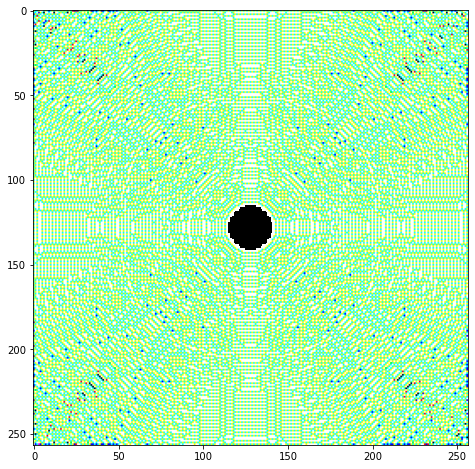

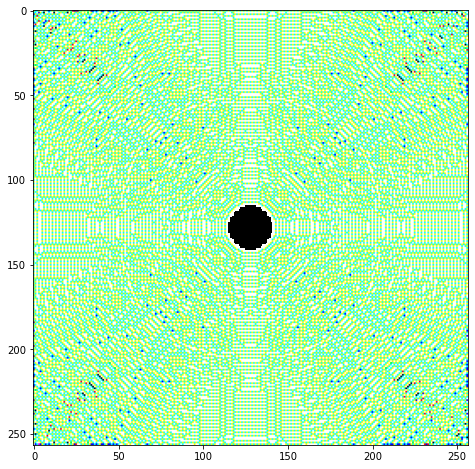

In [225]:
SIZE = 257

# x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, 256//3 : 2*256//3, 256//3 : 2*256//3] = 1

# x[:, 3:, SIZE//3, SIZE//3] = 1
# x[:, 3:, 2*SIZE//3, 2*SIZE//3] = 1

imgs = []

timeSteps = 500
for i in range(timeSteps):
#     print(i, stop)
    nx = x.cpu().numpy()[0, :4, :, :].transpose(1, 2, 0)
    nx = rgba2rgb(nx)
    imgs.append(nx)
    
    if i%50 == 0:
        plt.clf()
        plt.imshow(nx)
        plt.gcf().set_size_inches((8,8))
        display.clear_output(wait=True)
        print(f'{i}')
        display.display(plt.gcf())
        time.sleep(0.01)

    x = CA_run.forward(x, step_size=1, fire_rate=1)    
    x = x.detach()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [13]:
target = imread("target.png").transpose(2,0,1)[:4, :, :]

In [14]:
optim = torch.optim.Adam(CA.parameters(), lr=2e-3)

In [360]:
for p in optim.param_groups:
    p['lr'] = 1e-5

  0%|          | 0/4000 [00:00<?, ?it/s]

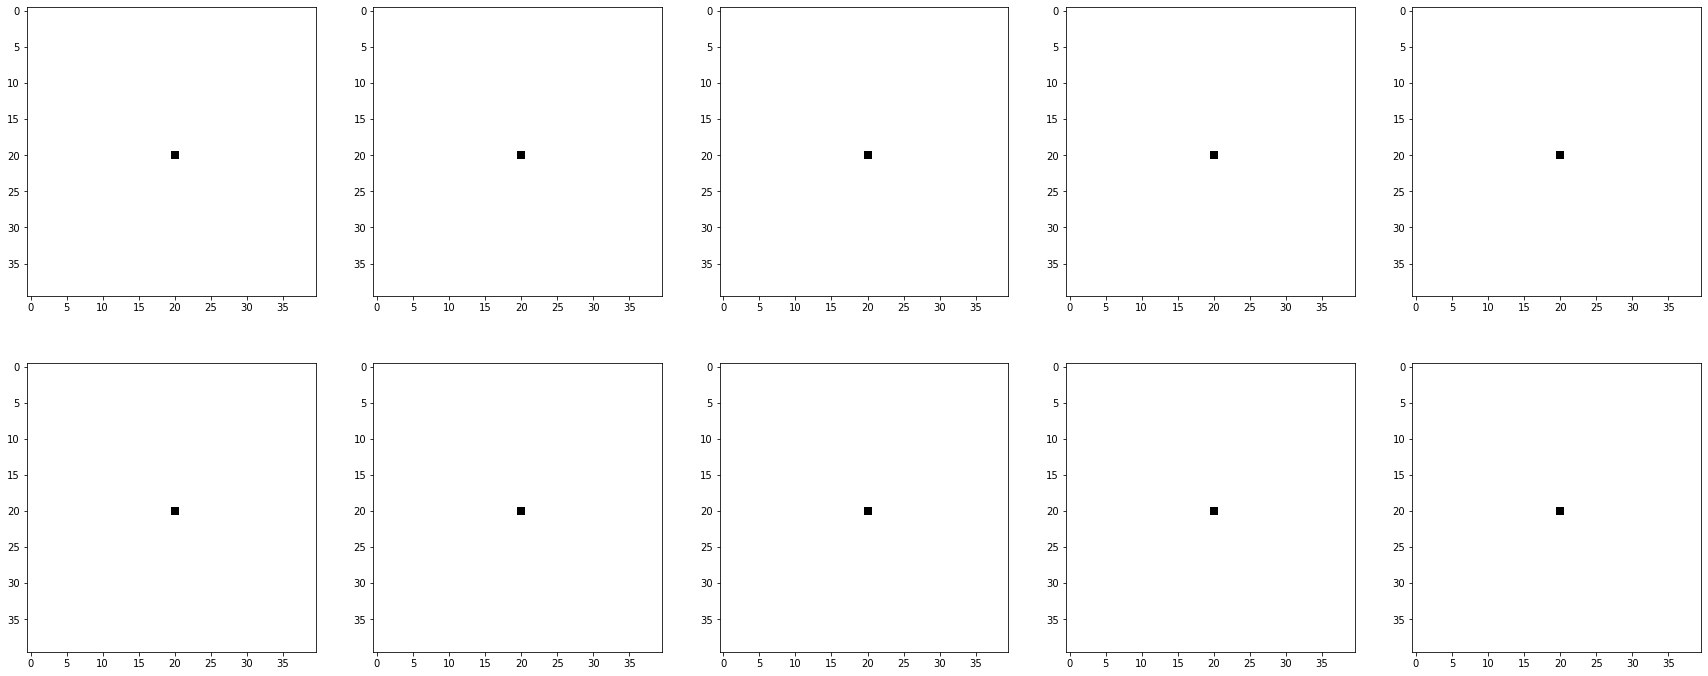

  1%|▏         | 50/4000 [01:32<1:55:07,  1.75s/it]

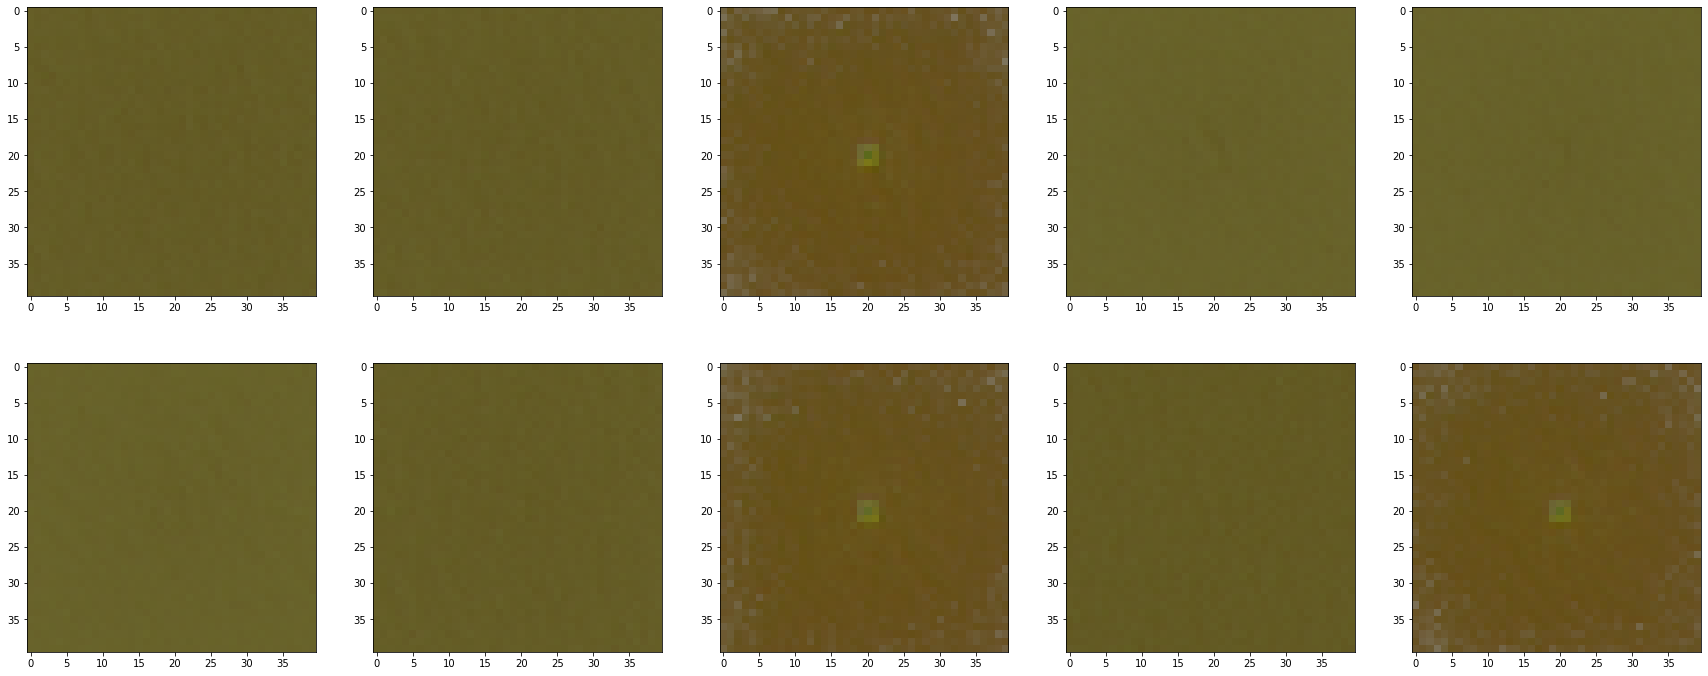

  2%|▎         | 100/4000 [03:07<1:51:36,  1.72s/it]

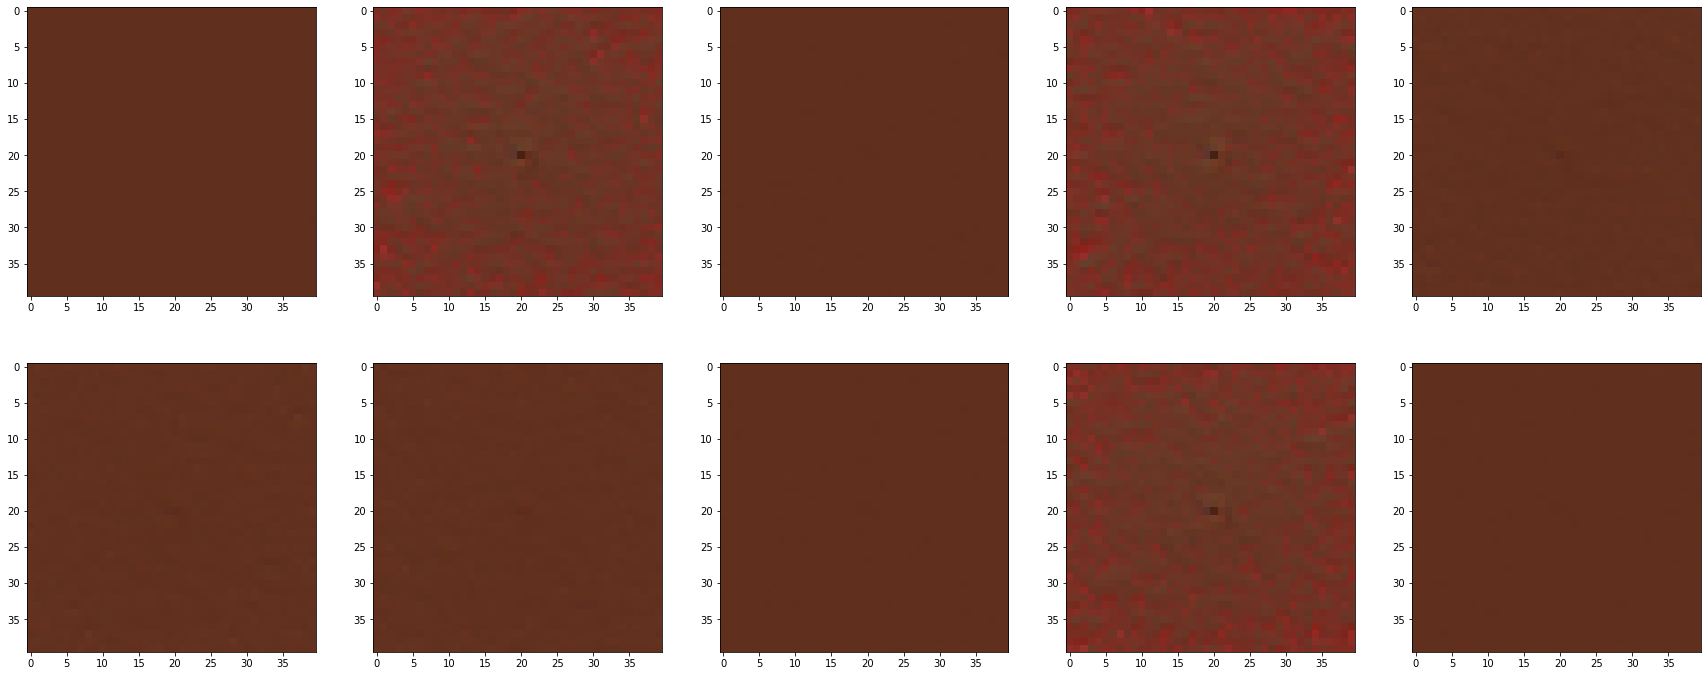

  4%|▍         | 150/4000 [04:41<1:55:42,  1.80s/it]

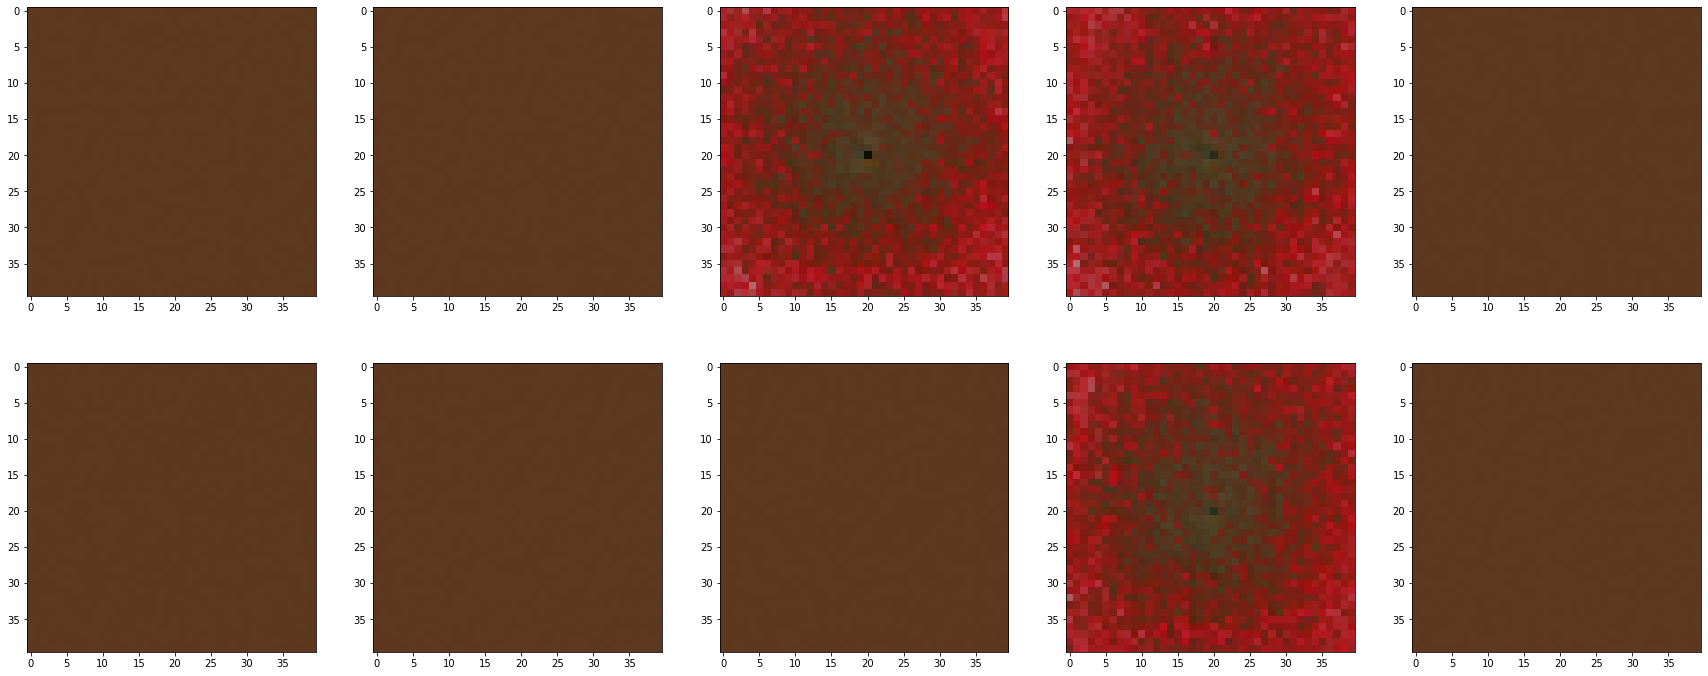

  5%|▌         | 200/4000 [06:12<2:00:47,  1.91s/it]

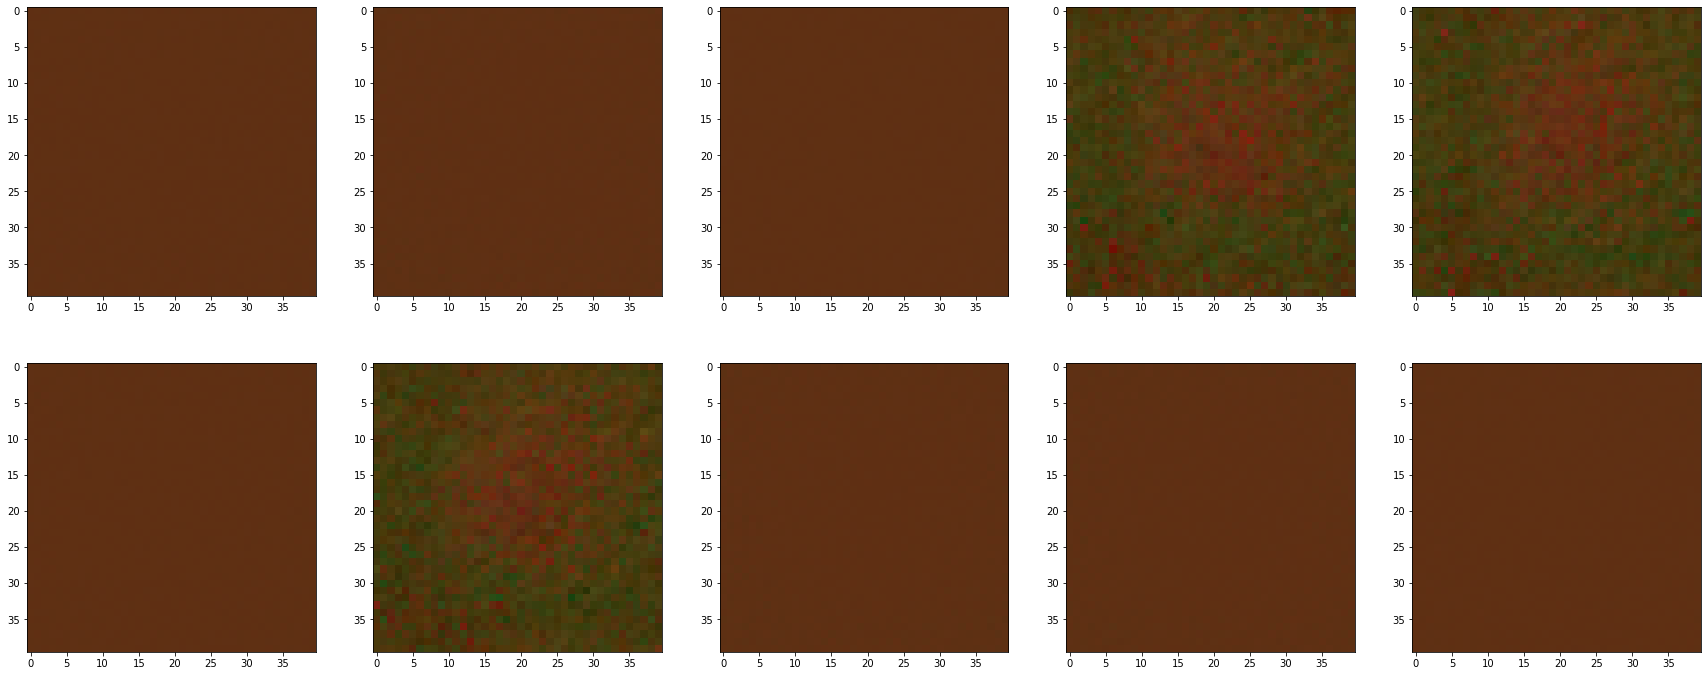

  6%|▋         | 250/4000 [07:45<1:45:33,  1.69s/it]

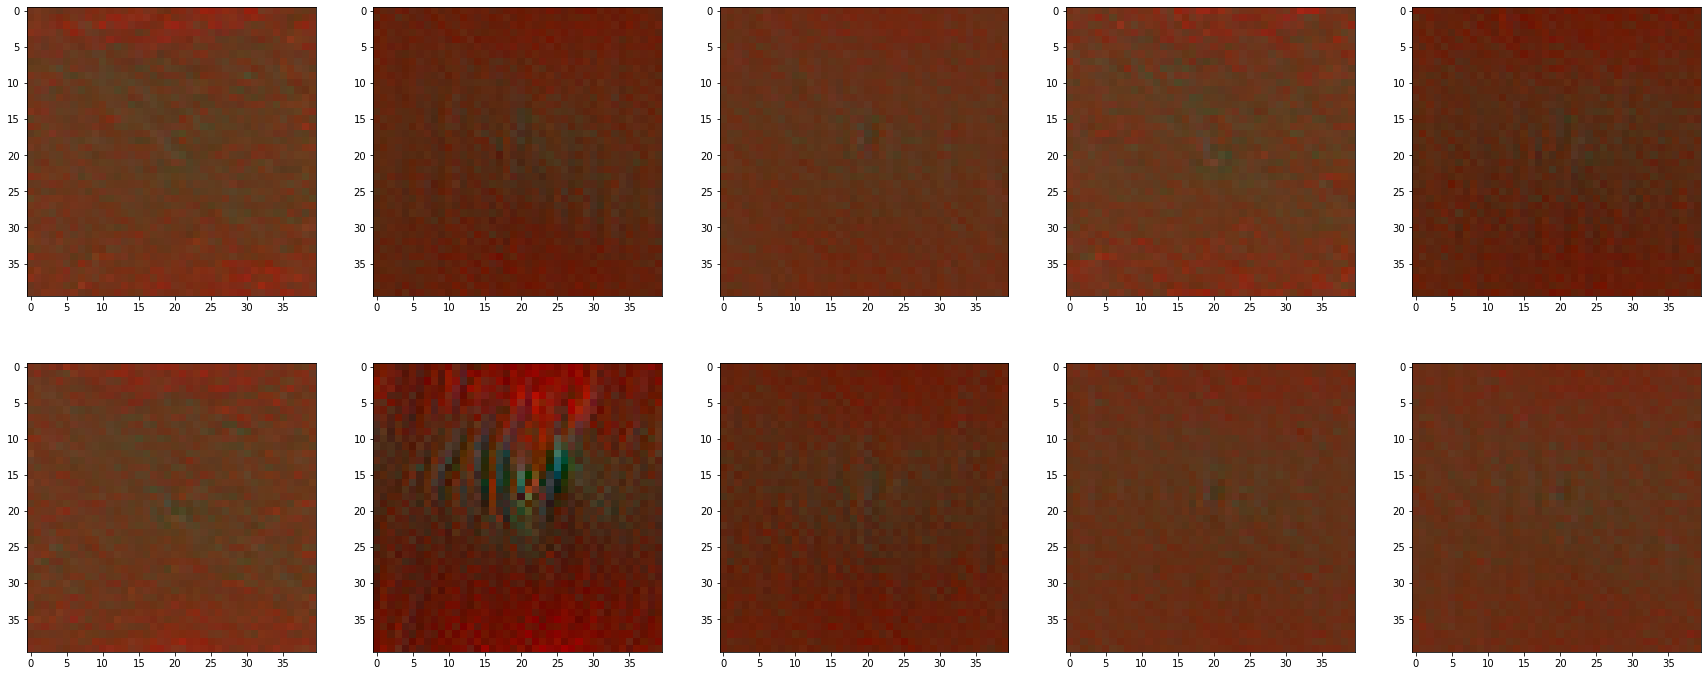

  8%|▊         | 300/4000 [09:26<2:15:18,  2.19s/it]

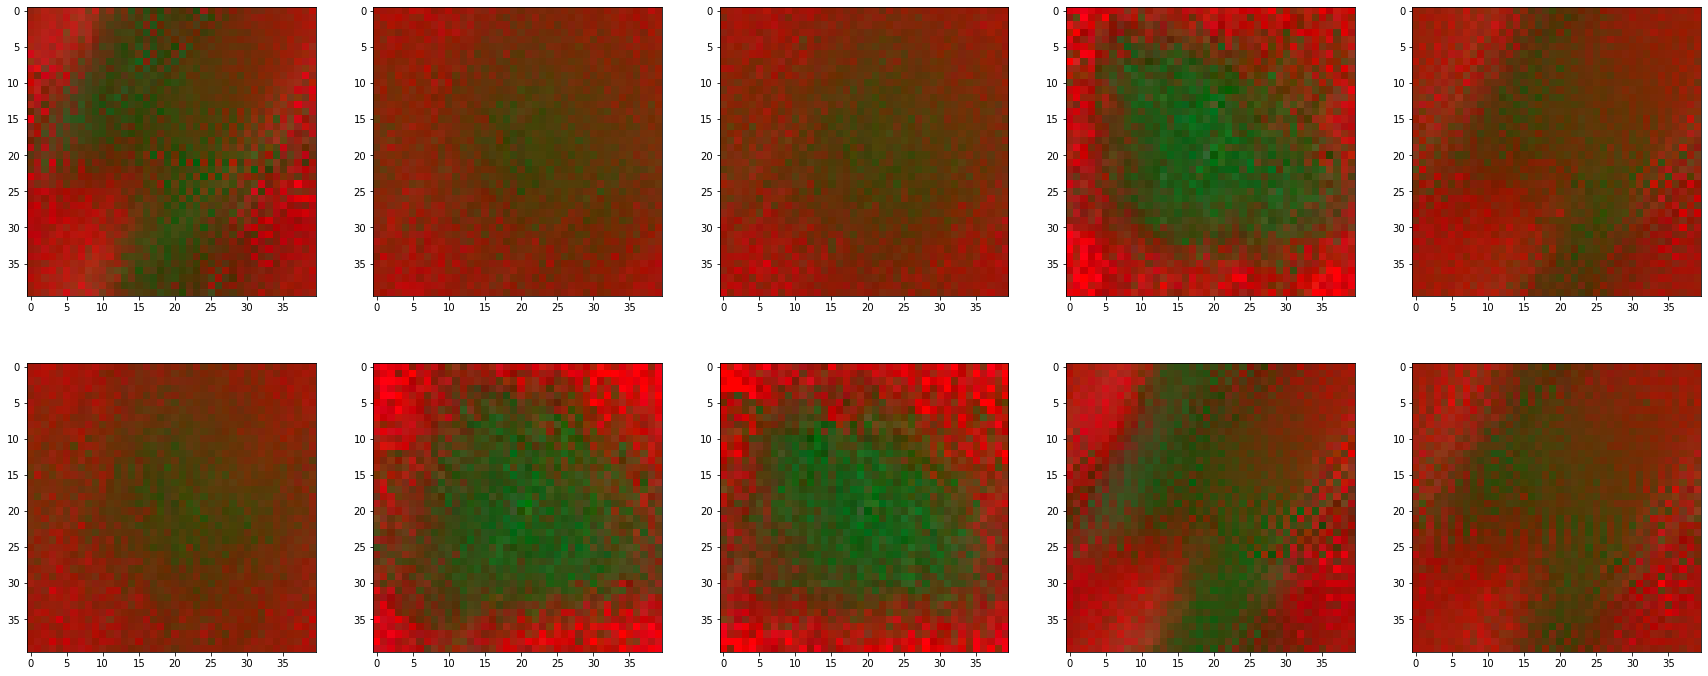

  9%|▉         | 350/4000 [11:21<2:14:20,  2.21s/it]

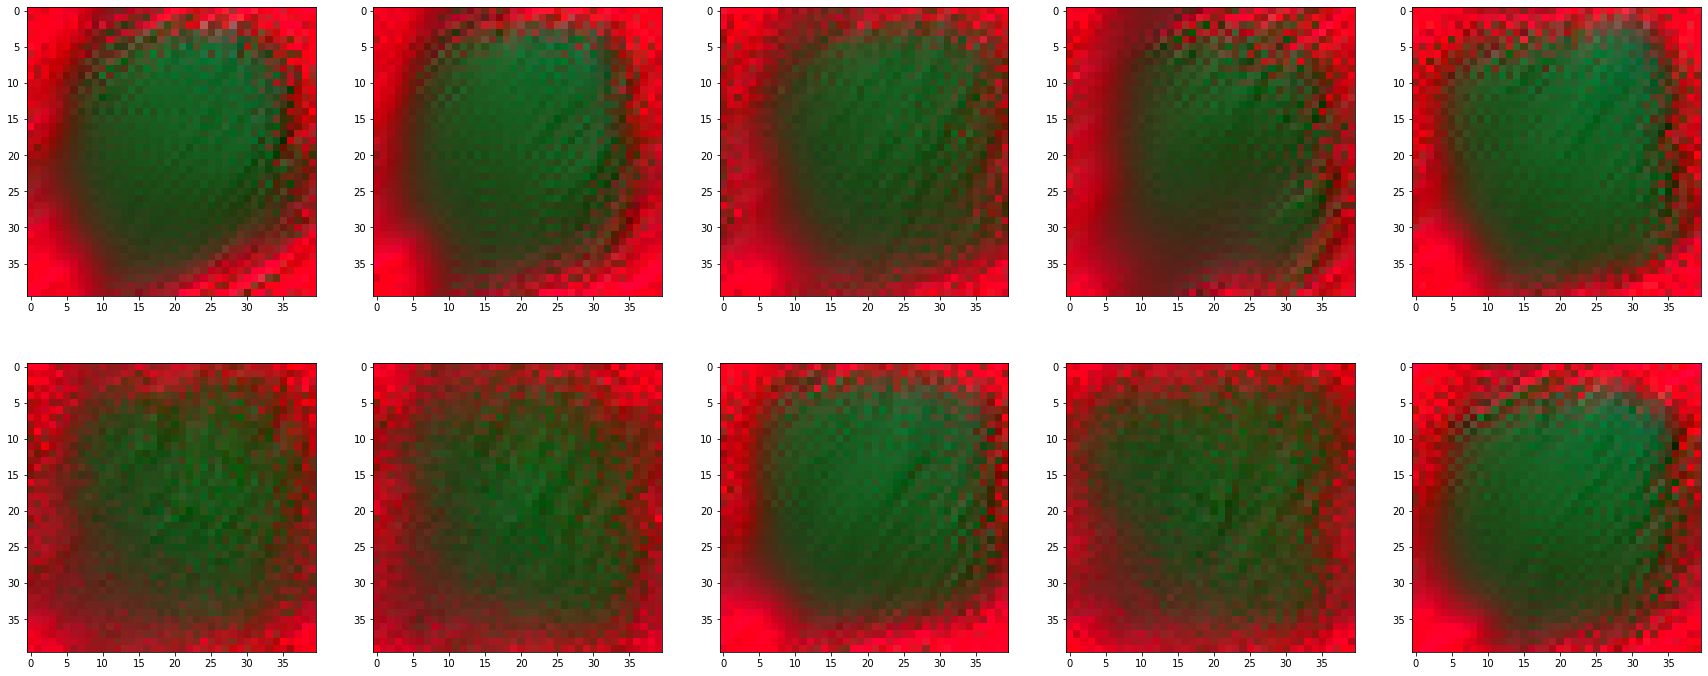

 10%|█         | 400/4000 [13:13<2:12:11,  2.20s/it]

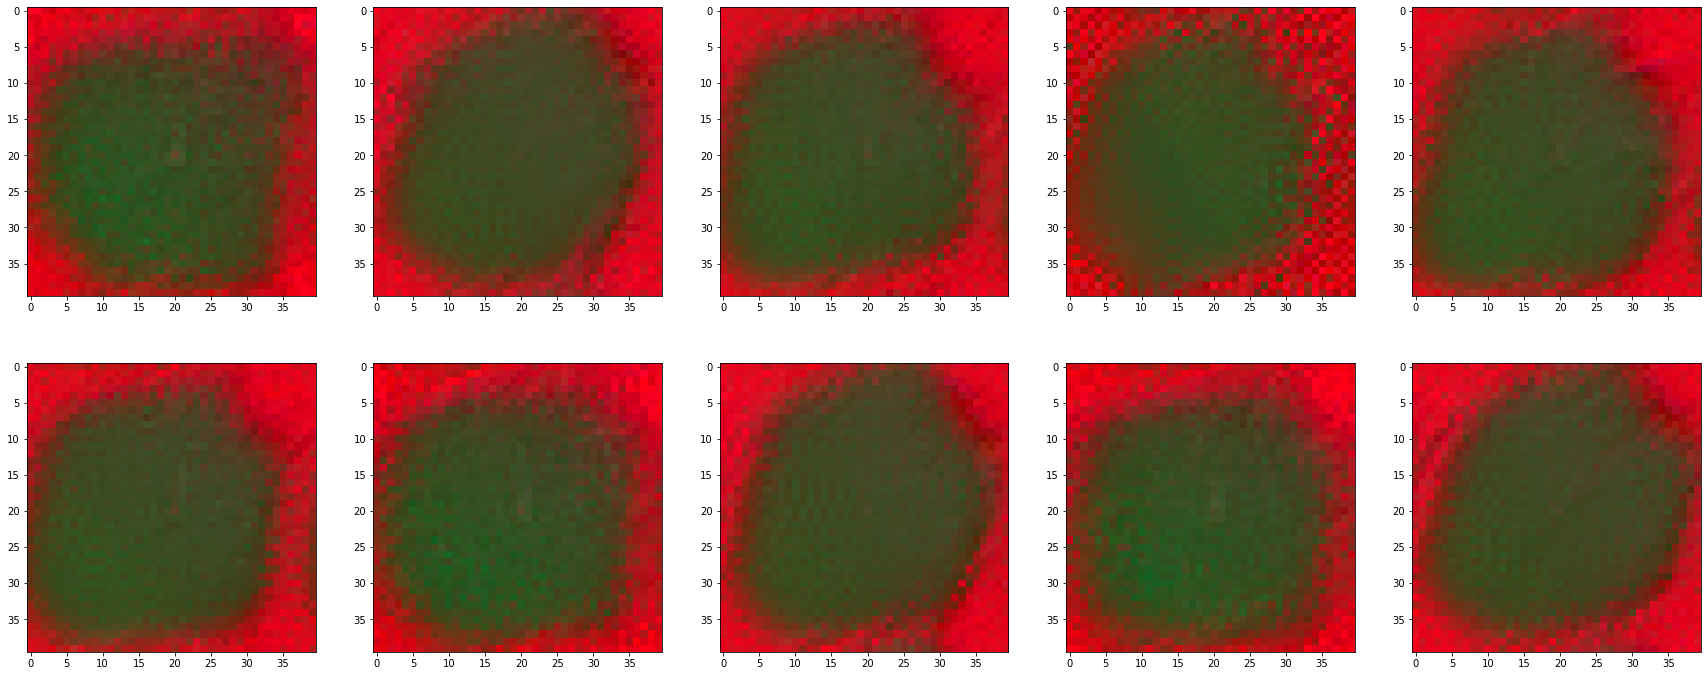

 11%|█▏        | 450/4000 [15:09<2:17:25,  2.32s/it]

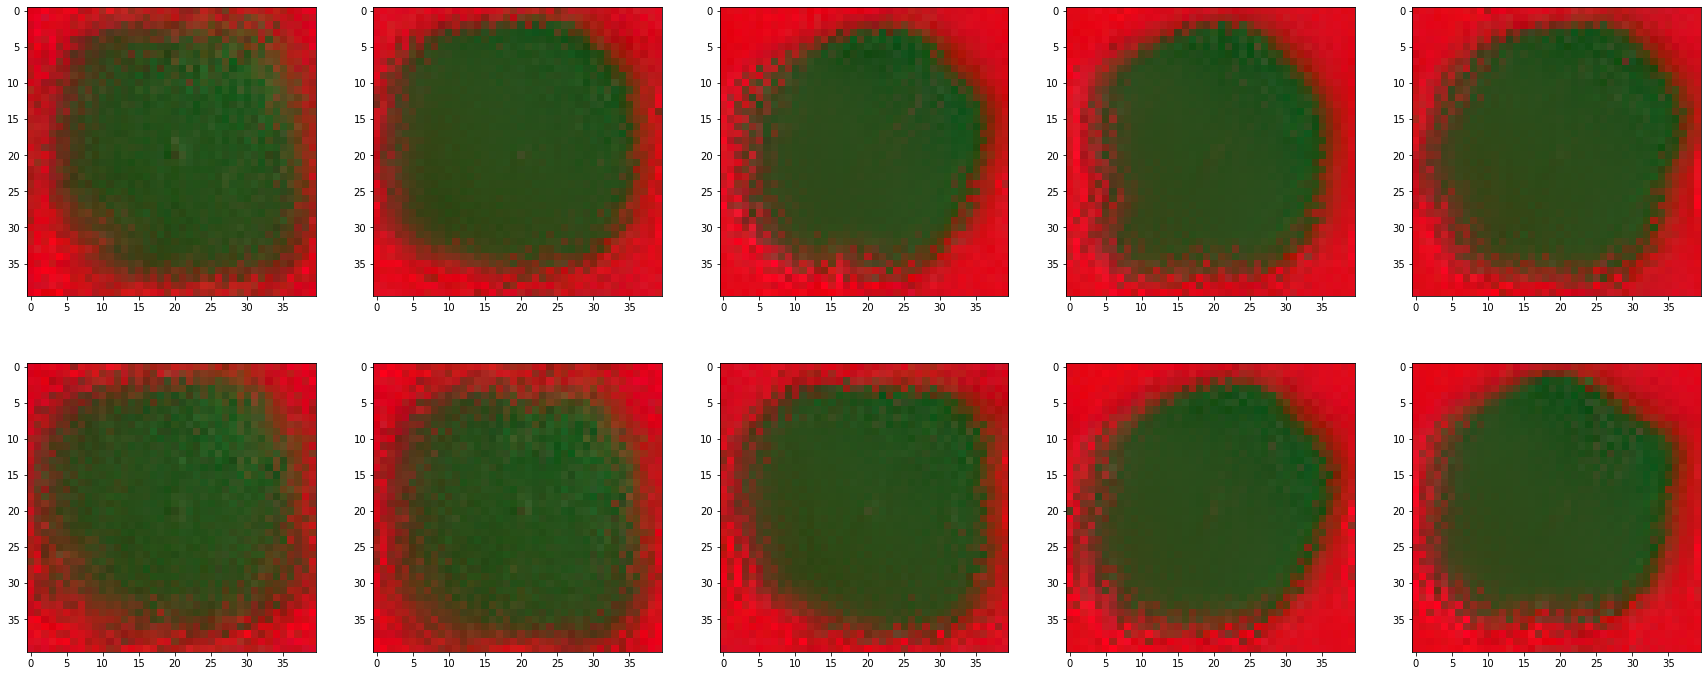

 12%|█▎        | 500/4000 [17:00<2:04:27,  2.13s/it]

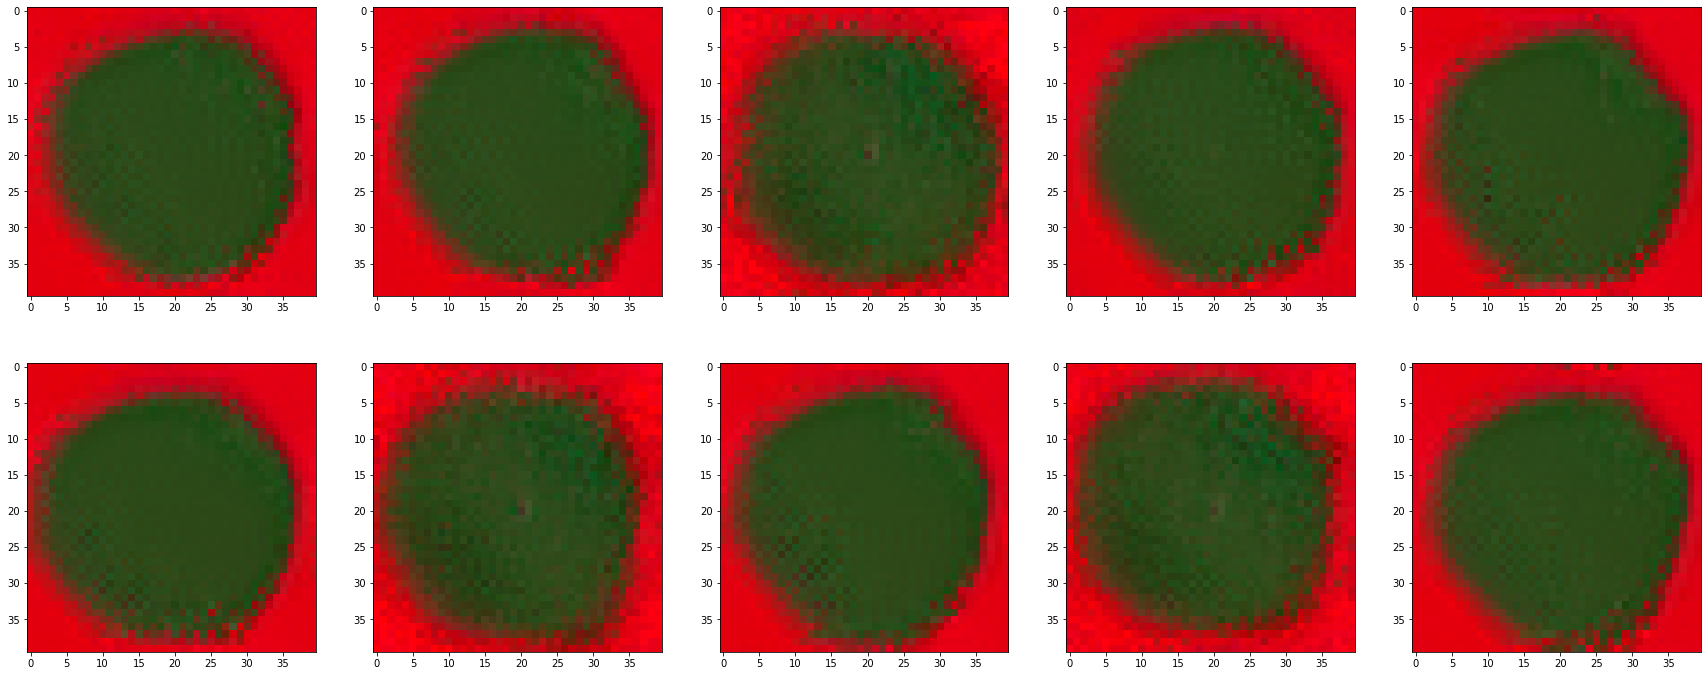

 14%|█▍        | 550/4000 [18:50<2:04:00,  2.16s/it]

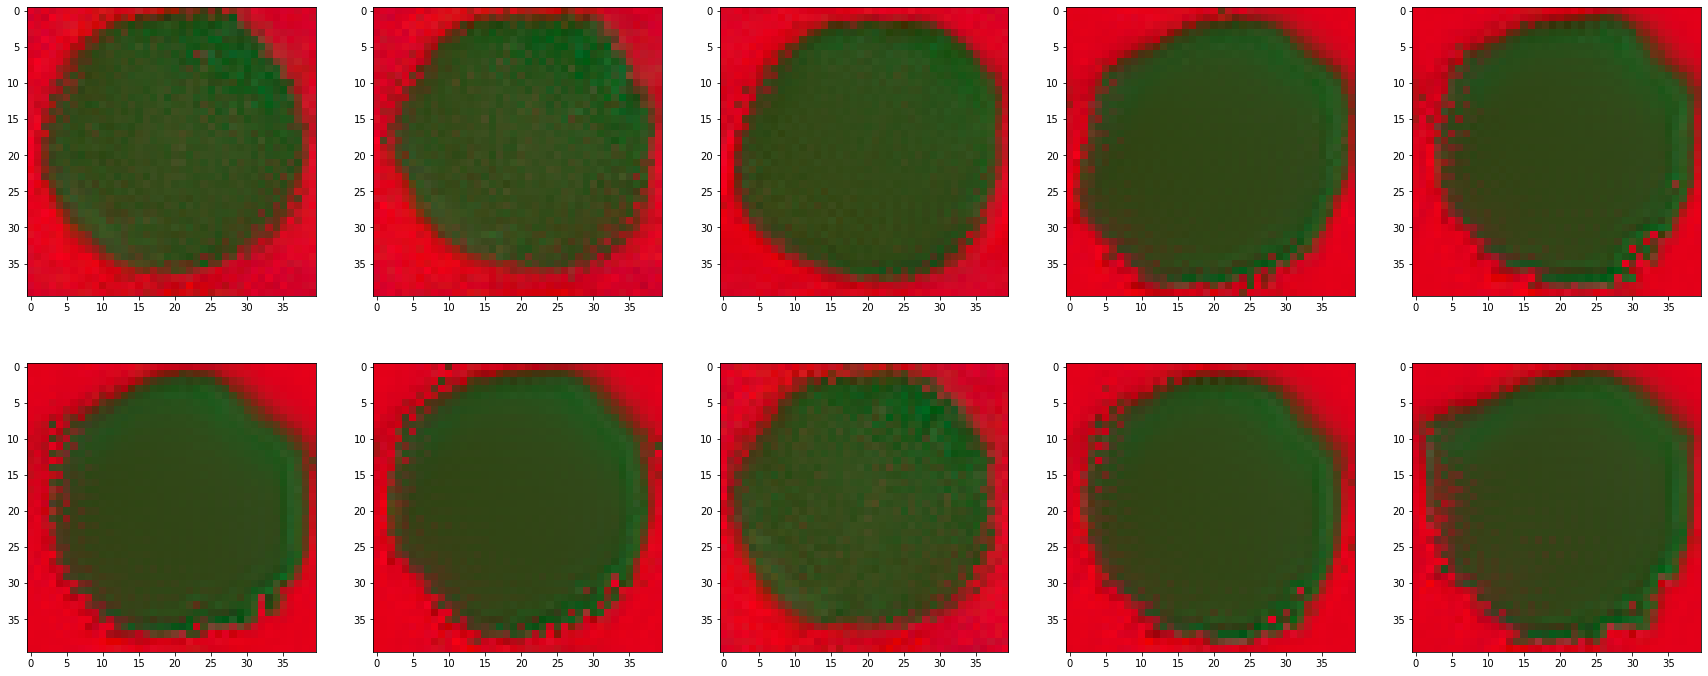

 15%|█▌        | 600/4000 [20:44<2:07:09,  2.24s/it]

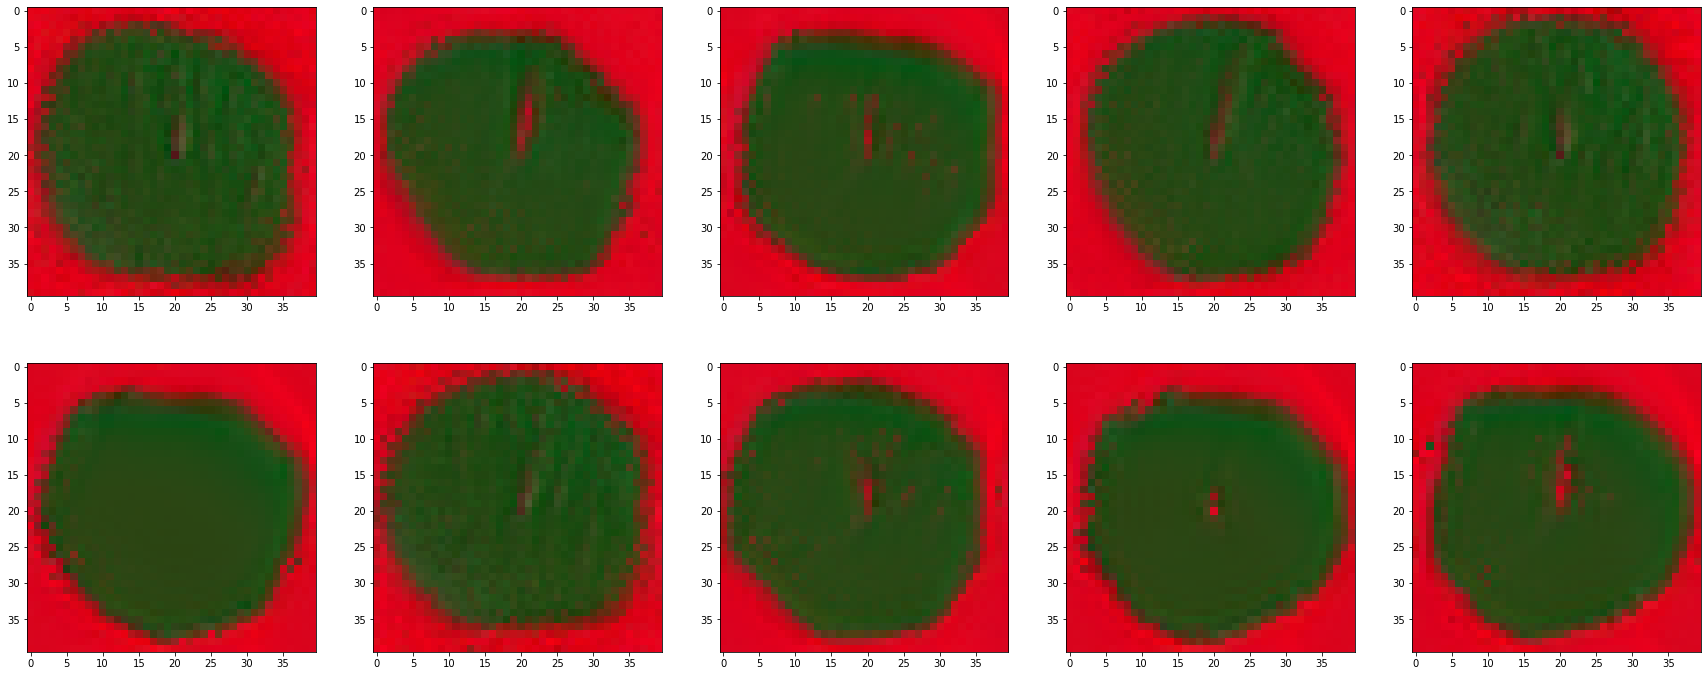

 16%|█▋        | 650/4000 [22:39<1:57:01,  2.10s/it]

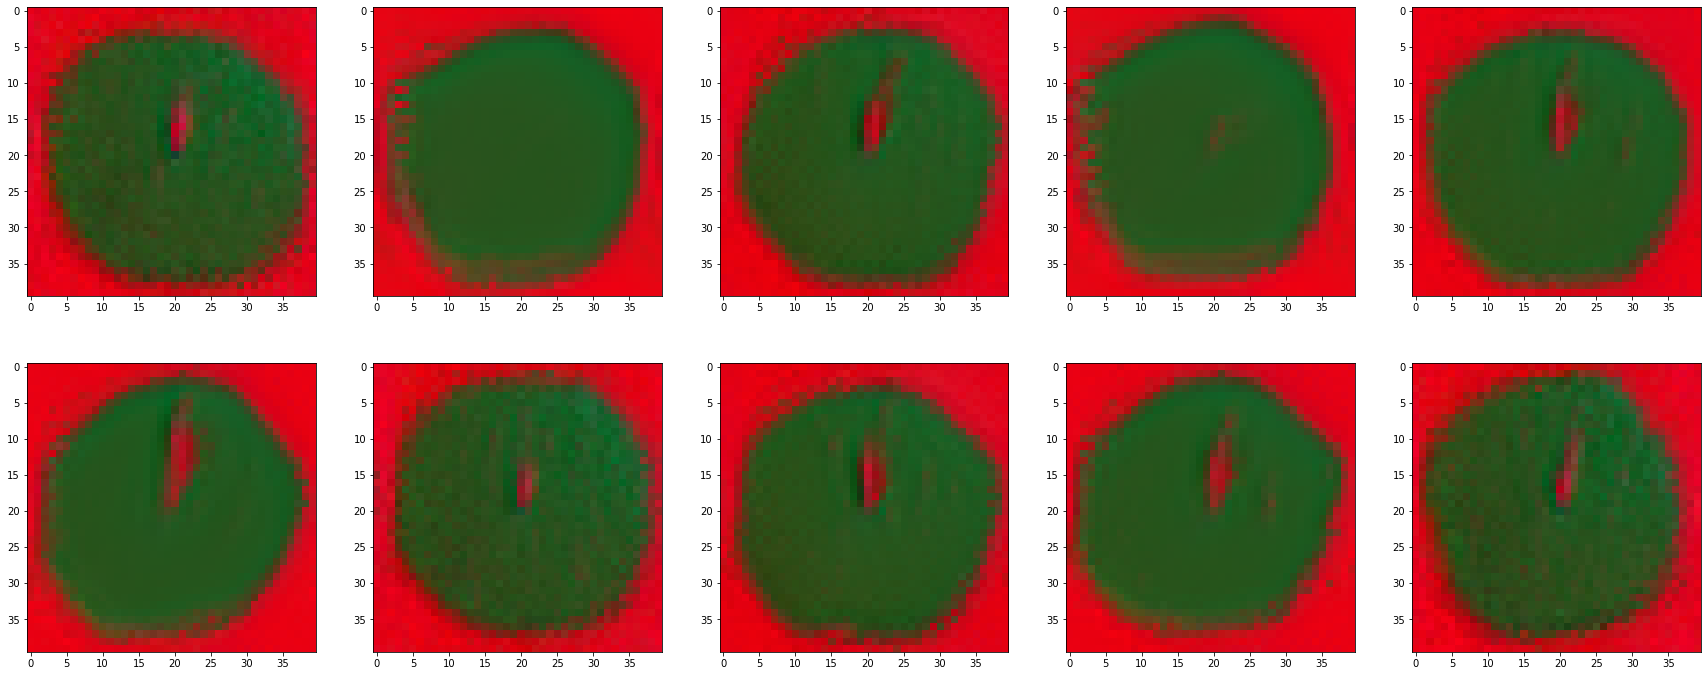

 18%|█▊        | 700/4000 [24:35<1:58:20,  2.15s/it]

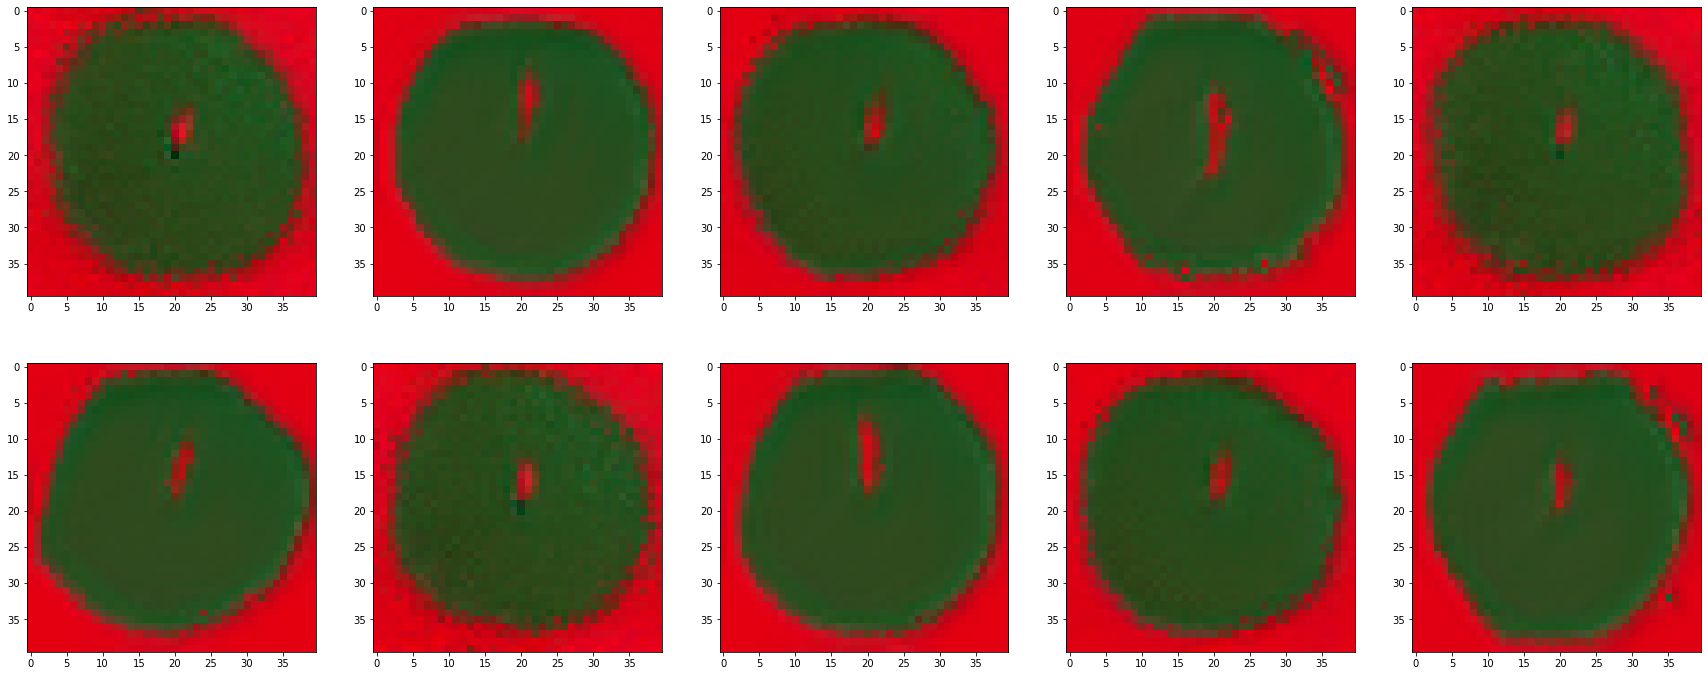

 19%|█▉        | 750/4000 [26:34<2:08:26,  2.37s/it]

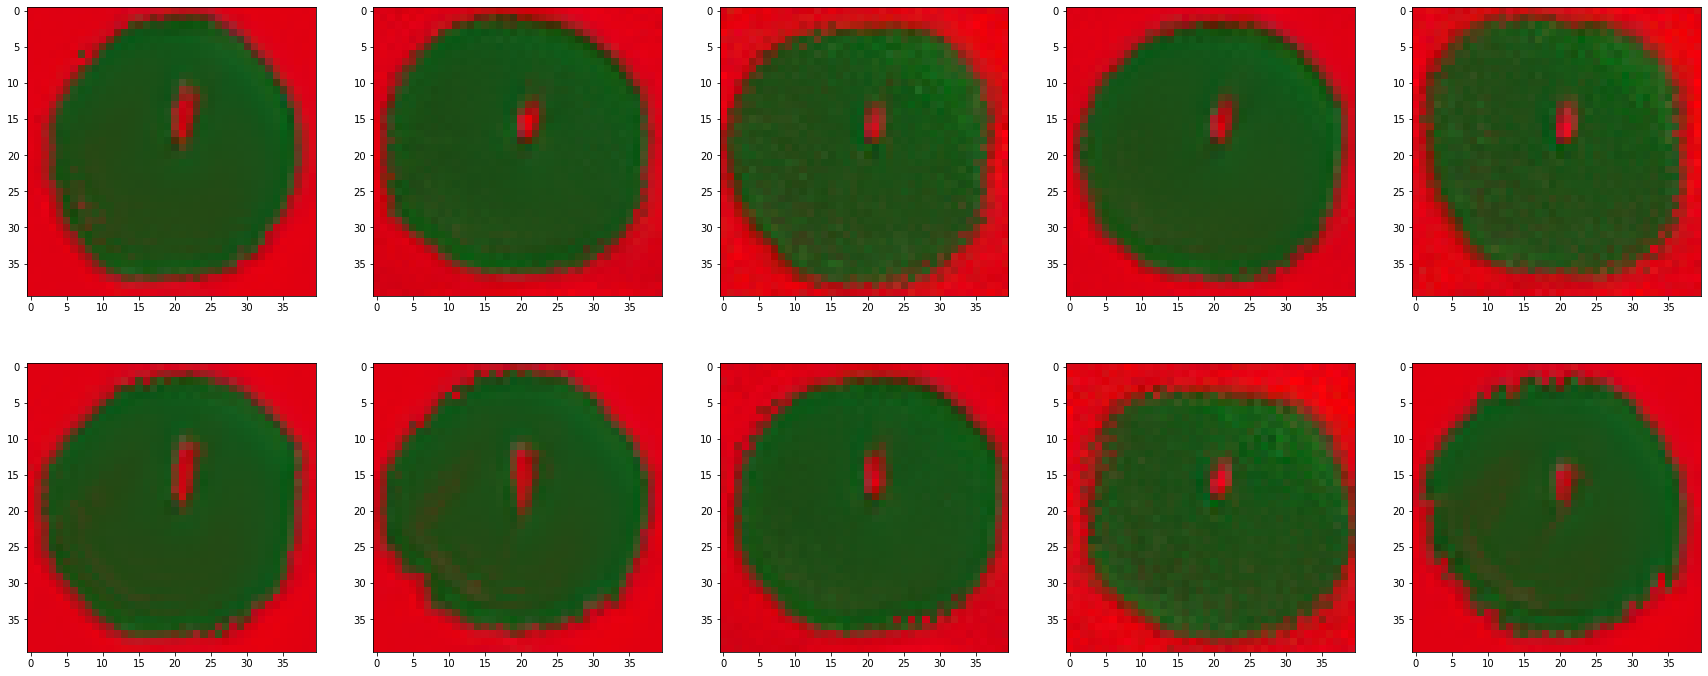

 20%|██        | 800/4000 [28:34<2:02:39,  2.30s/it]

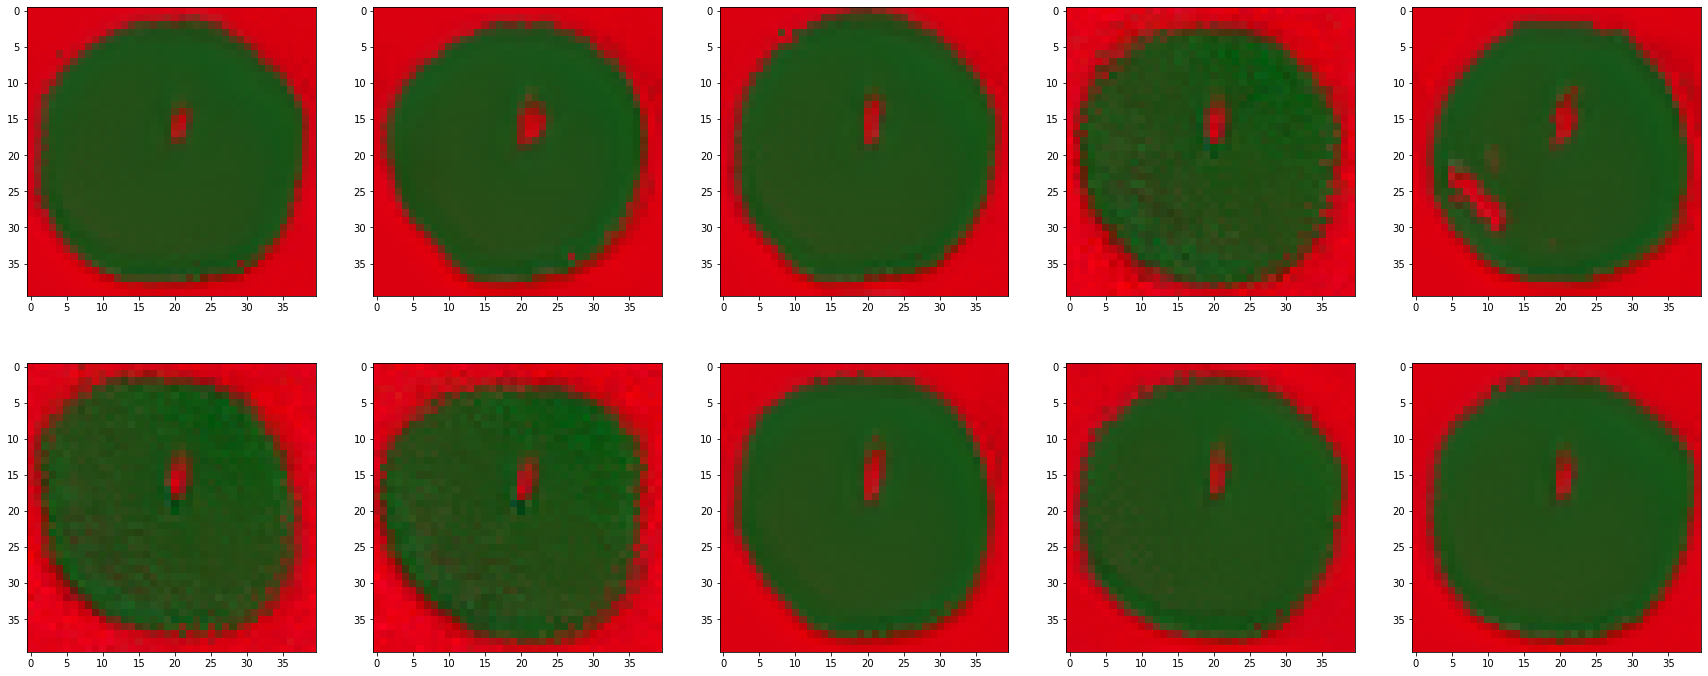

 21%|██▏       | 850/4000 [30:32<1:52:35,  2.14s/it]

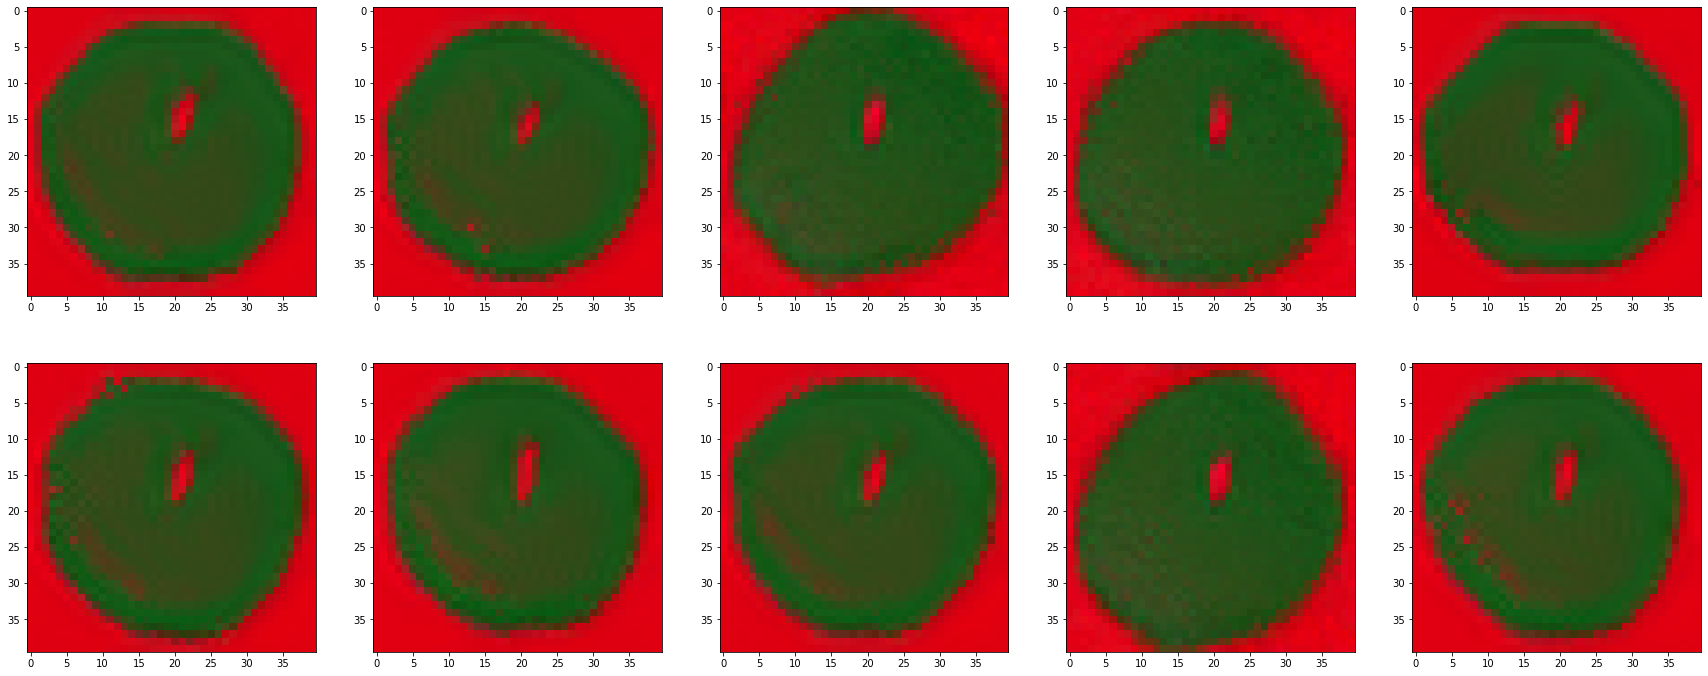

 22%|██▎       | 900/4000 [32:34<1:59:09,  2.31s/it]

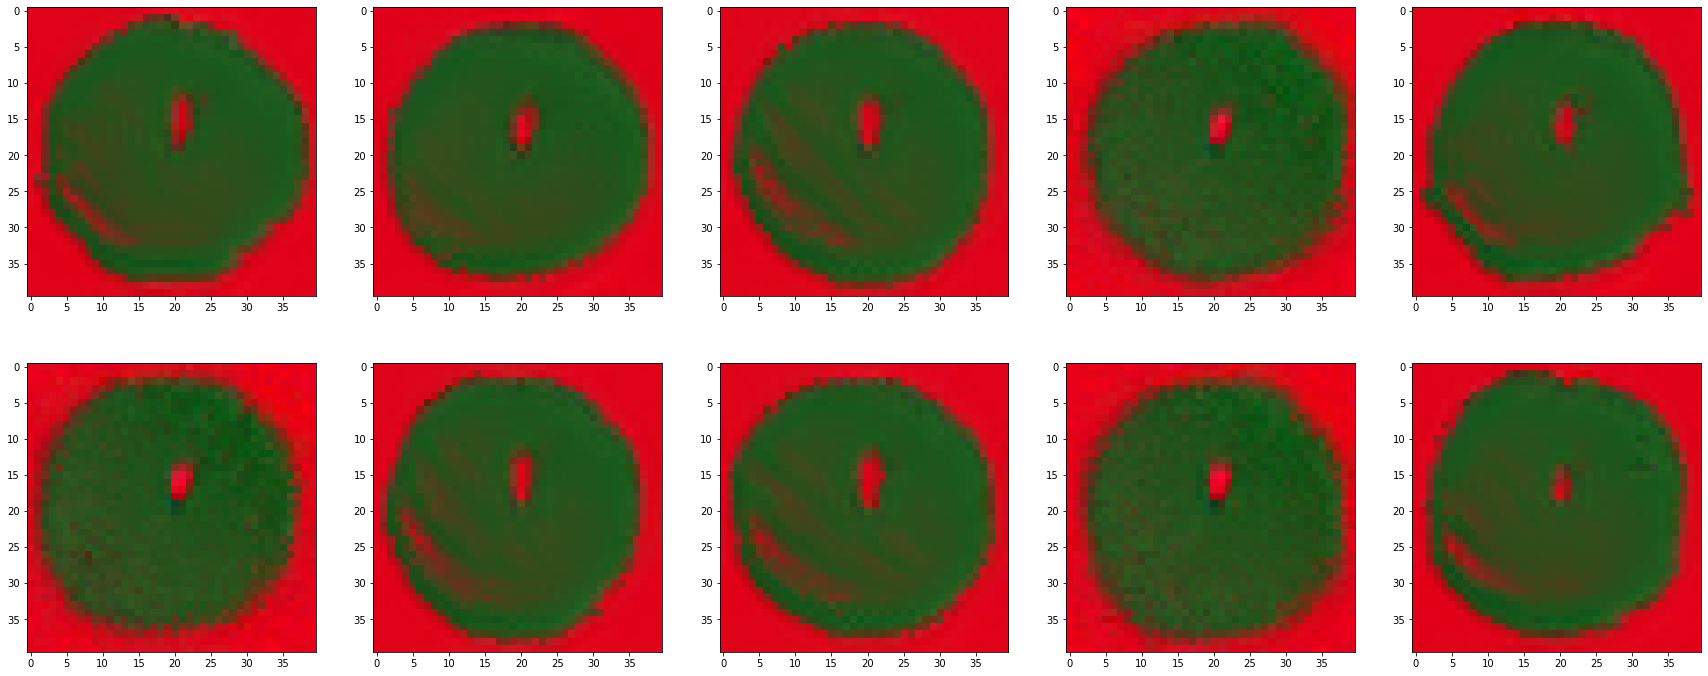

 24%|██▍       | 950/4000 [34:33<2:01:07,  2.38s/it]

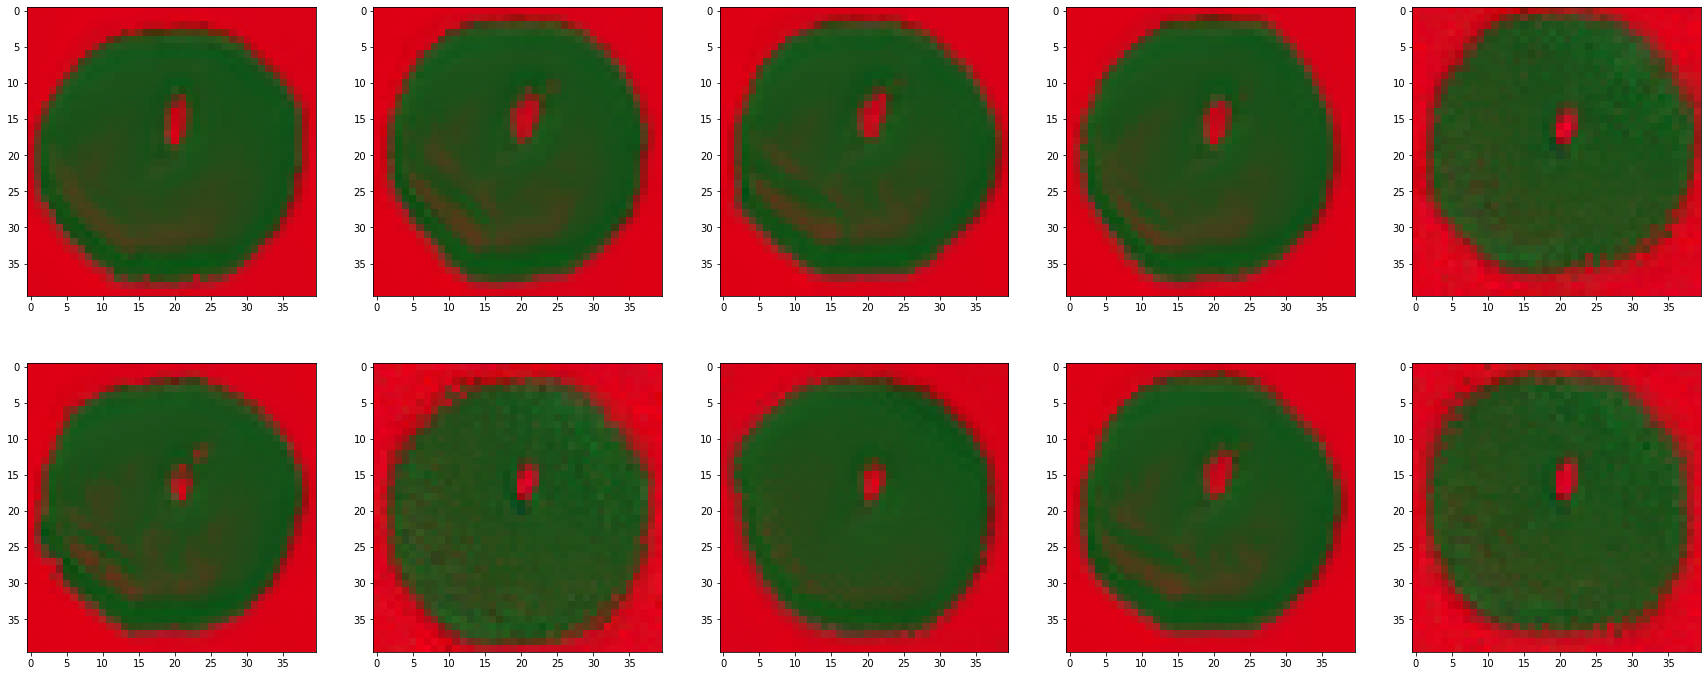

 25%|██▌       | 1000/4000 [36:35<2:02:42,  2.45s/it]

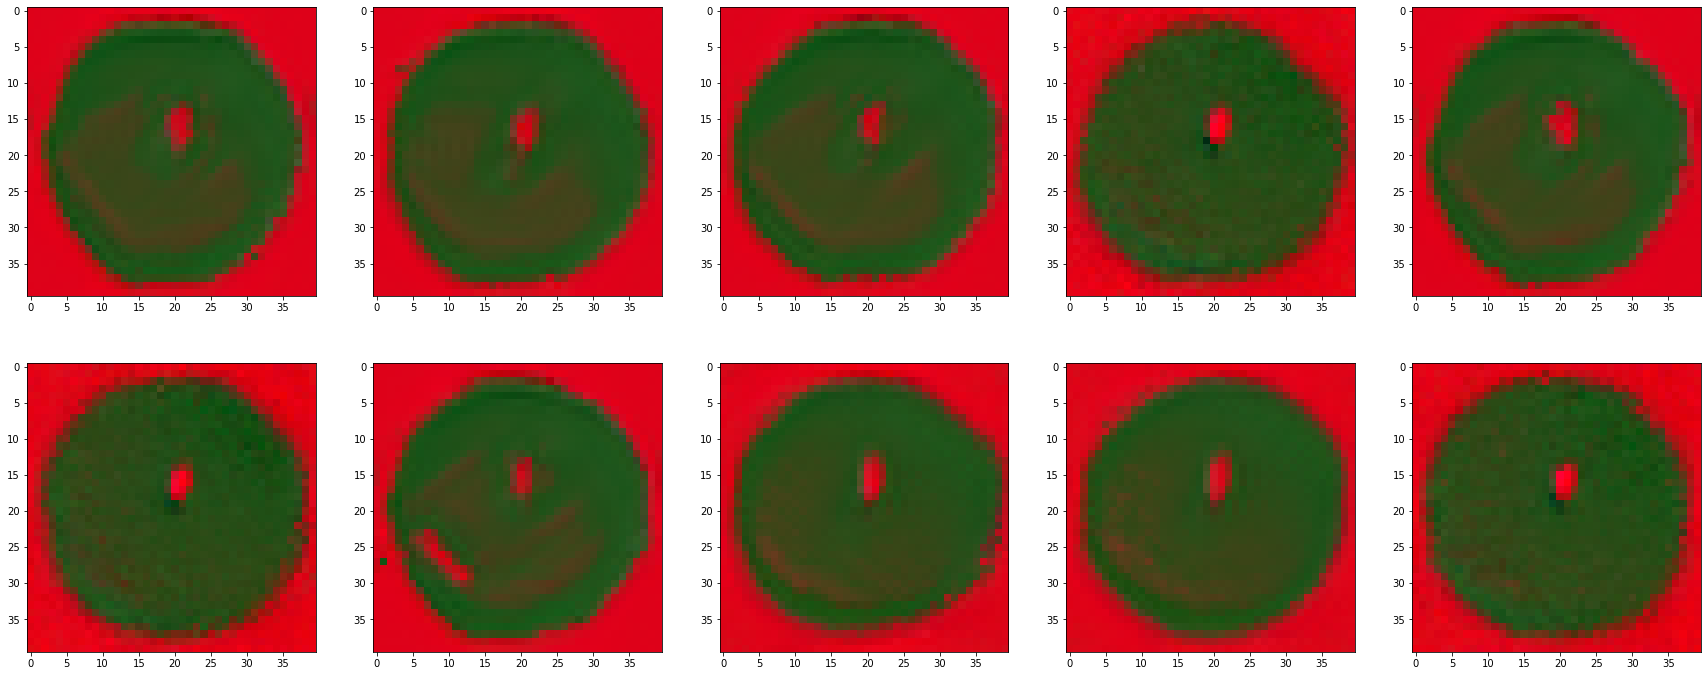

 26%|██▋       | 1050/4000 [38:36<1:58:02,  2.40s/it]

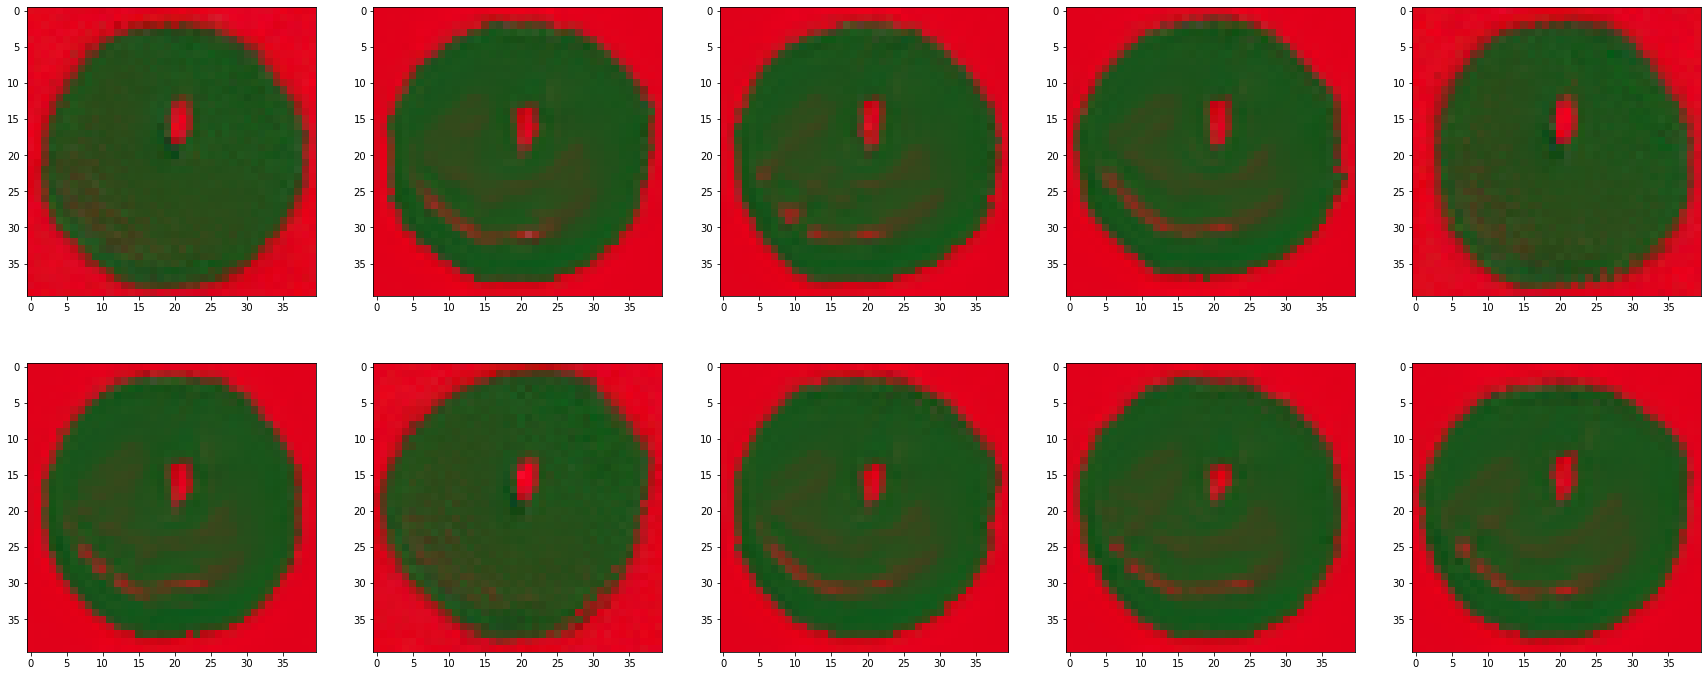

 28%|██▊       | 1100/4000 [40:40<2:10:34,  2.70s/it]

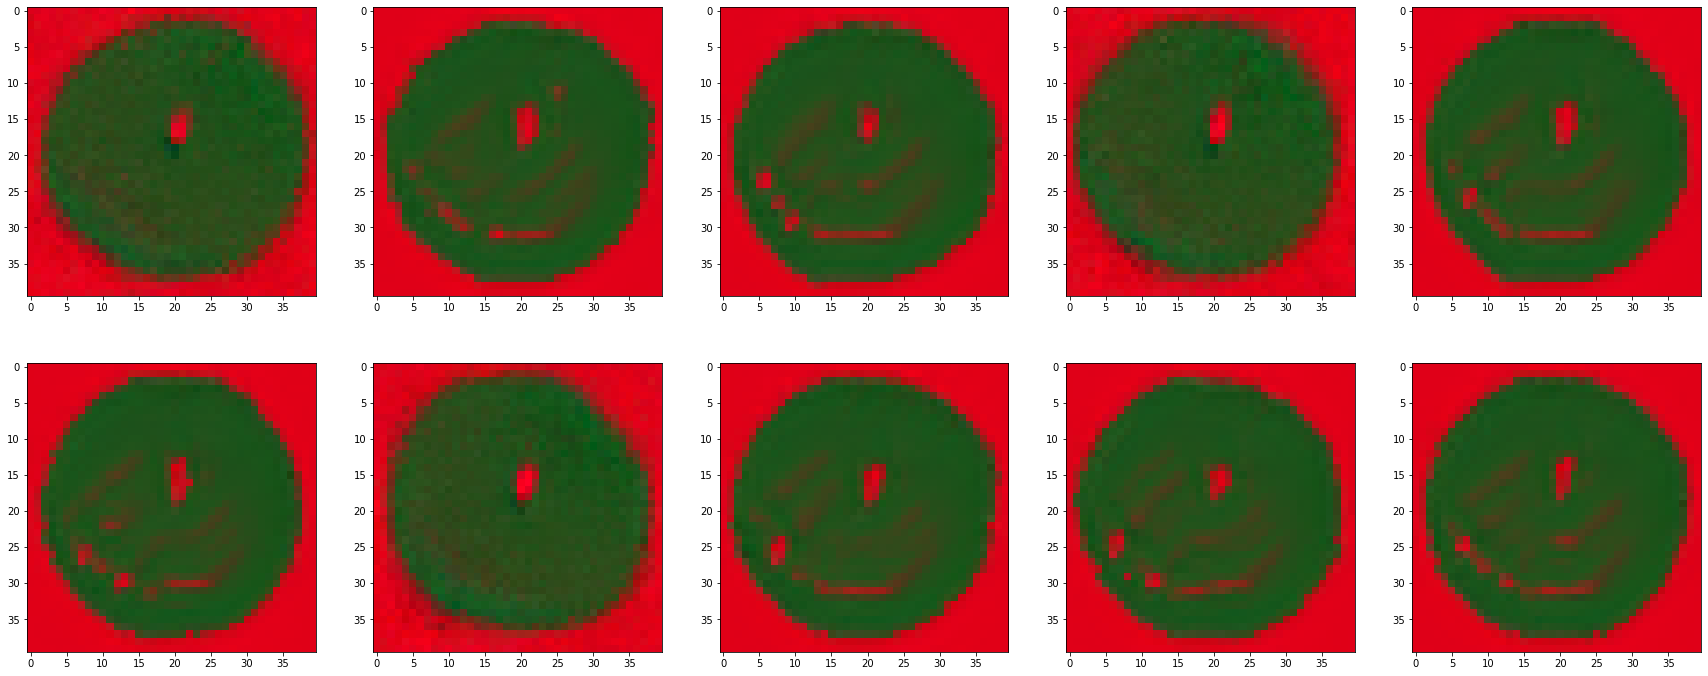

 29%|██▉       | 1150/4000 [42:48<1:50:42,  2.33s/it]

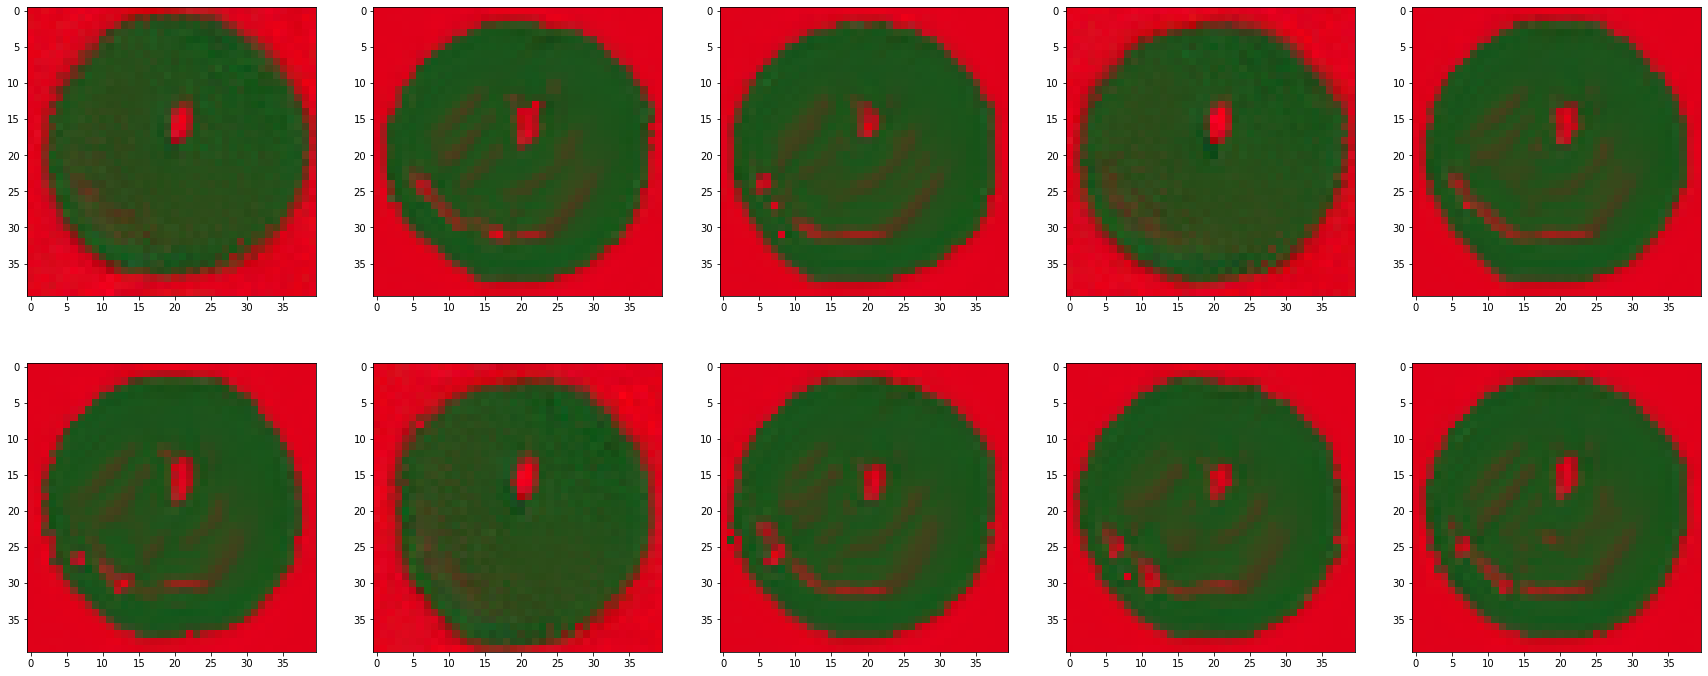

 30%|███       | 1200/4000 [44:49<1:56:13,  2.49s/it]

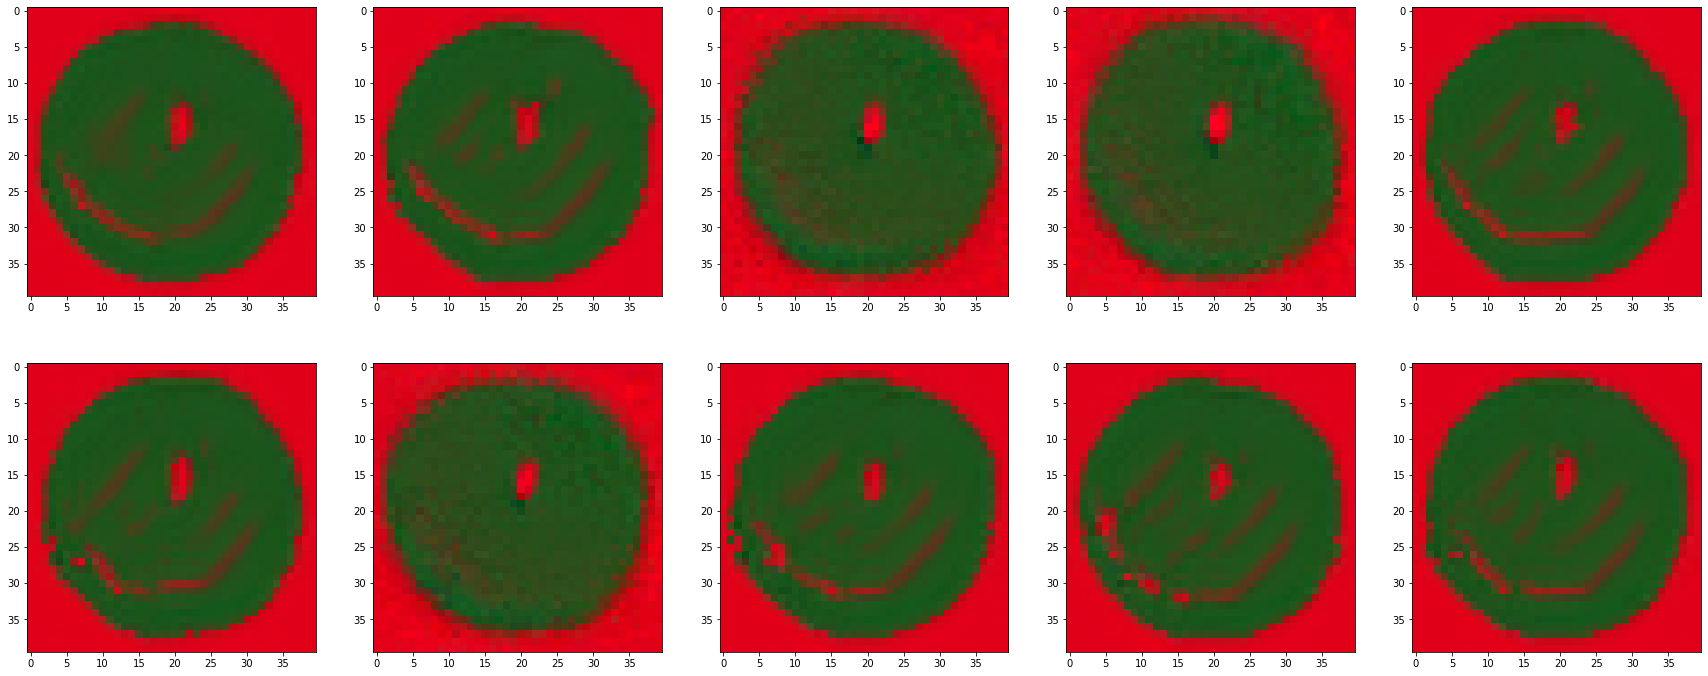

 31%|███▏      | 1250/4000 [46:55<1:48:54,  2.38s/it]

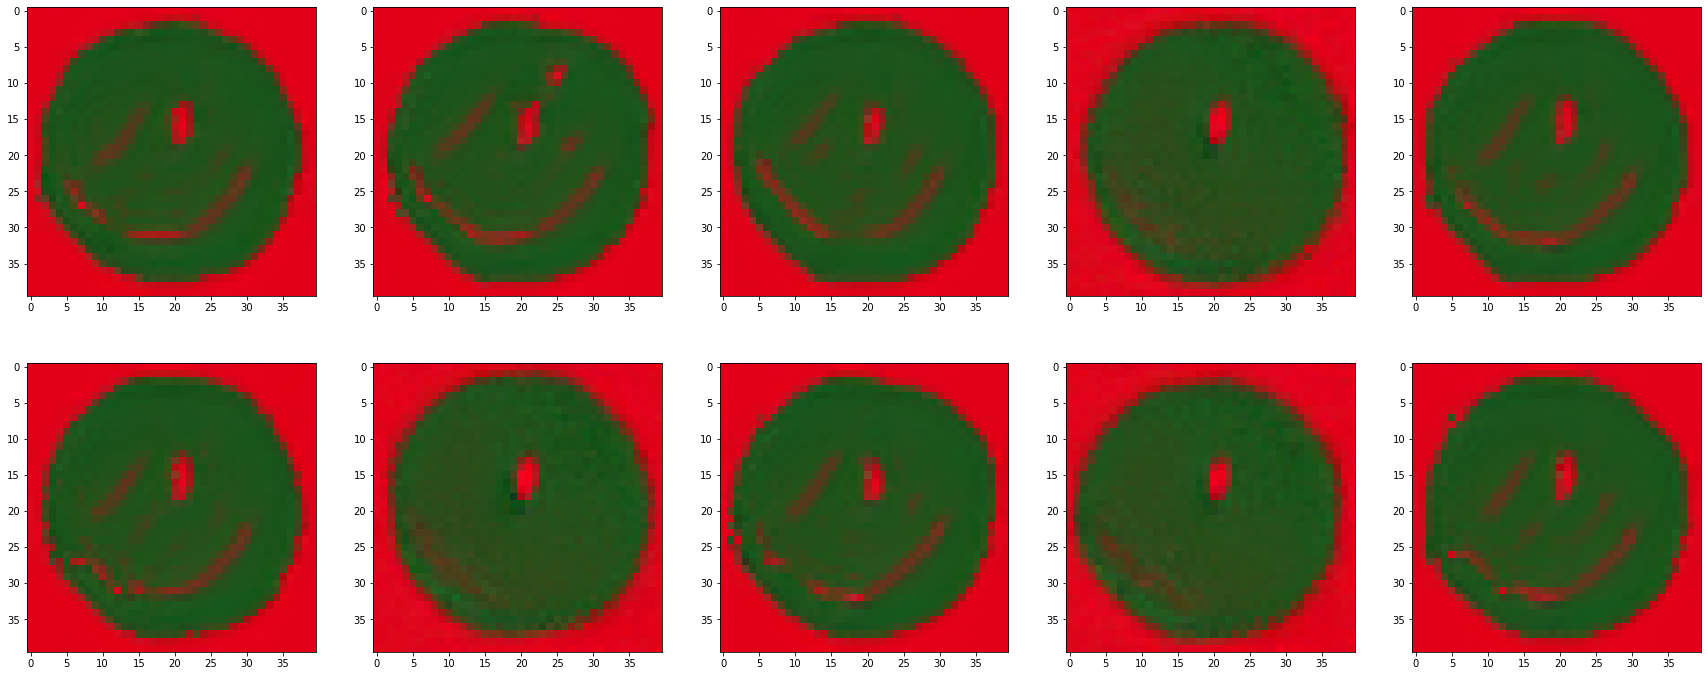

 32%|███▎      | 1300/4000 [49:04<1:44:51,  2.33s/it]

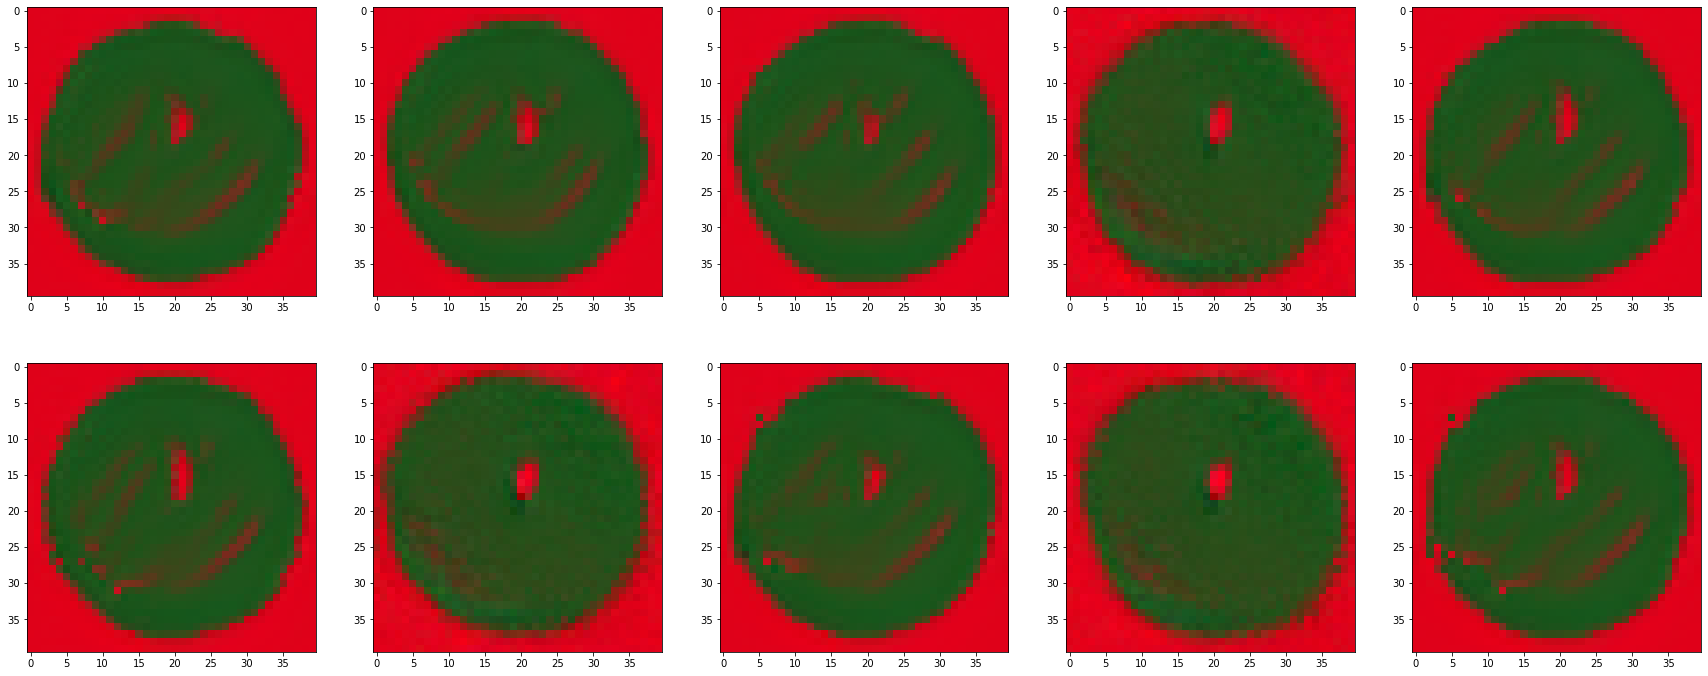

 34%|███▍      | 1350/4000 [51:03<1:32:05,  2.09s/it]

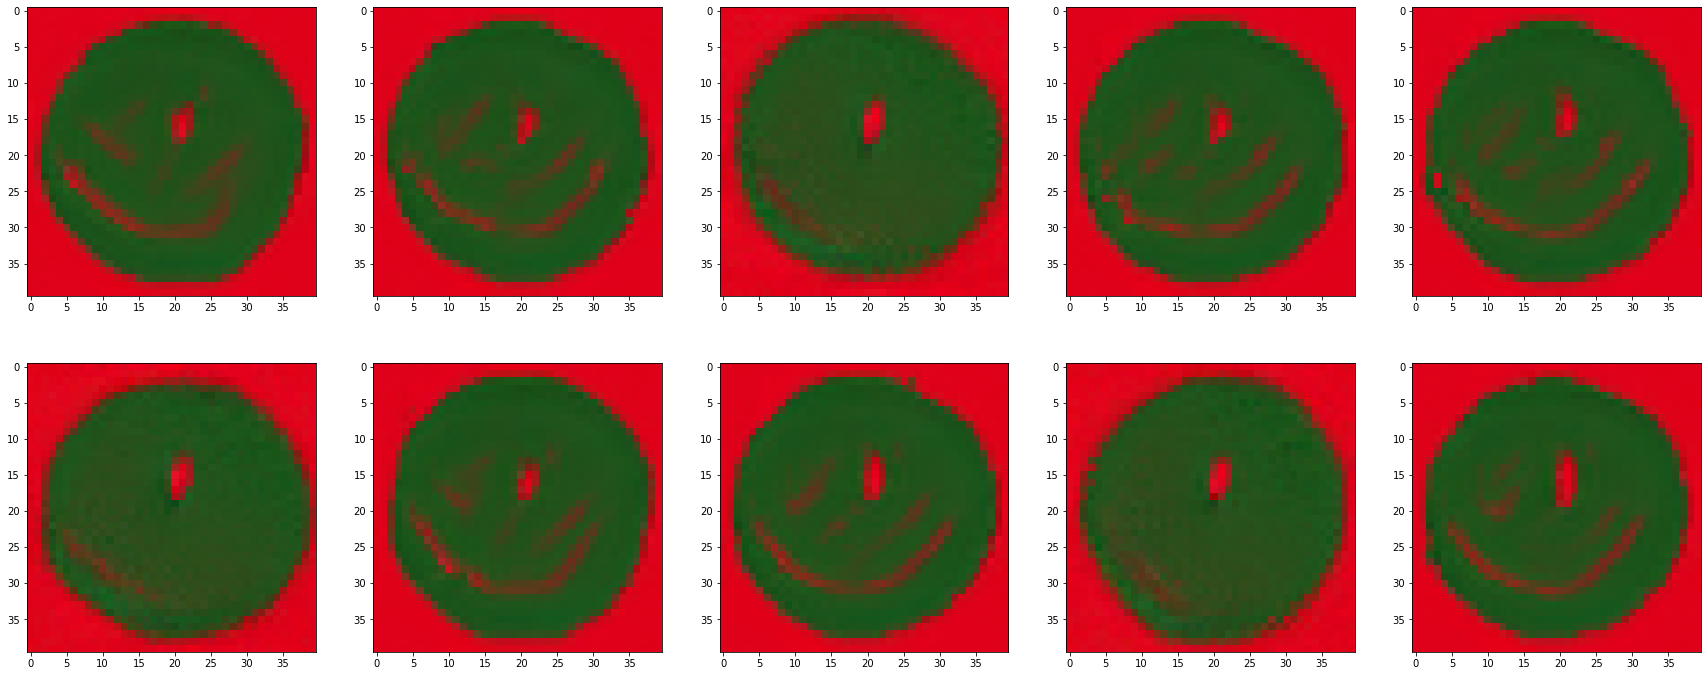

 35%|███▌      | 1400/4000 [52:46<1:26:58,  2.01s/it]

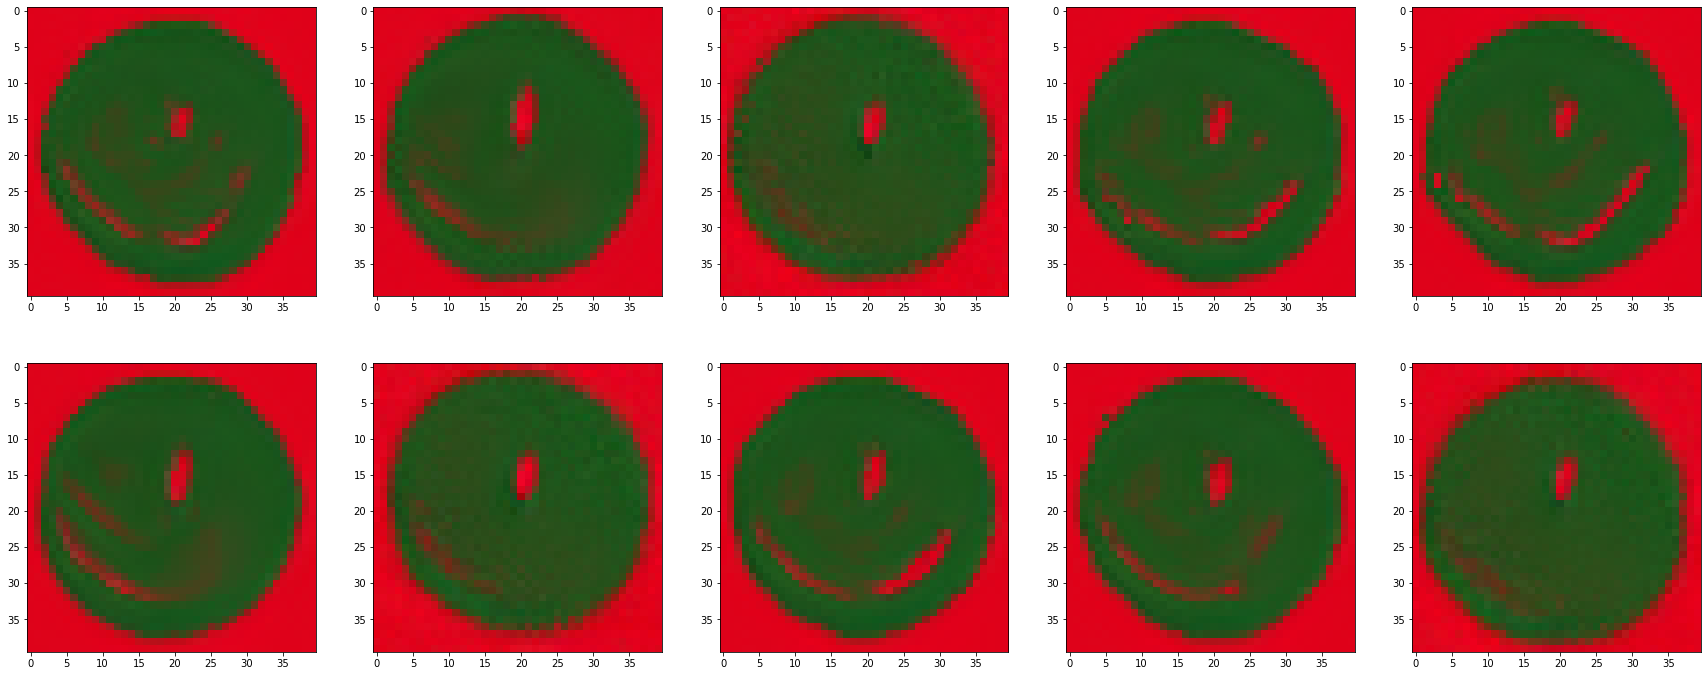

 36%|███▋      | 1450/4000 [54:30<1:29:43,  2.11s/it]

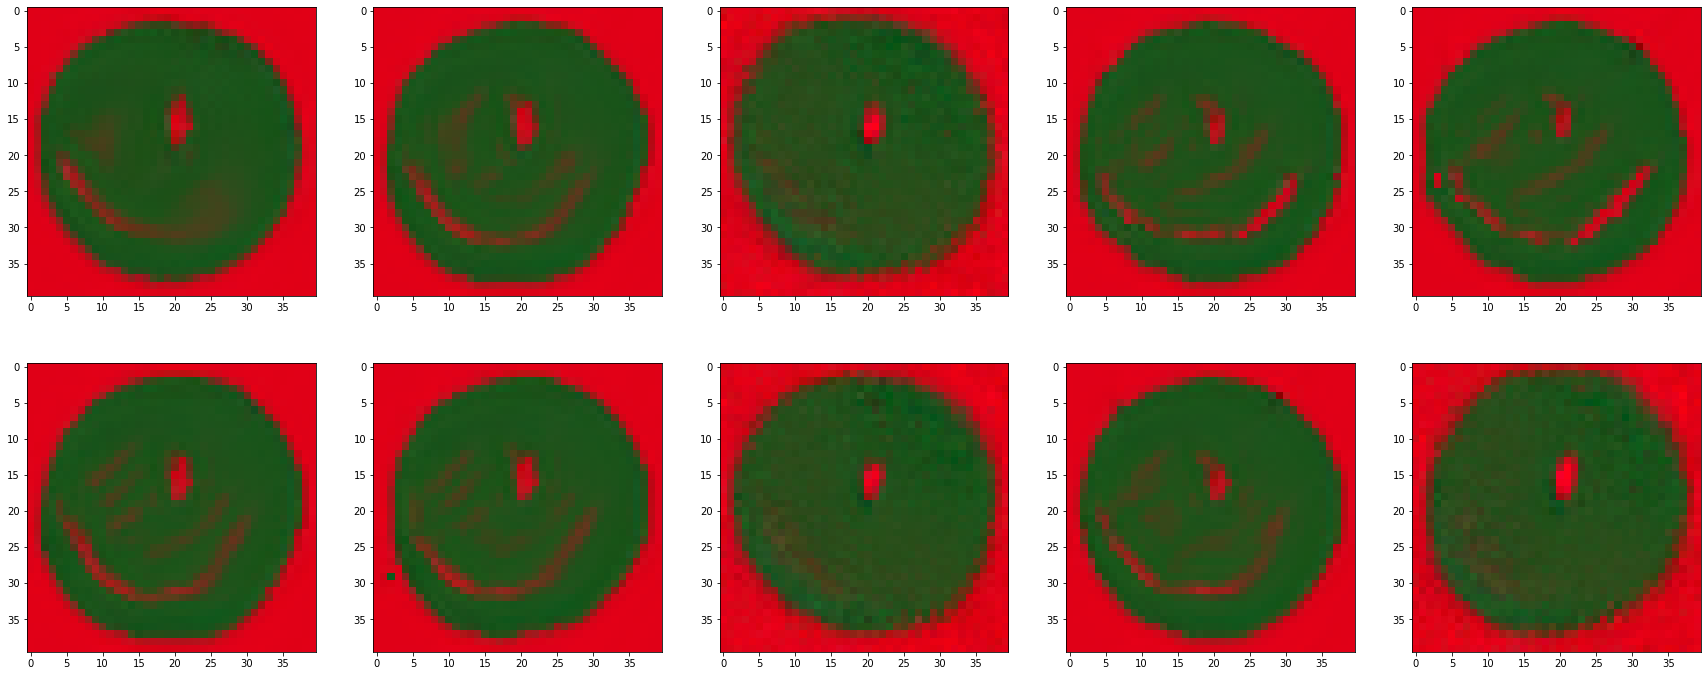

 38%|███▊      | 1500/4000 [56:19<1:31:10,  2.19s/it]

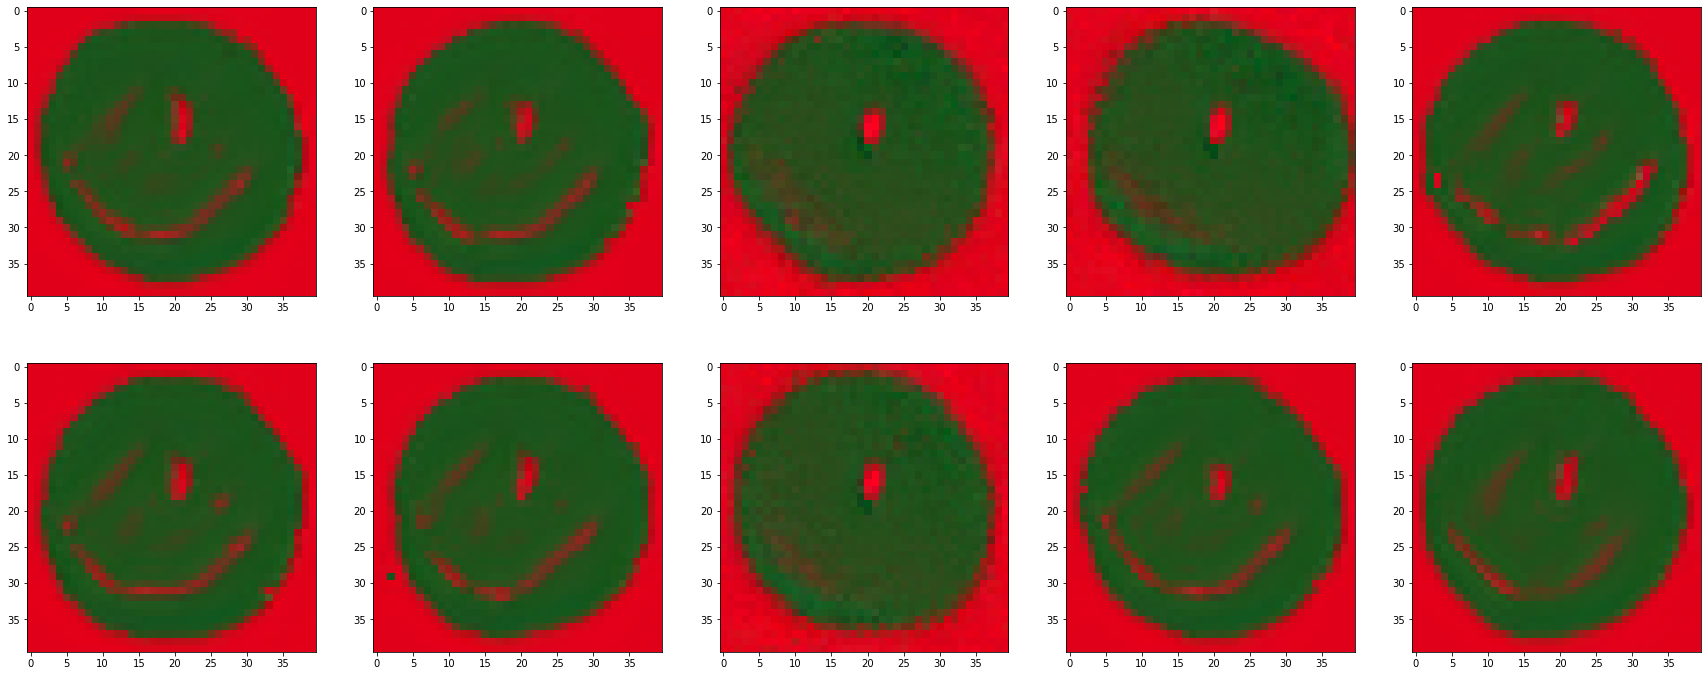

 39%|███▉      | 1550/4000 [58:09<1:27:45,  2.15s/it]

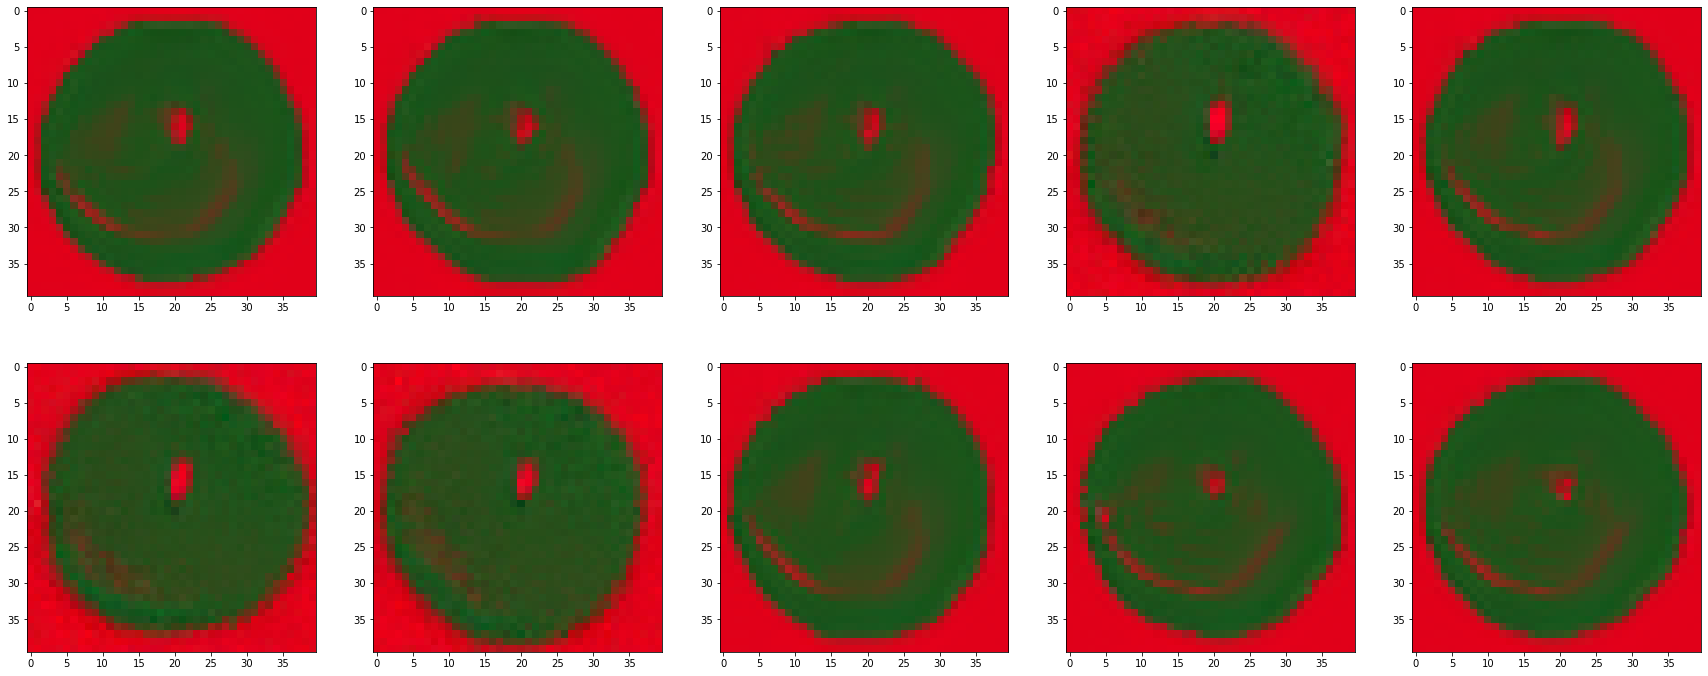

 40%|████      | 1600/4000 [59:55<1:19:33,  1.99s/it]

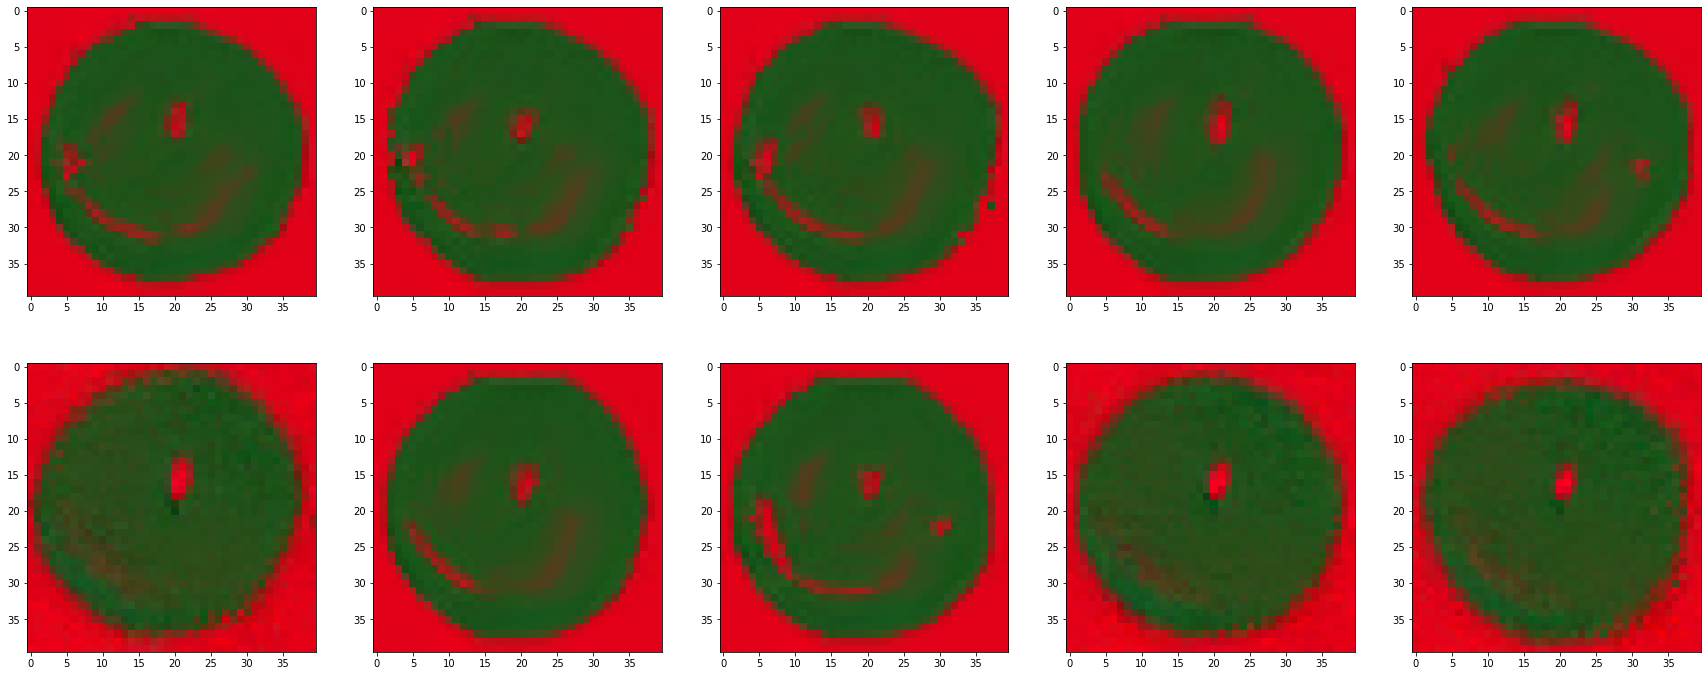

 41%|████▏     | 1650/4000 [1:01:39<1:15:53,  1.94s/it]

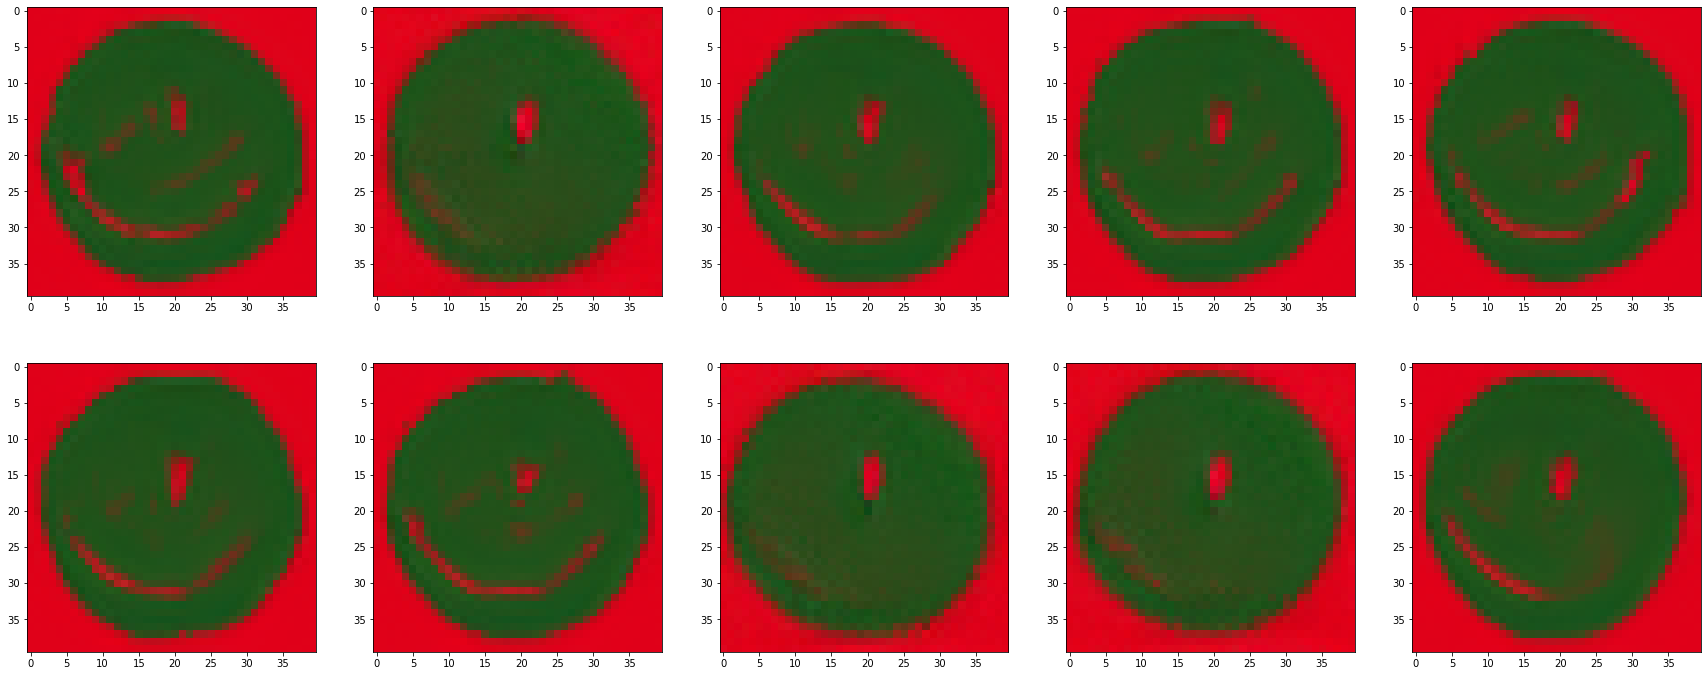

 42%|████▎     | 1700/4000 [1:03:27<1:30:02,  2.35s/it]

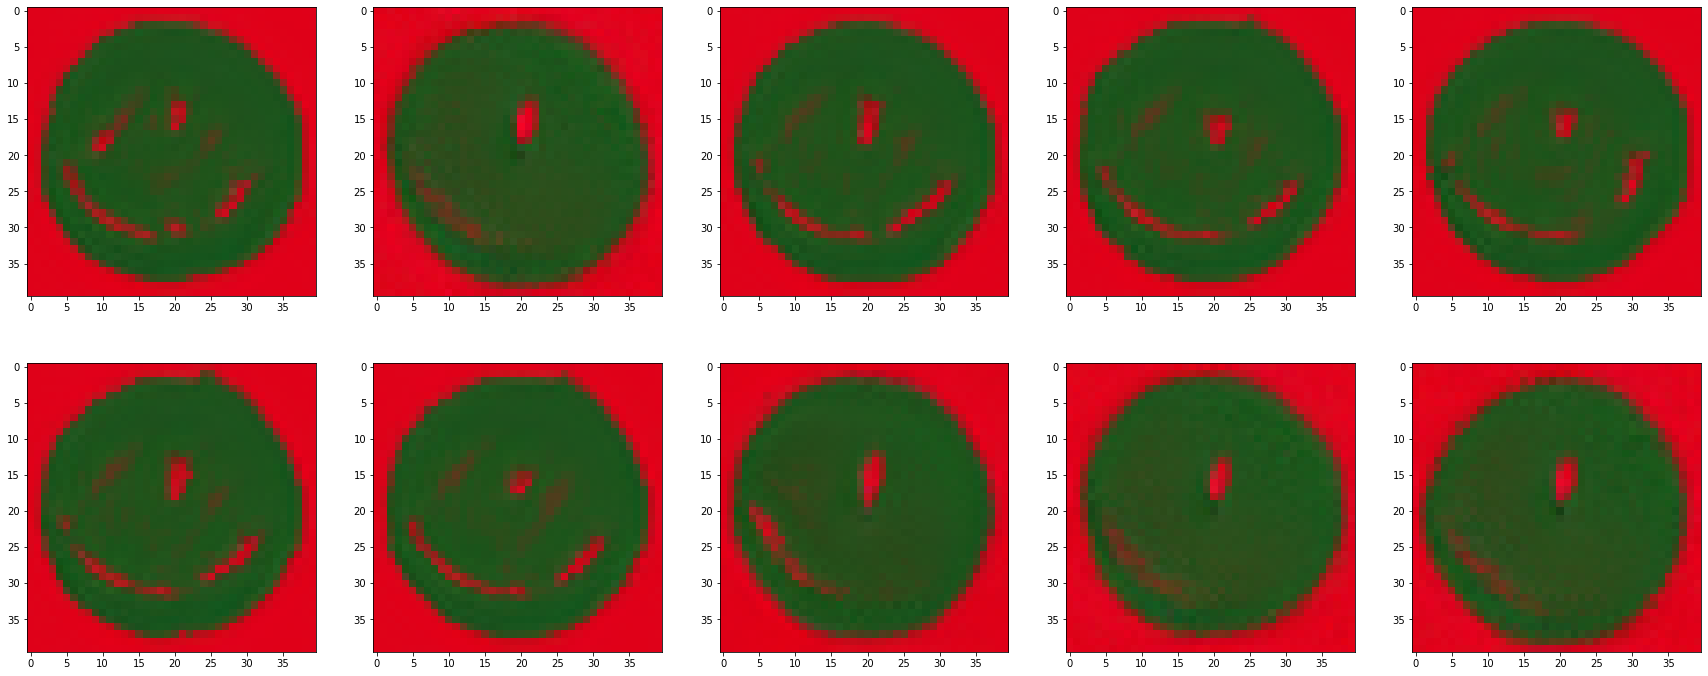

 44%|████▍     | 1750/4000 [1:05:18<1:13:40,  1.96s/it]

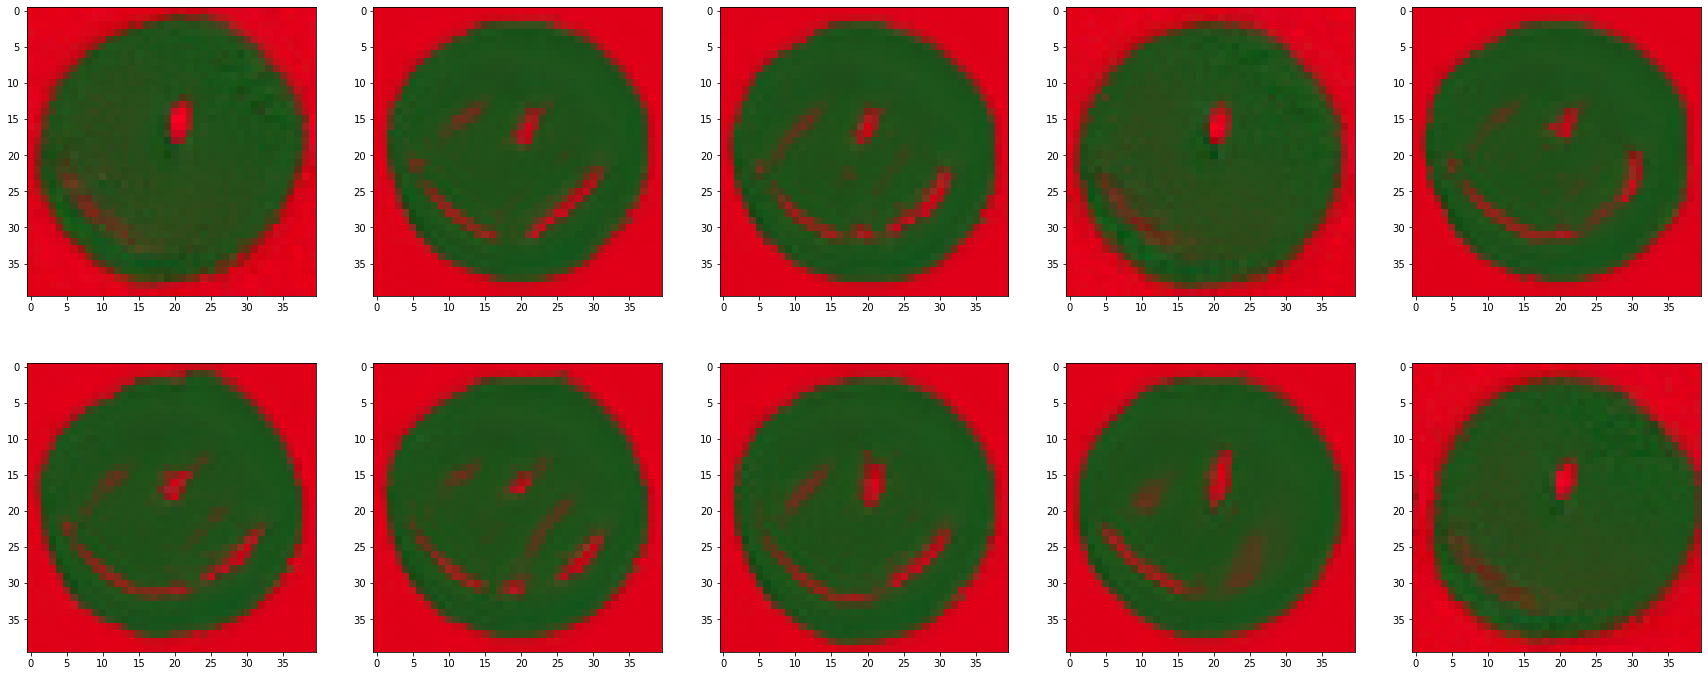

 45%|████▌     | 1800/4000 [1:07:06<1:16:00,  2.07s/it]

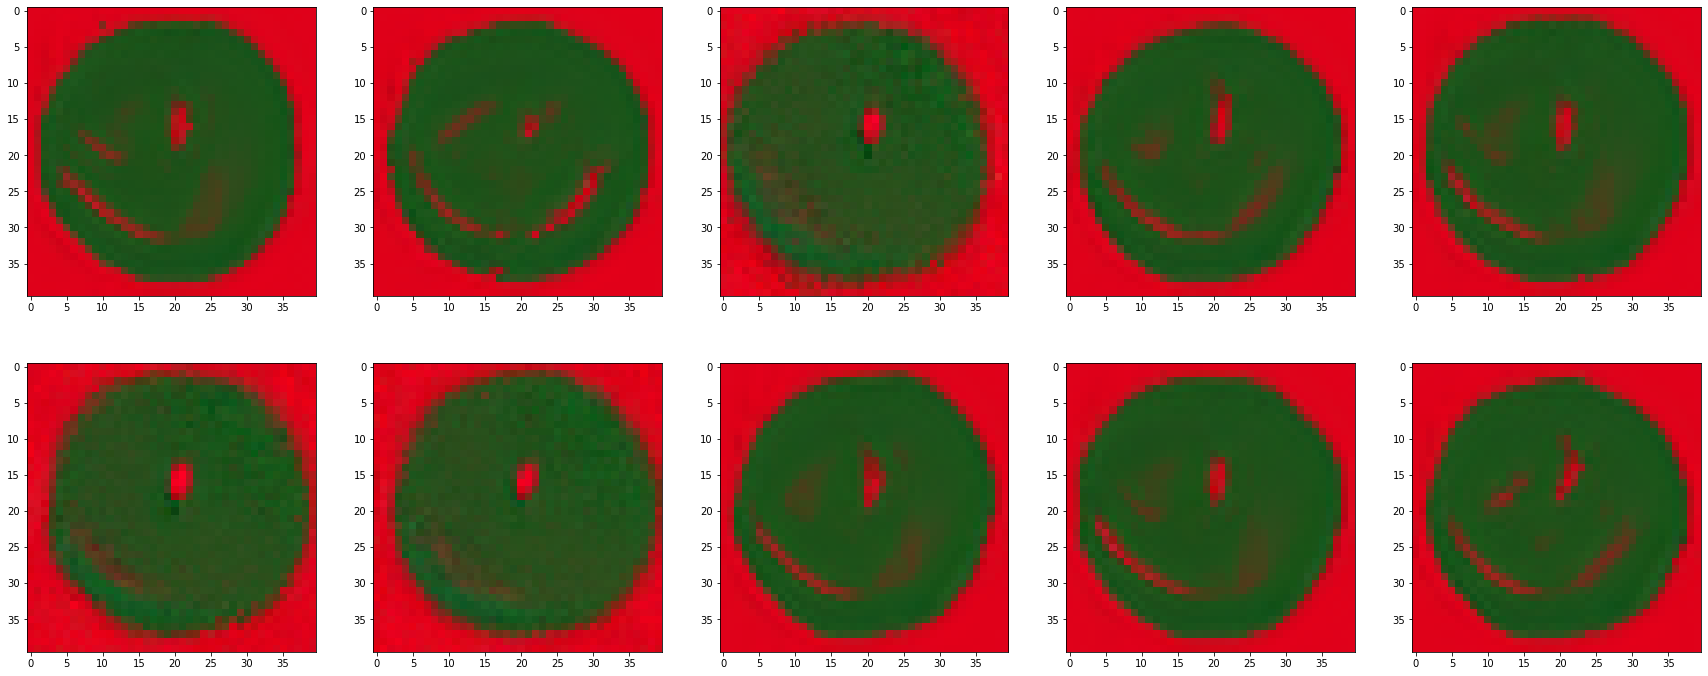

 46%|████▋     | 1850/4000 [1:08:57<1:19:32,  2.22s/it]

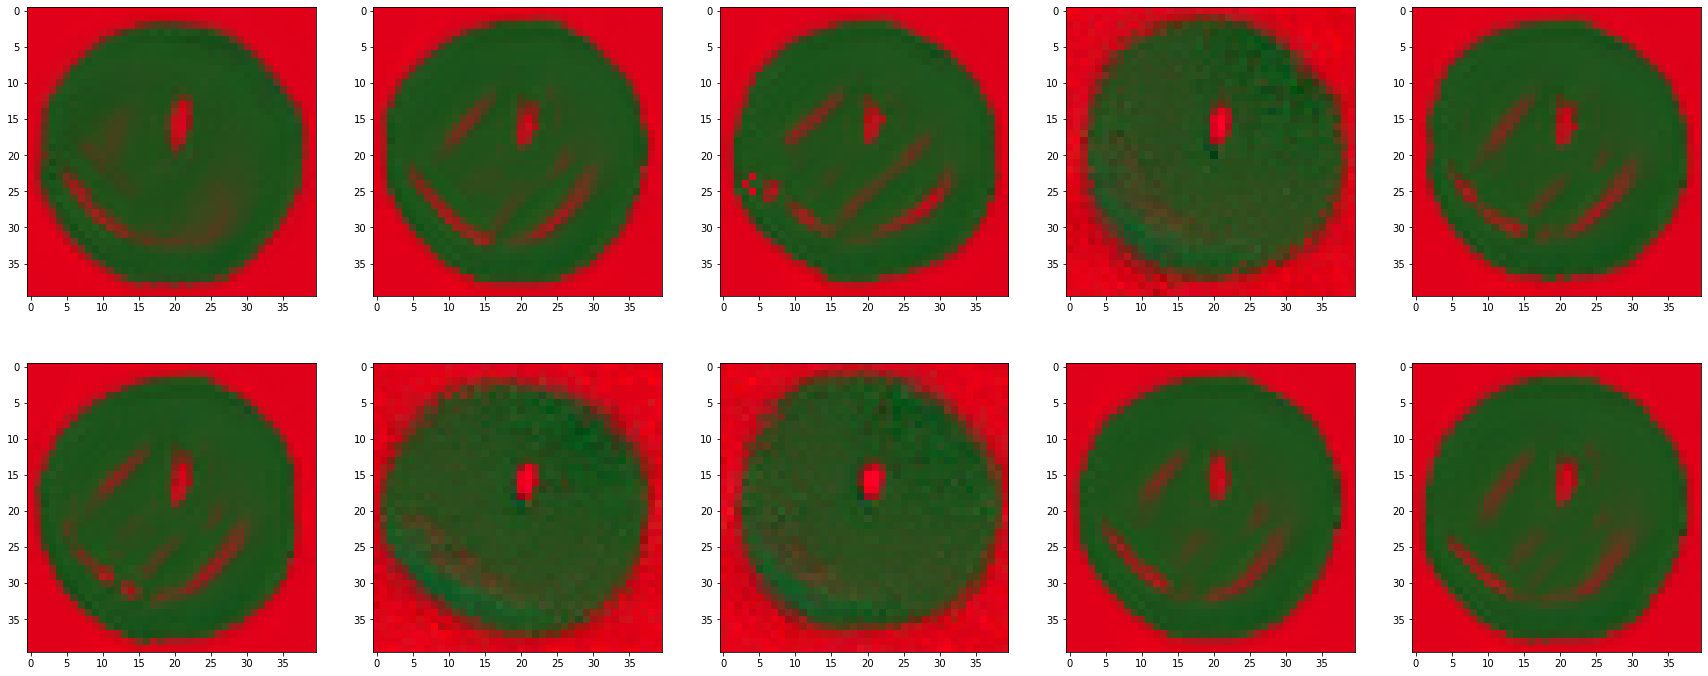

 48%|████▊     | 1900/4000 [1:10:42<1:16:18,  2.18s/it]

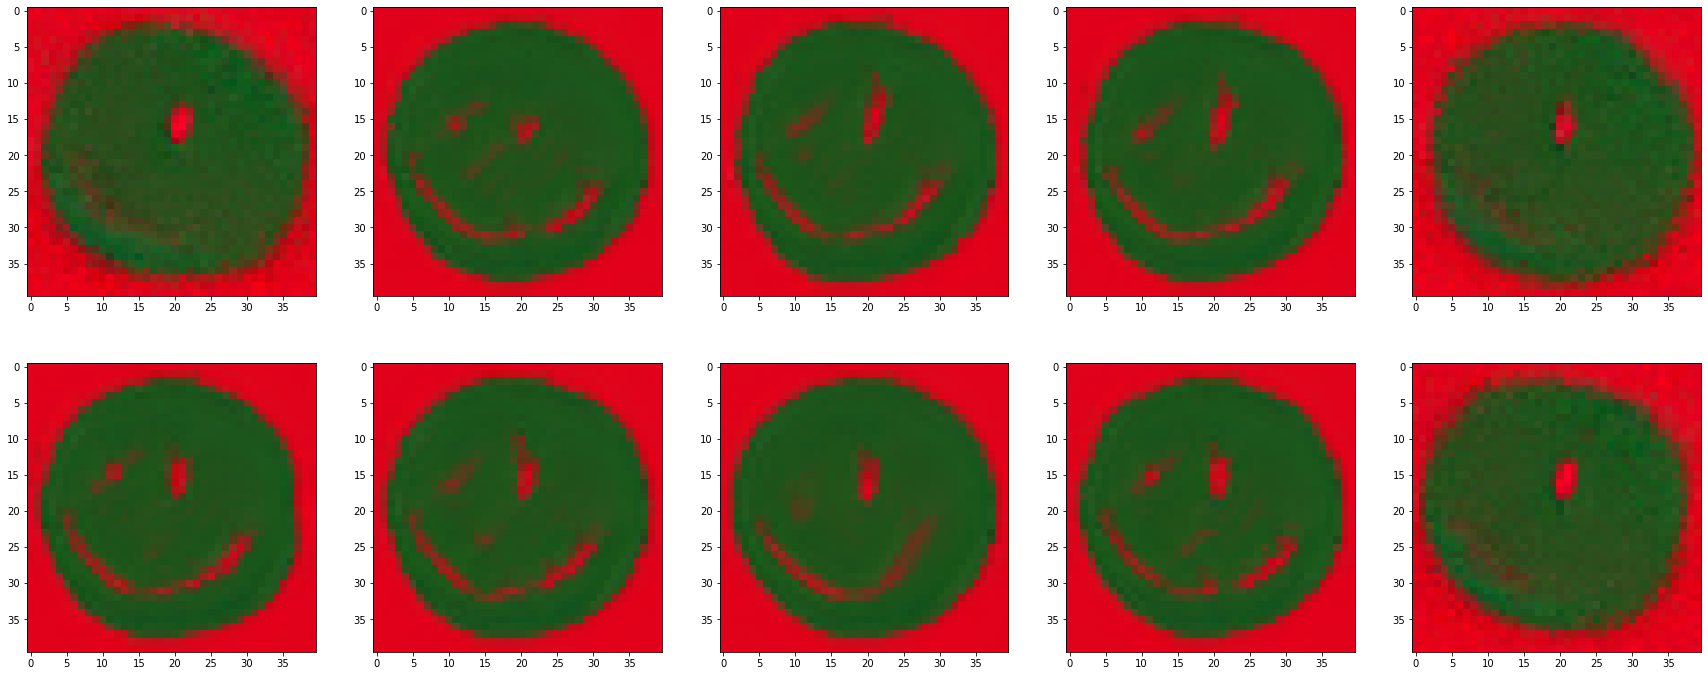

 49%|████▉     | 1950/4000 [1:12:28<1:13:10,  2.14s/it]

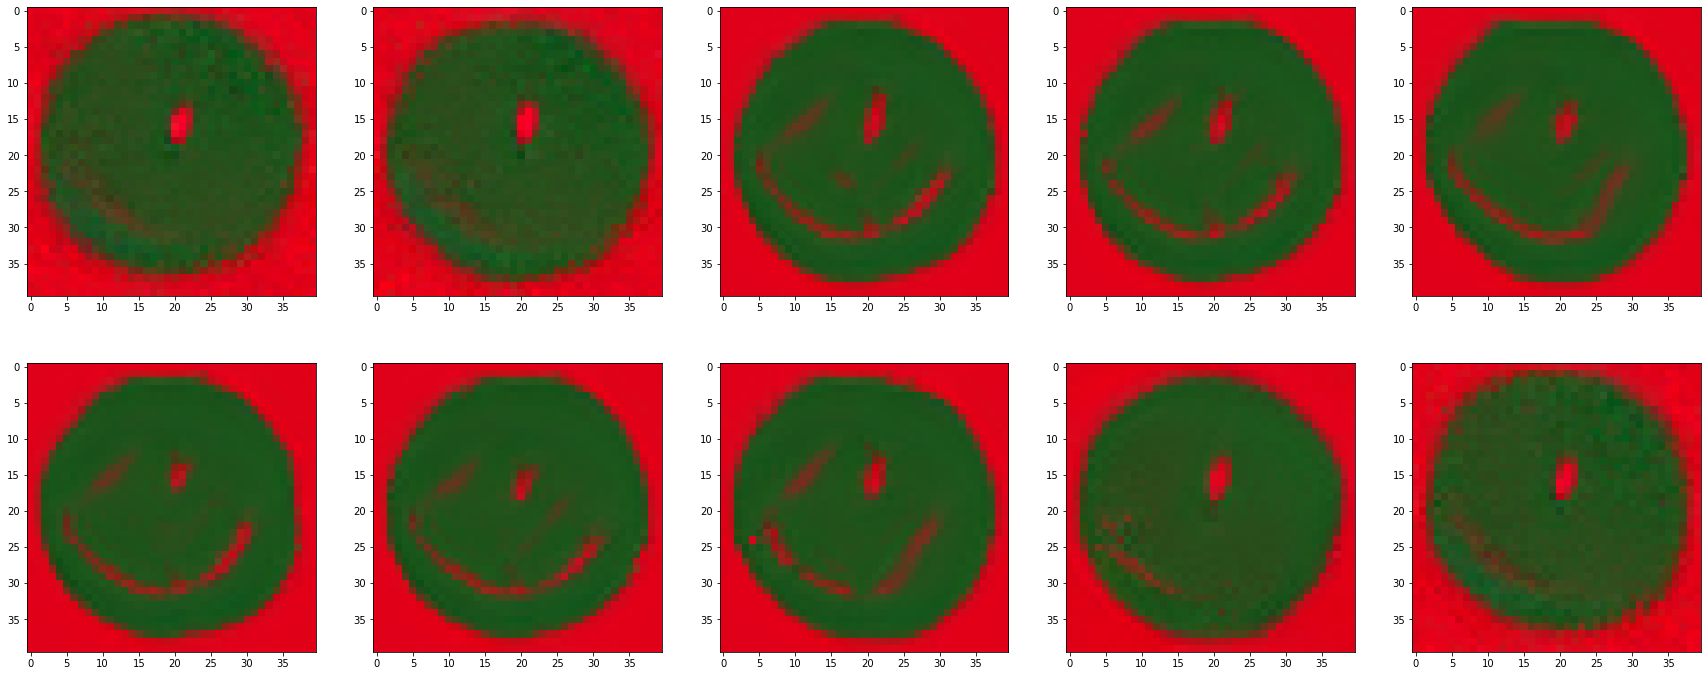

 50%|█████     | 2000/4000 [1:14:18<1:12:58,  2.19s/it]

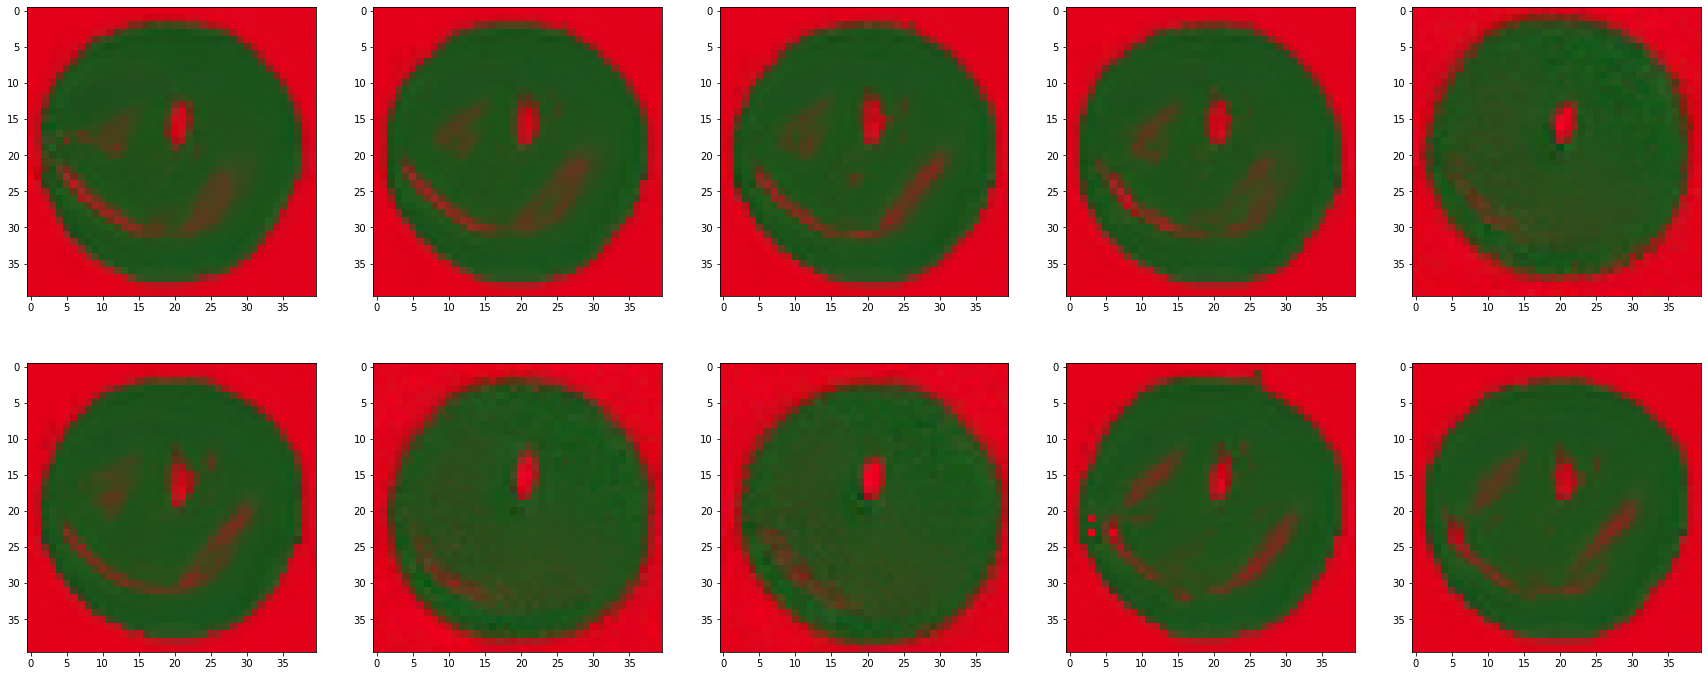

 51%|█████▏    | 2050/4000 [1:16:11<1:12:37,  2.23s/it]

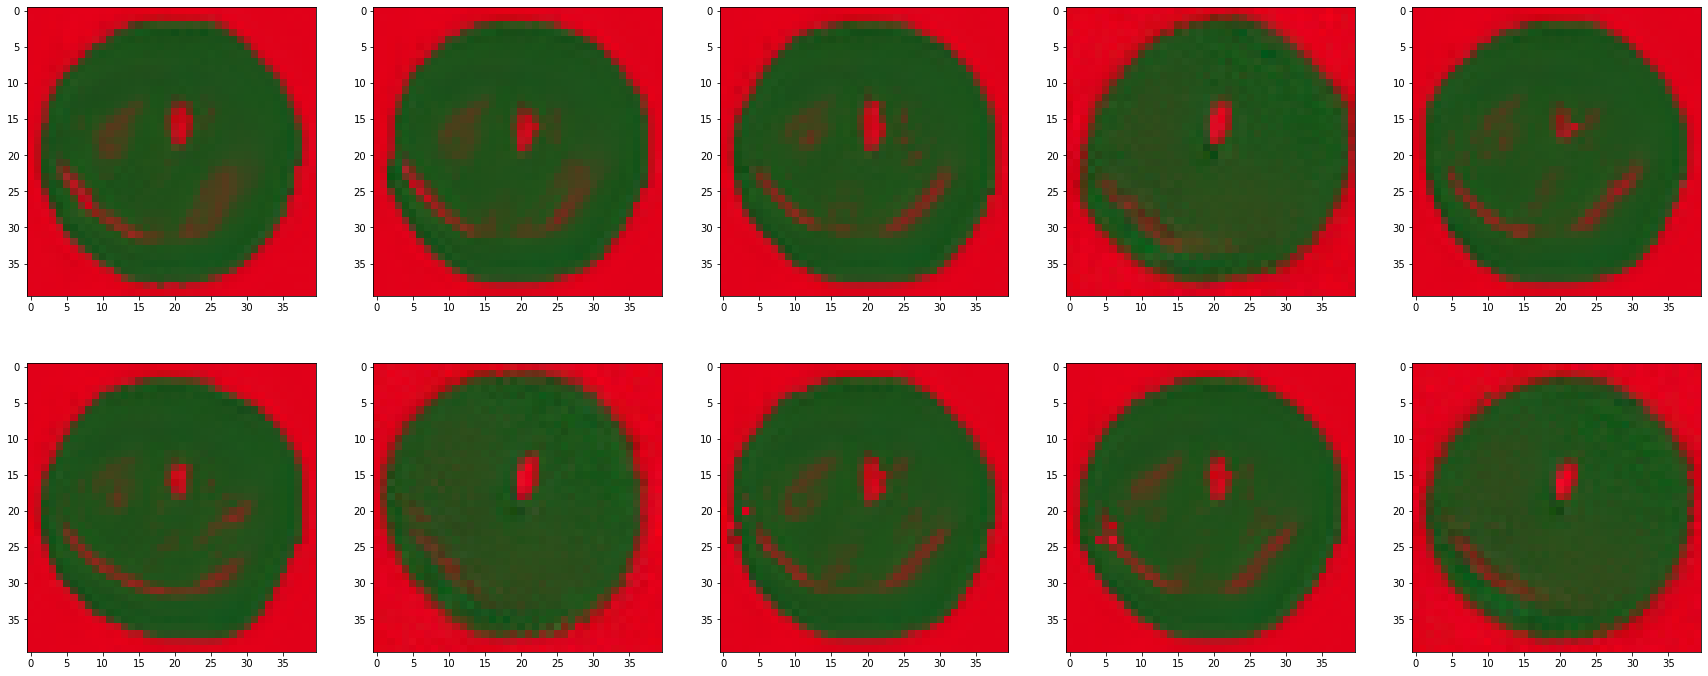

 52%|█████▎    | 2100/4000 [1:18:03<1:04:45,  2.05s/it]

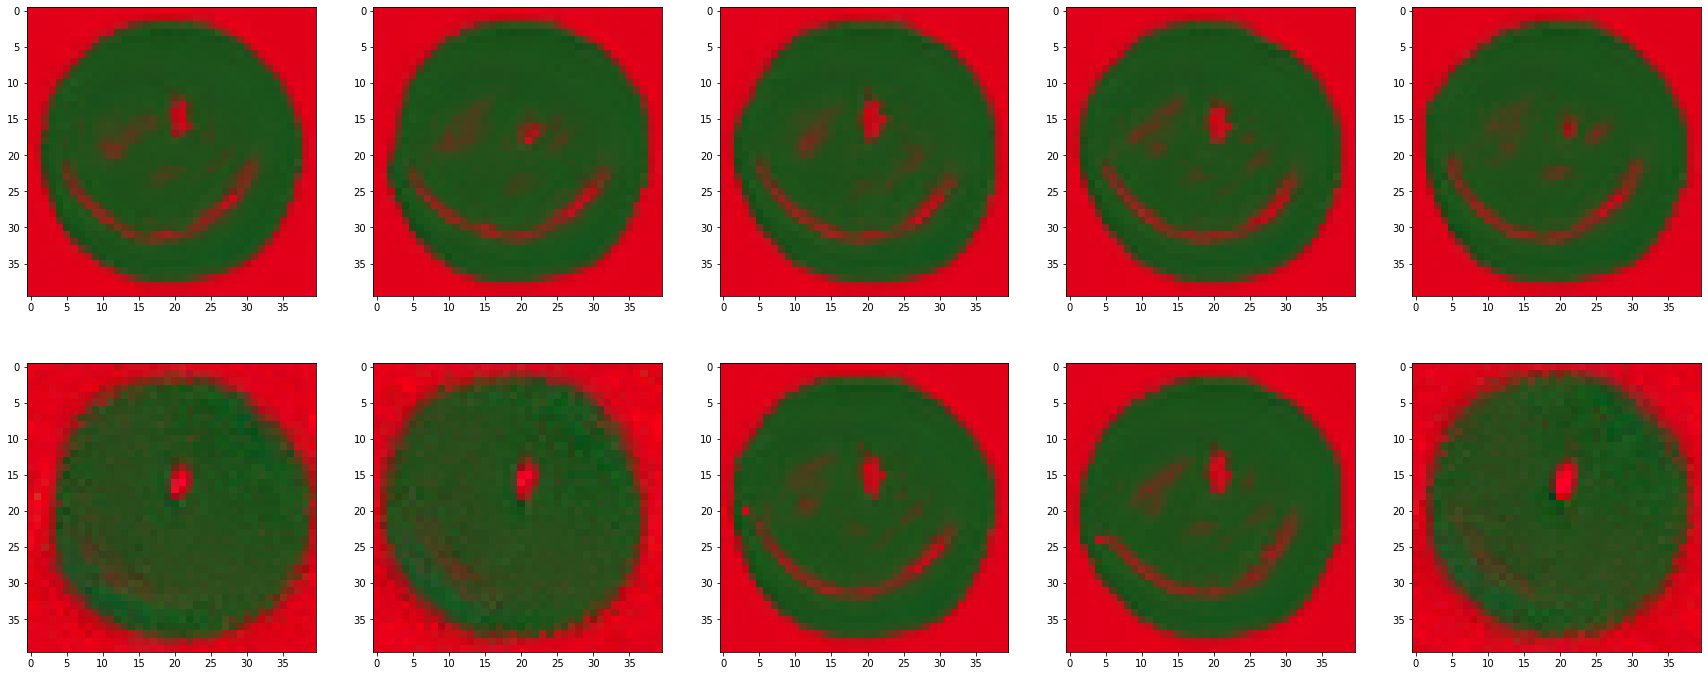

 54%|█████▍    | 2150/4000 [1:19:56<1:08:47,  2.23s/it]

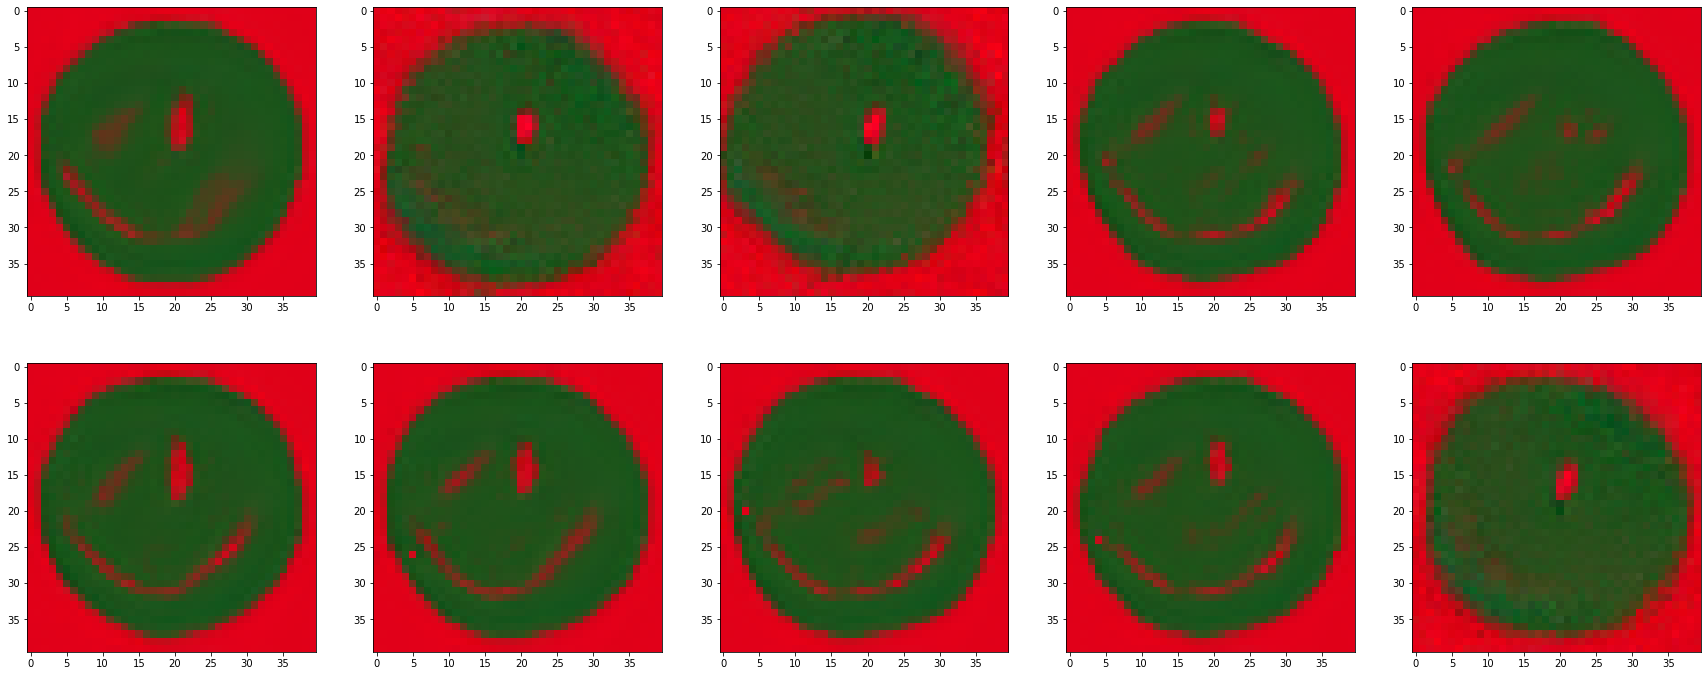

 55%|█████▌    | 2200/4000 [1:21:52<1:08:53,  2.30s/it]

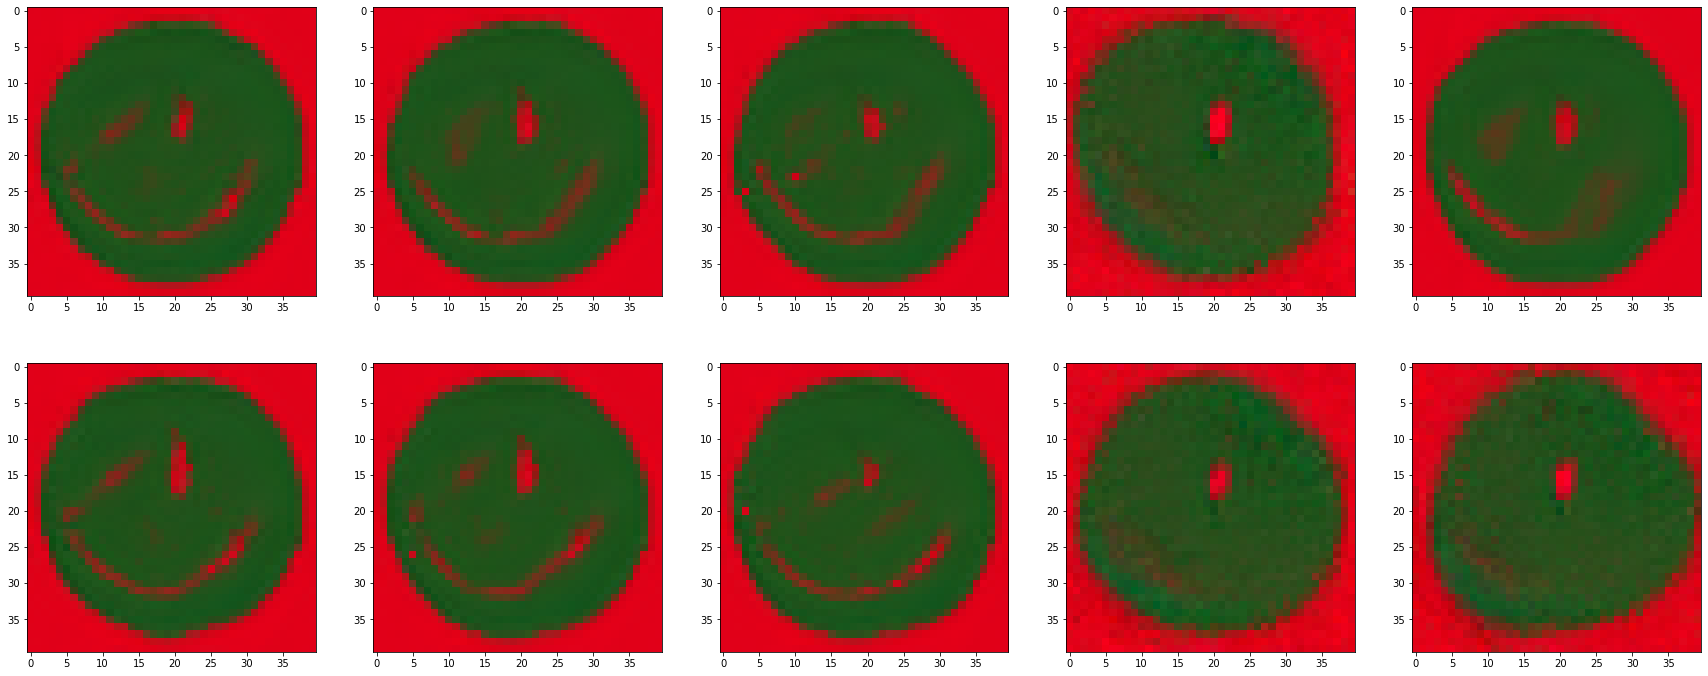

 56%|█████▋    | 2250/4000 [1:23:50<1:07:29,  2.31s/it]

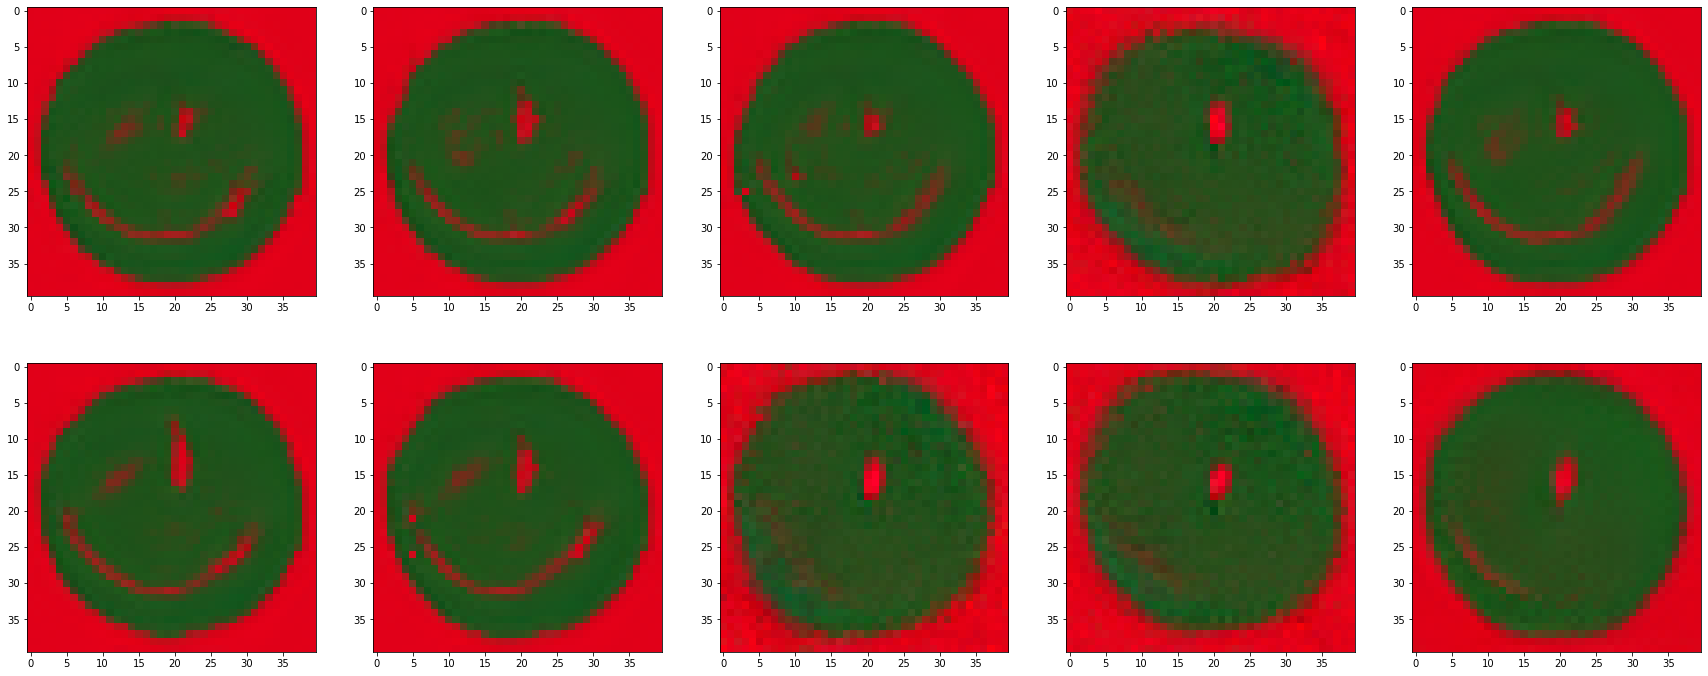

 57%|█████▊    | 2300/4000 [1:25:42<1:03:59,  2.26s/it]

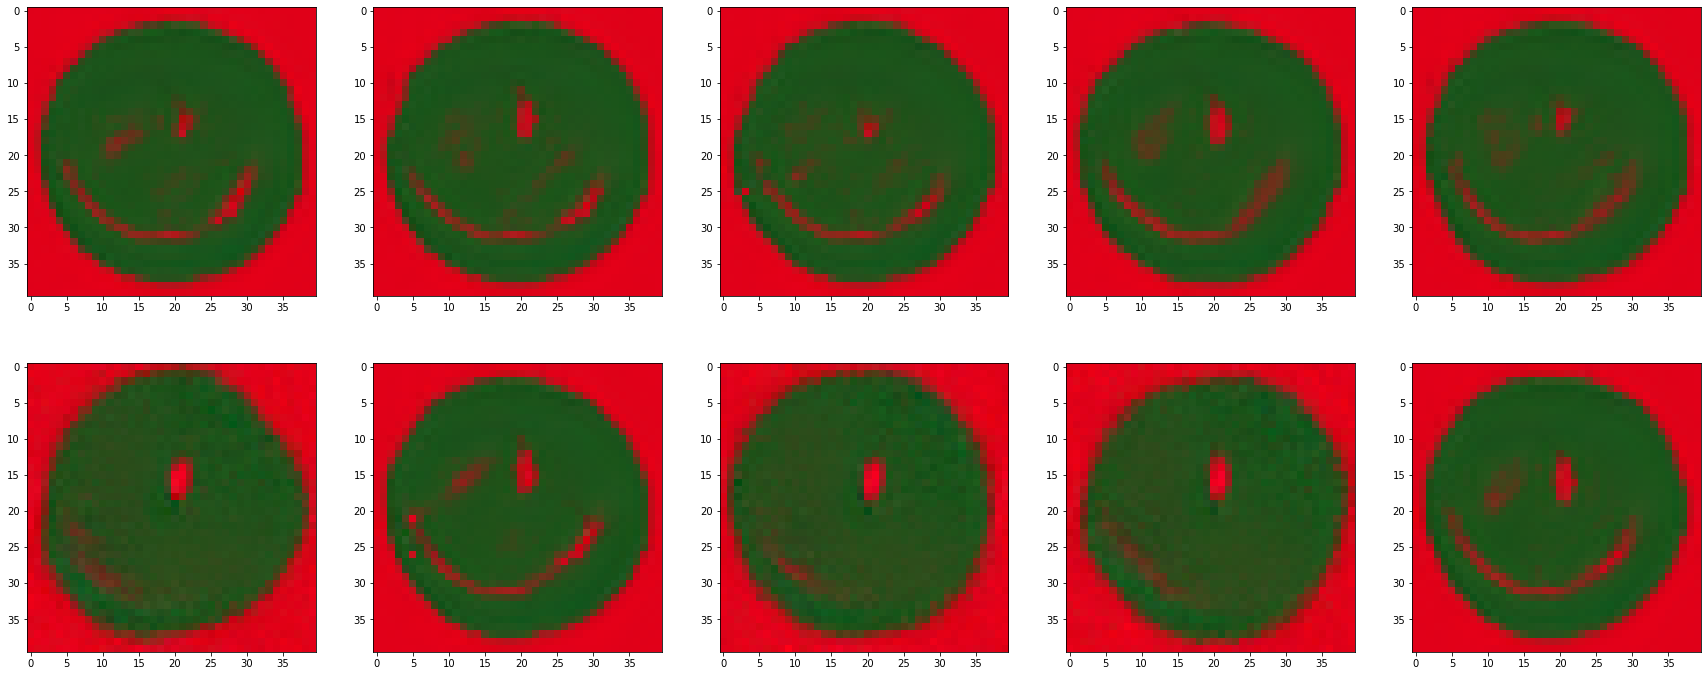

 59%|█████▉    | 2350/4000 [1:27:40<1:02:07,  2.26s/it]

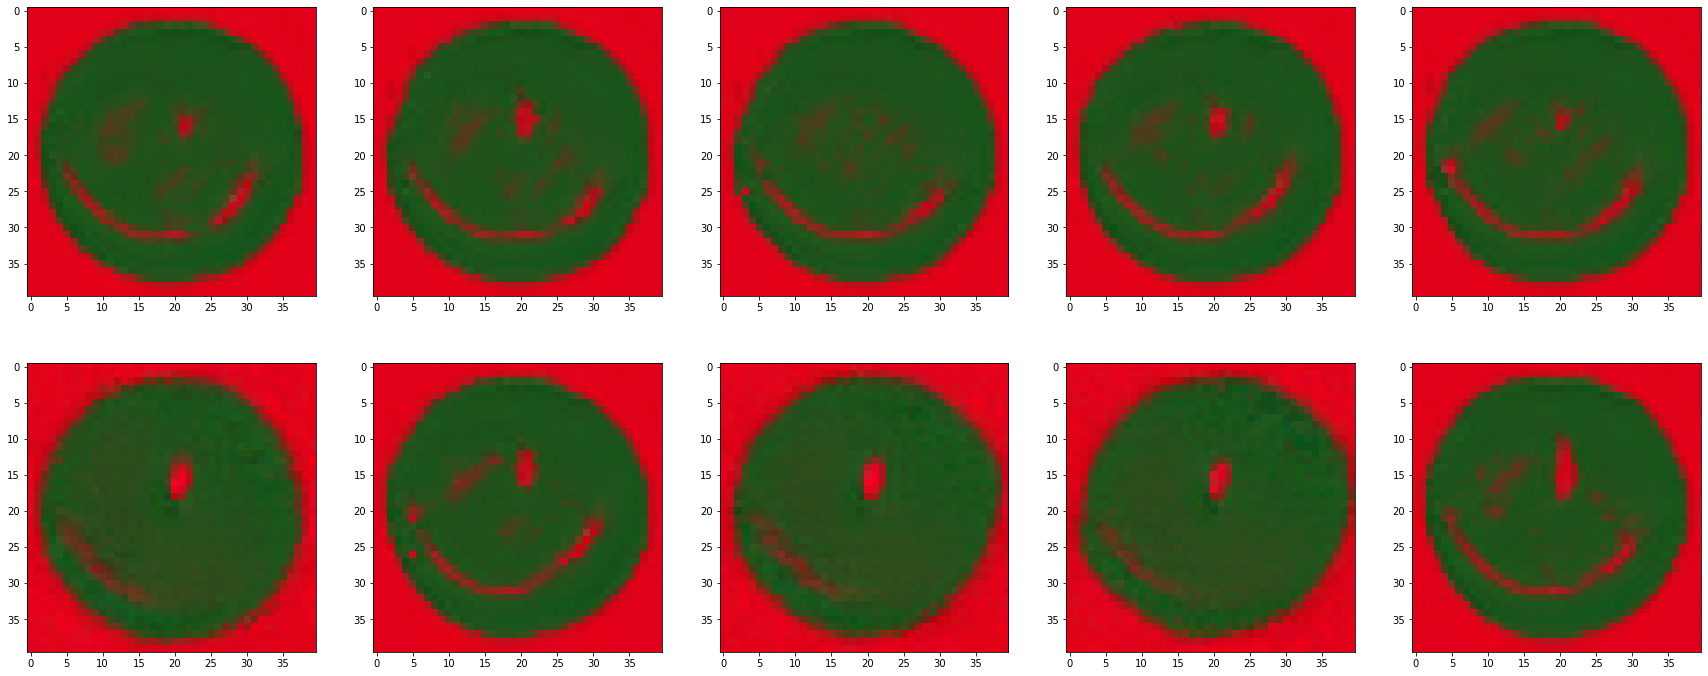

 60%|██████    | 2400/4000 [1:29:35<1:01:34,  2.31s/it]

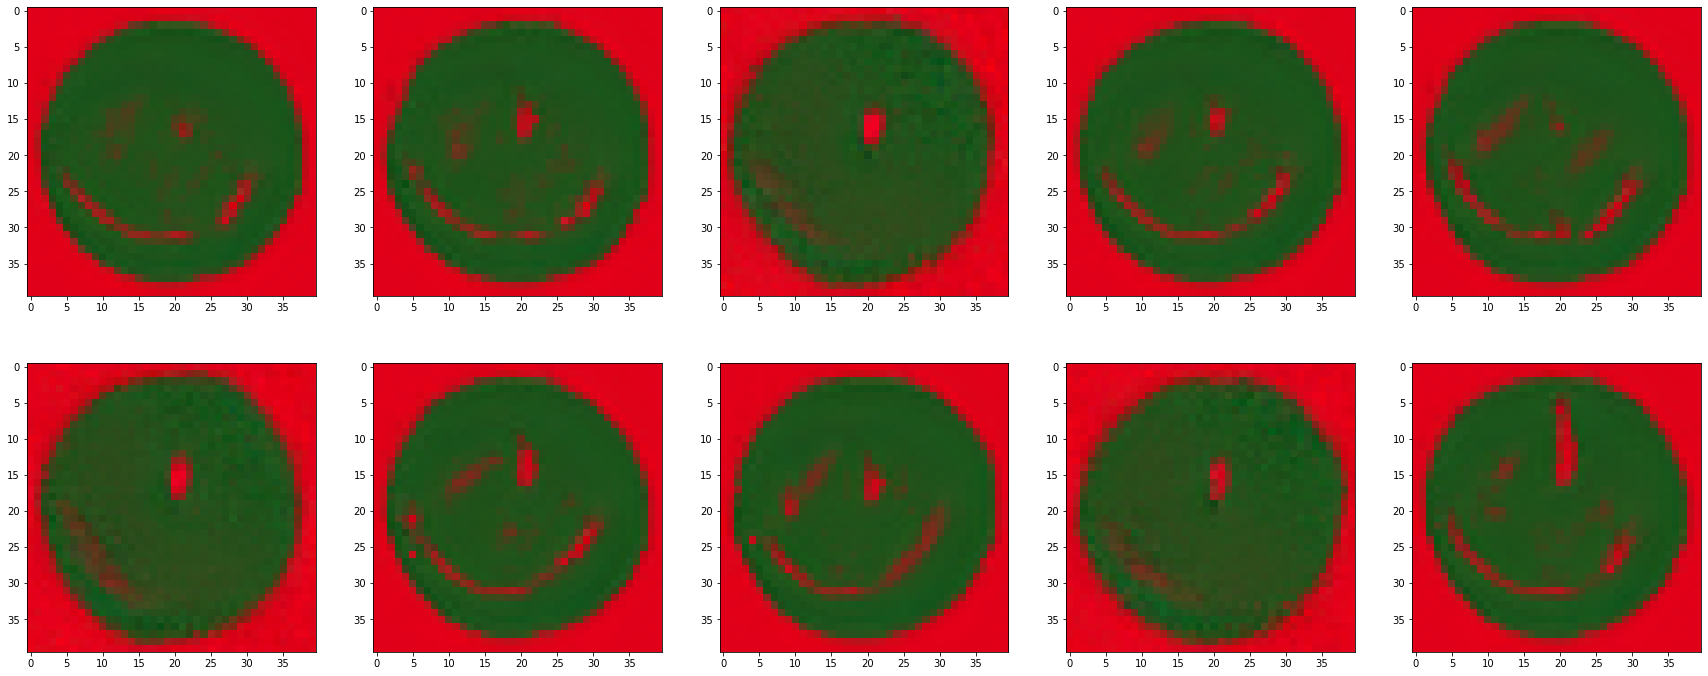

 61%|██████▏   | 2450/4000 [1:31:35<53:19,  2.06s/it]  

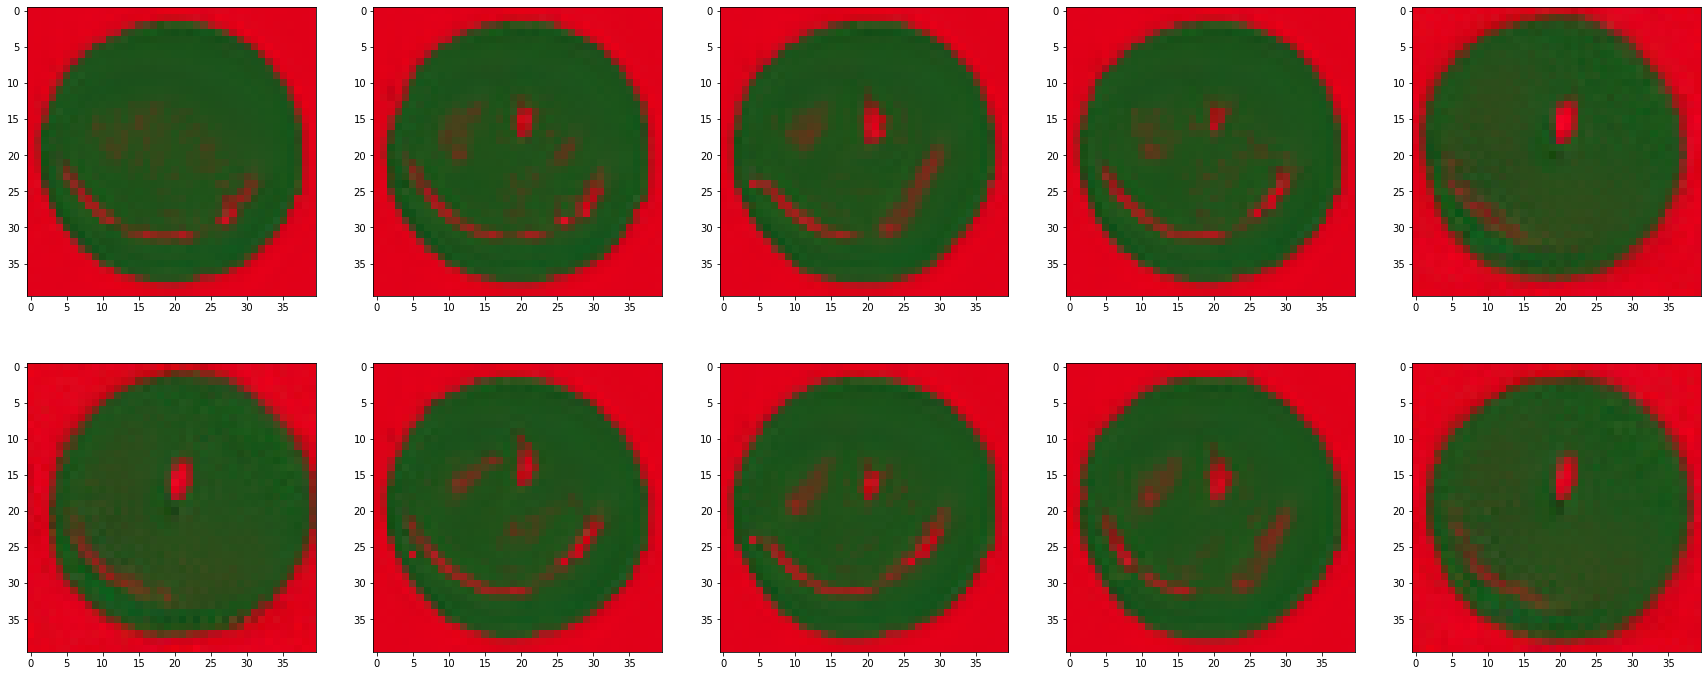

 62%|██████▎   | 2500/4000 [1:33:34<58:49,  2.35s/it]  

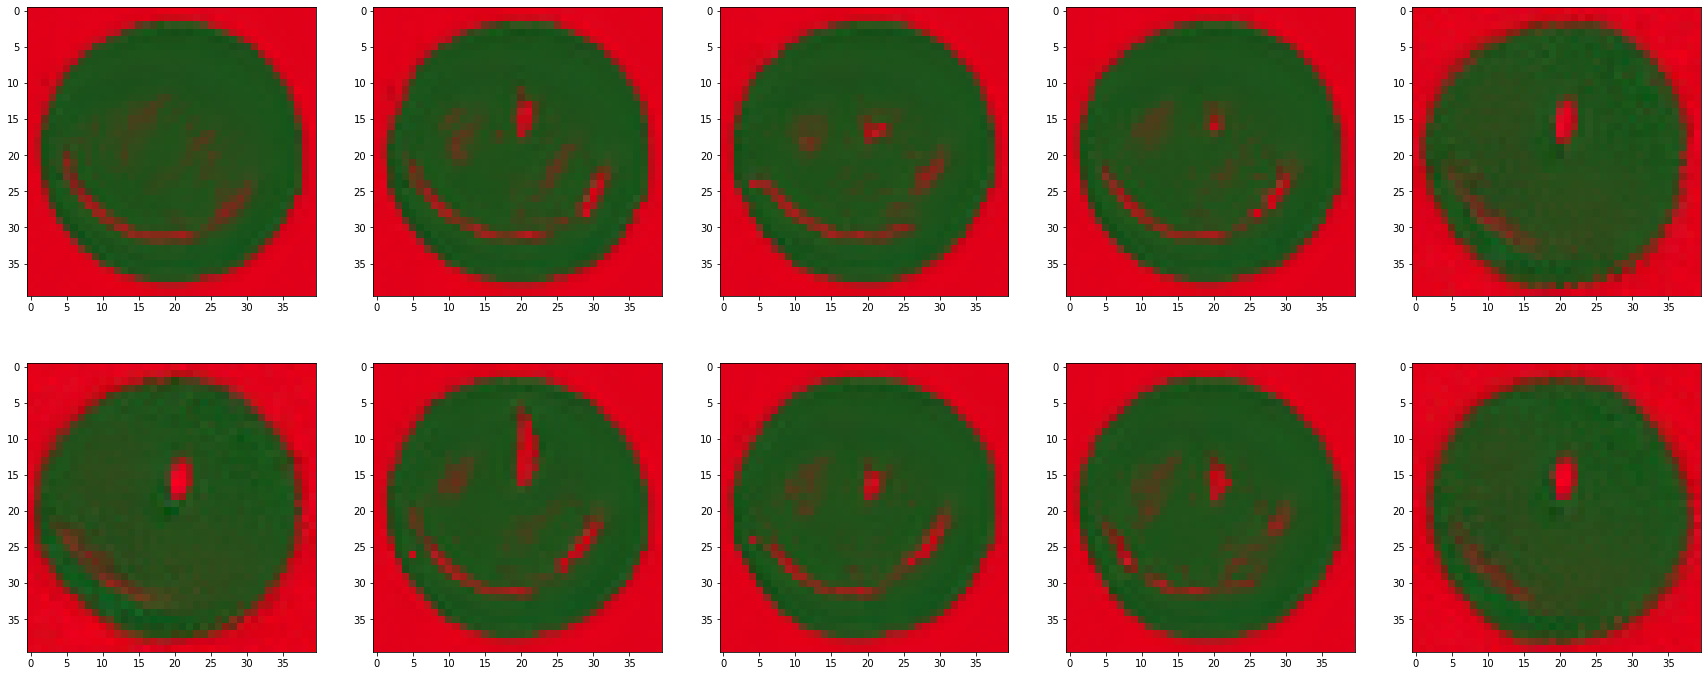

 64%|██████▍   | 2550/4000 [1:35:30<53:28,  2.21s/it]  

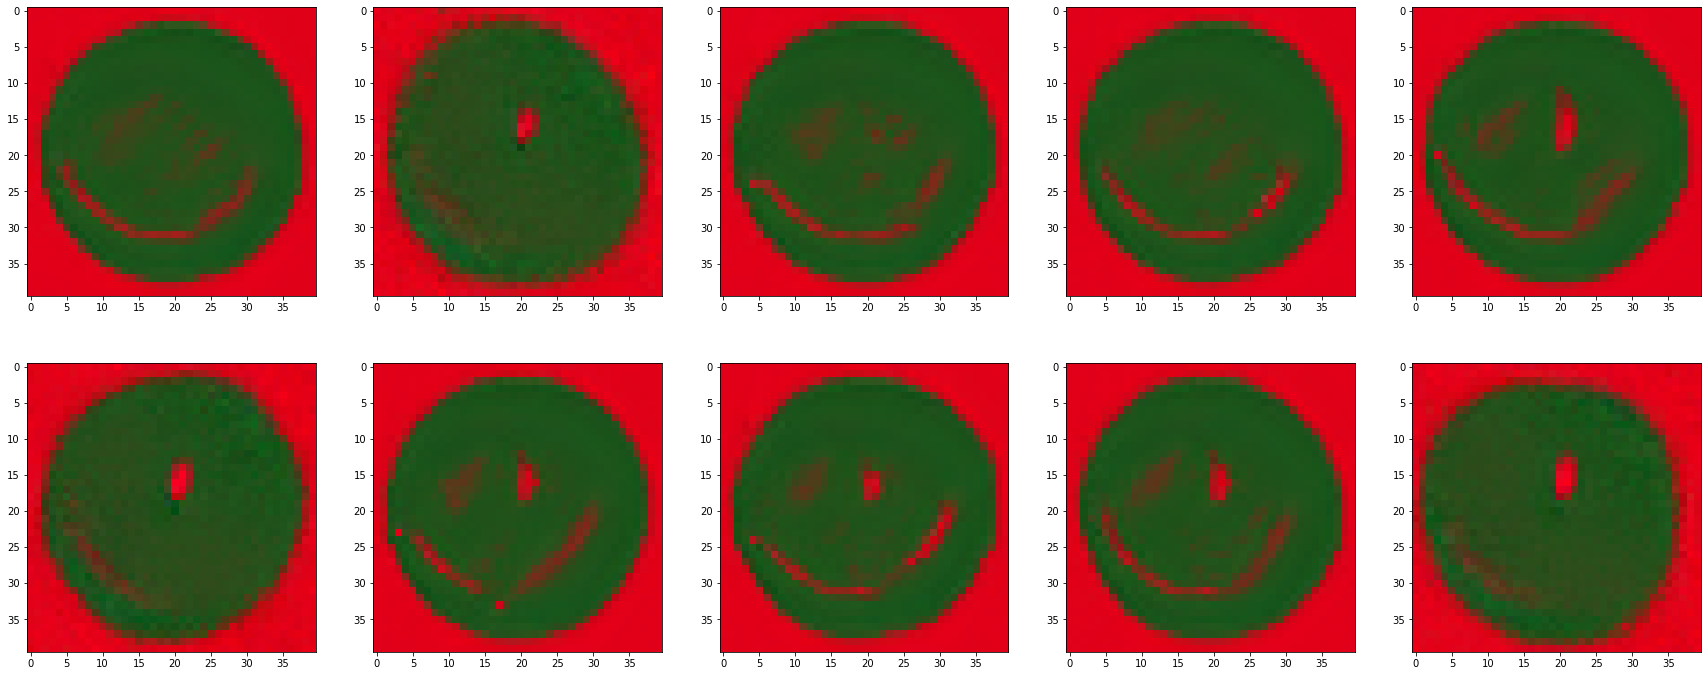

 65%|██████▌   | 2600/4000 [1:37:27<56:06,  2.40s/it]  

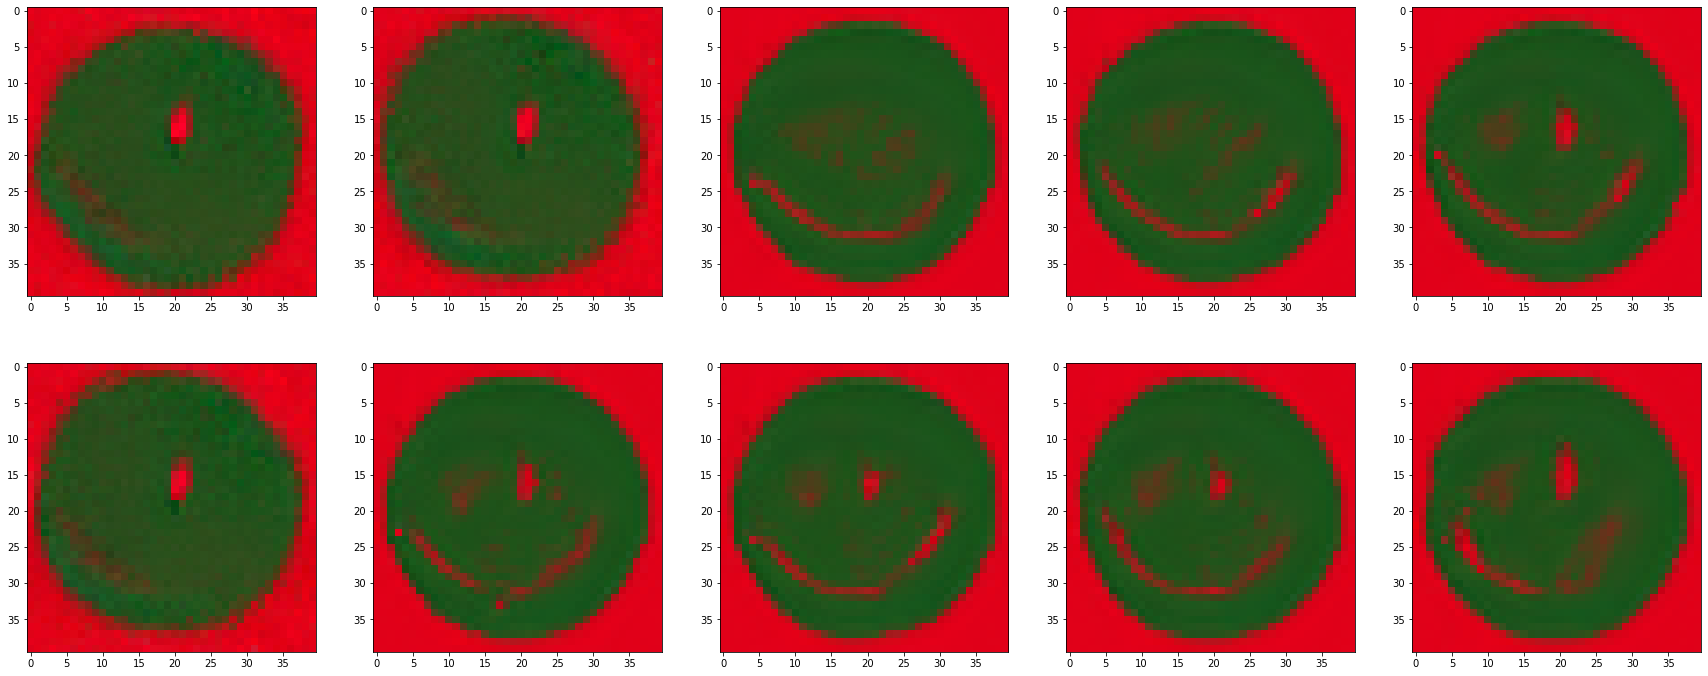

 66%|██████▋   | 2650/4000 [1:39:25<51:25,  2.29s/it]  

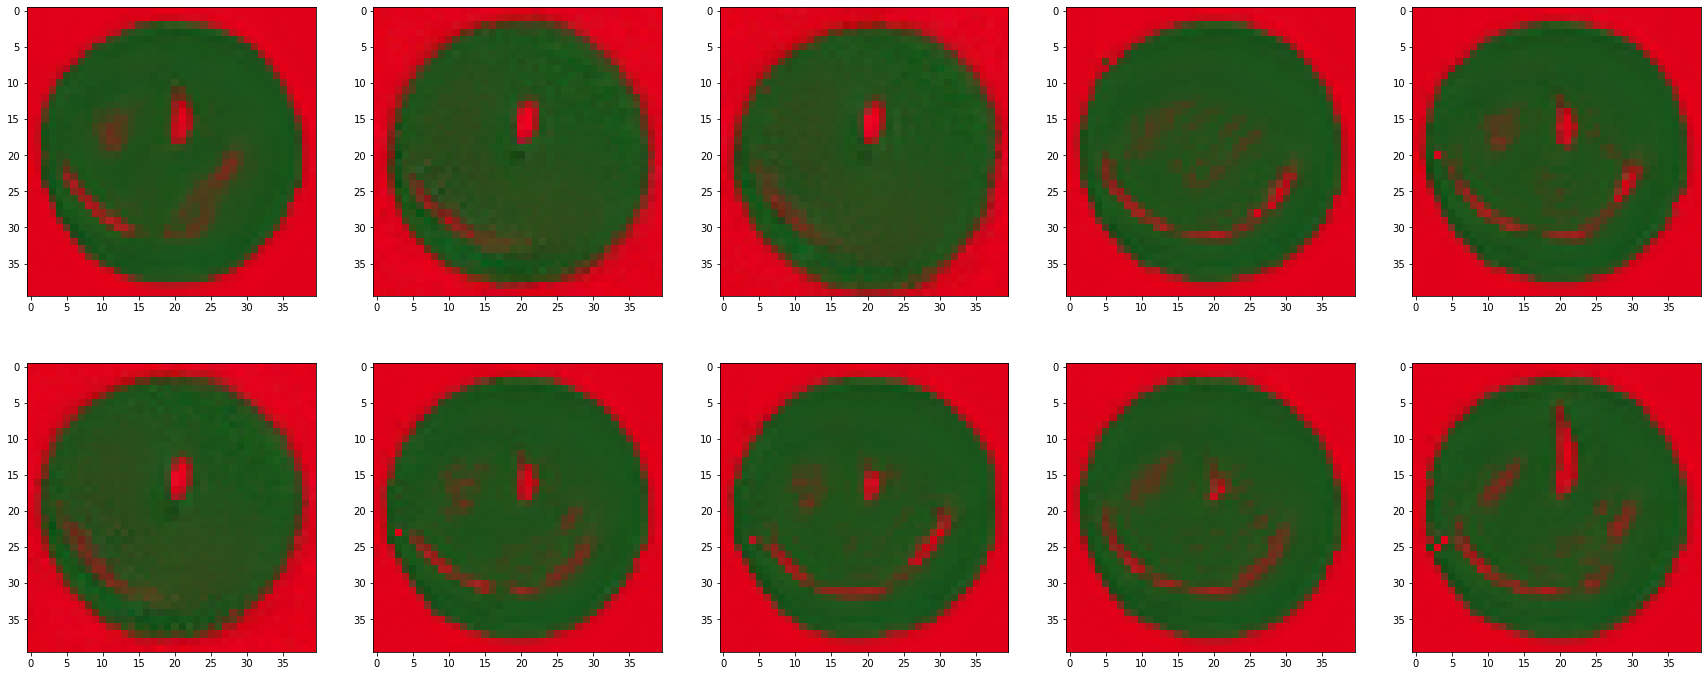

 68%|██████▊   | 2700/4000 [1:41:24<54:35,  2.52s/it]  

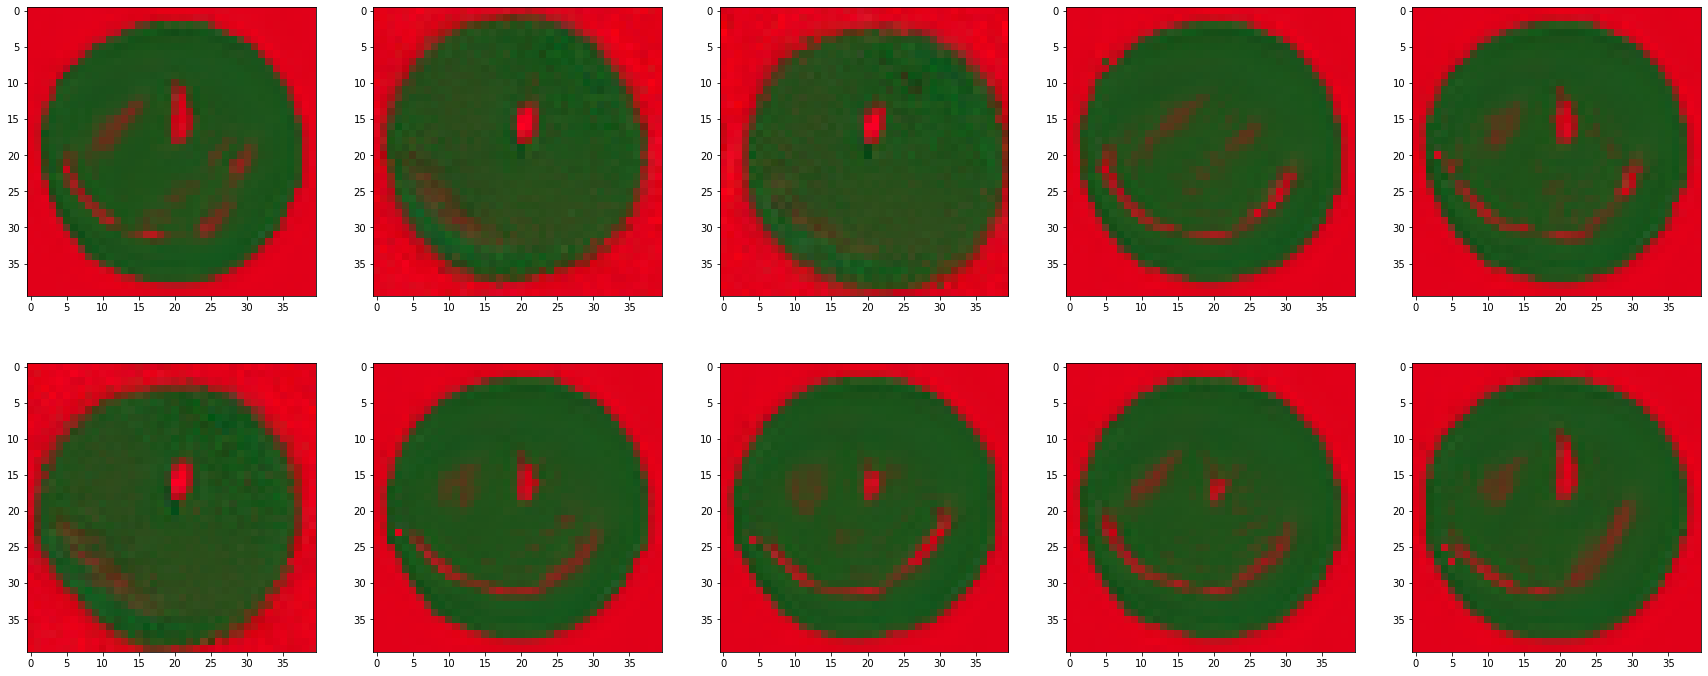

 69%|██████▉   | 2750/4000 [1:43:28<53:28,  2.57s/it]  

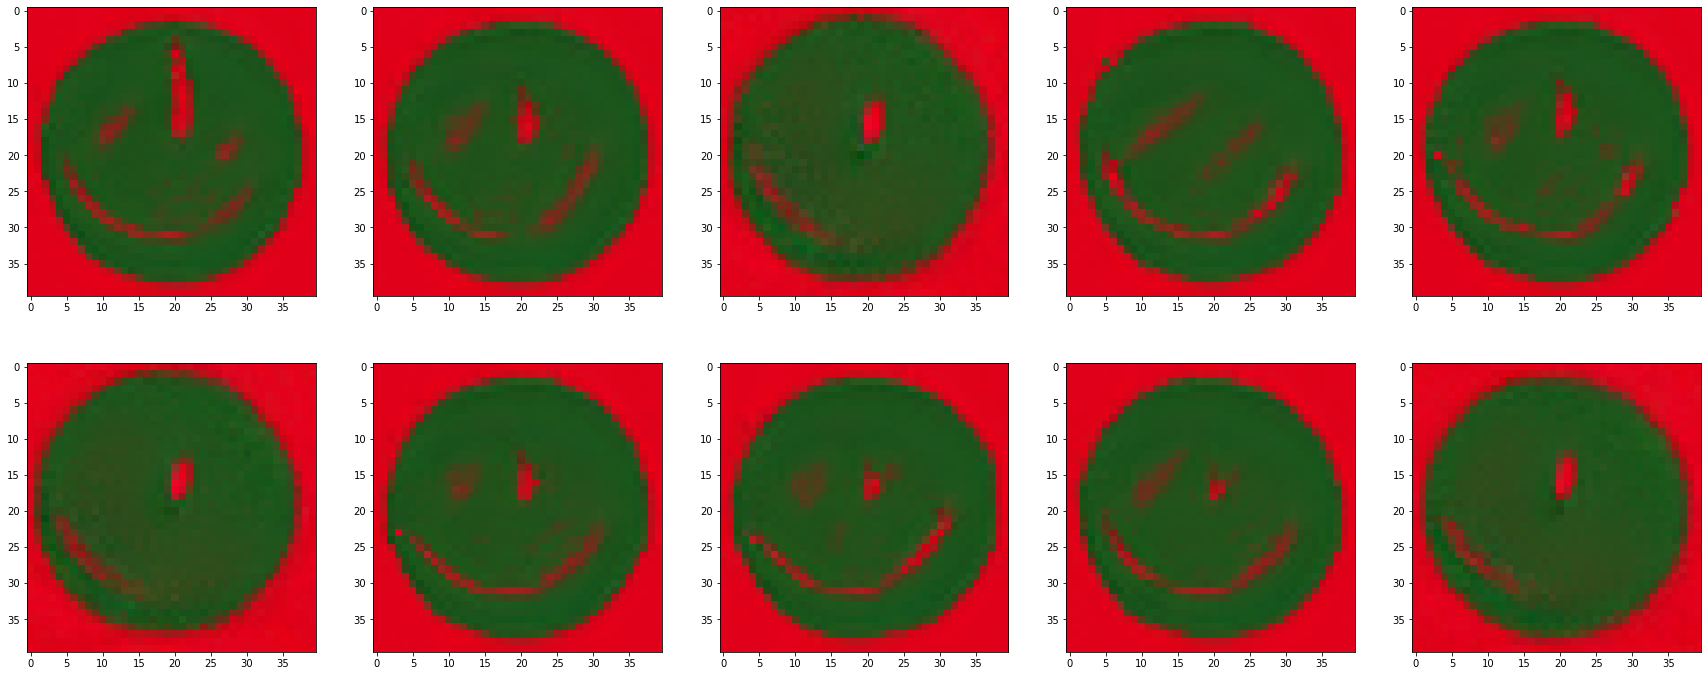

 70%|███████   | 2800/4000 [1:45:28<48:51,  2.44s/it]  

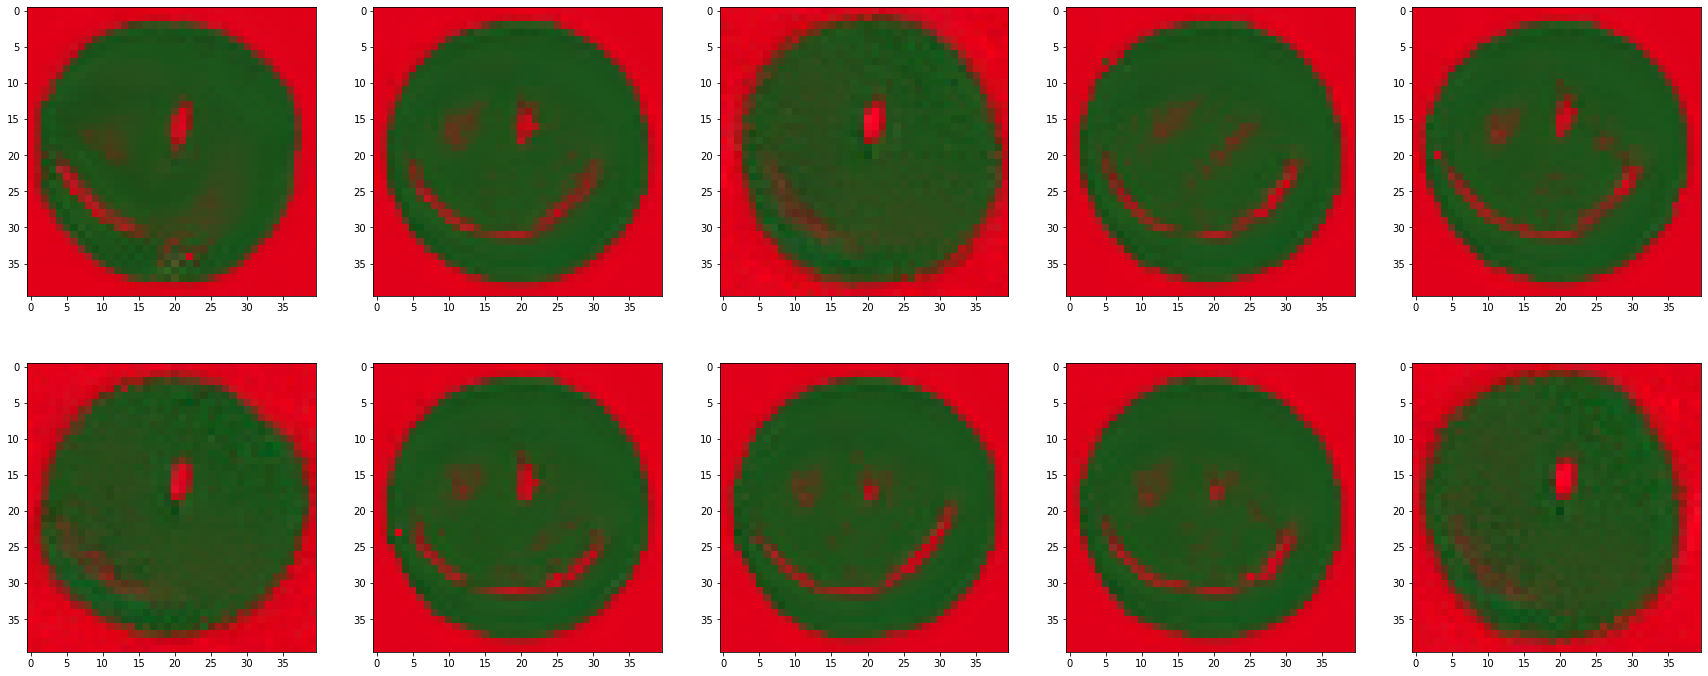

 71%|███████▏  | 2850/4000 [1:47:31<43:18,  2.26s/it]  

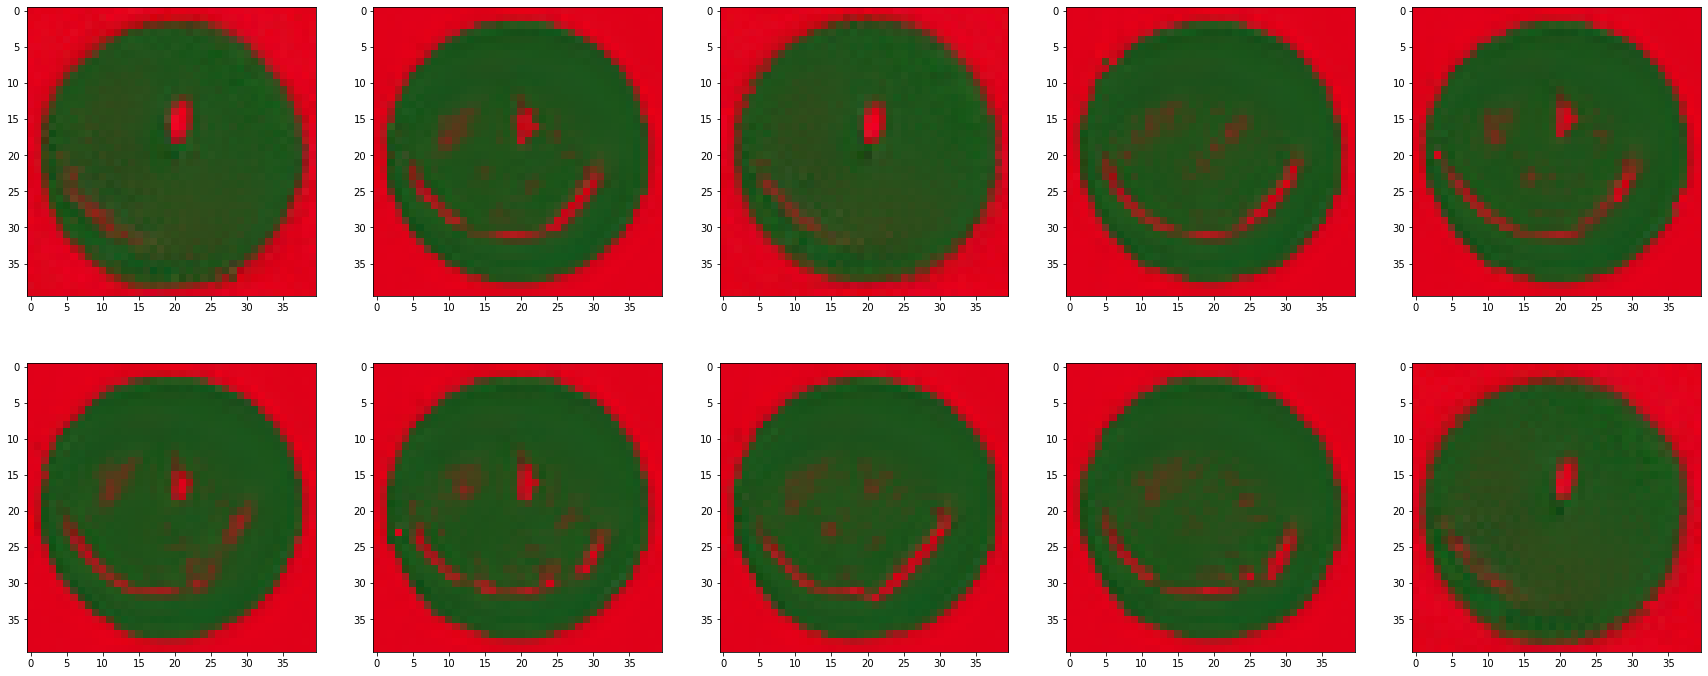

 72%|███████▎  | 2900/4000 [1:49:35<44:28,  2.43s/it]

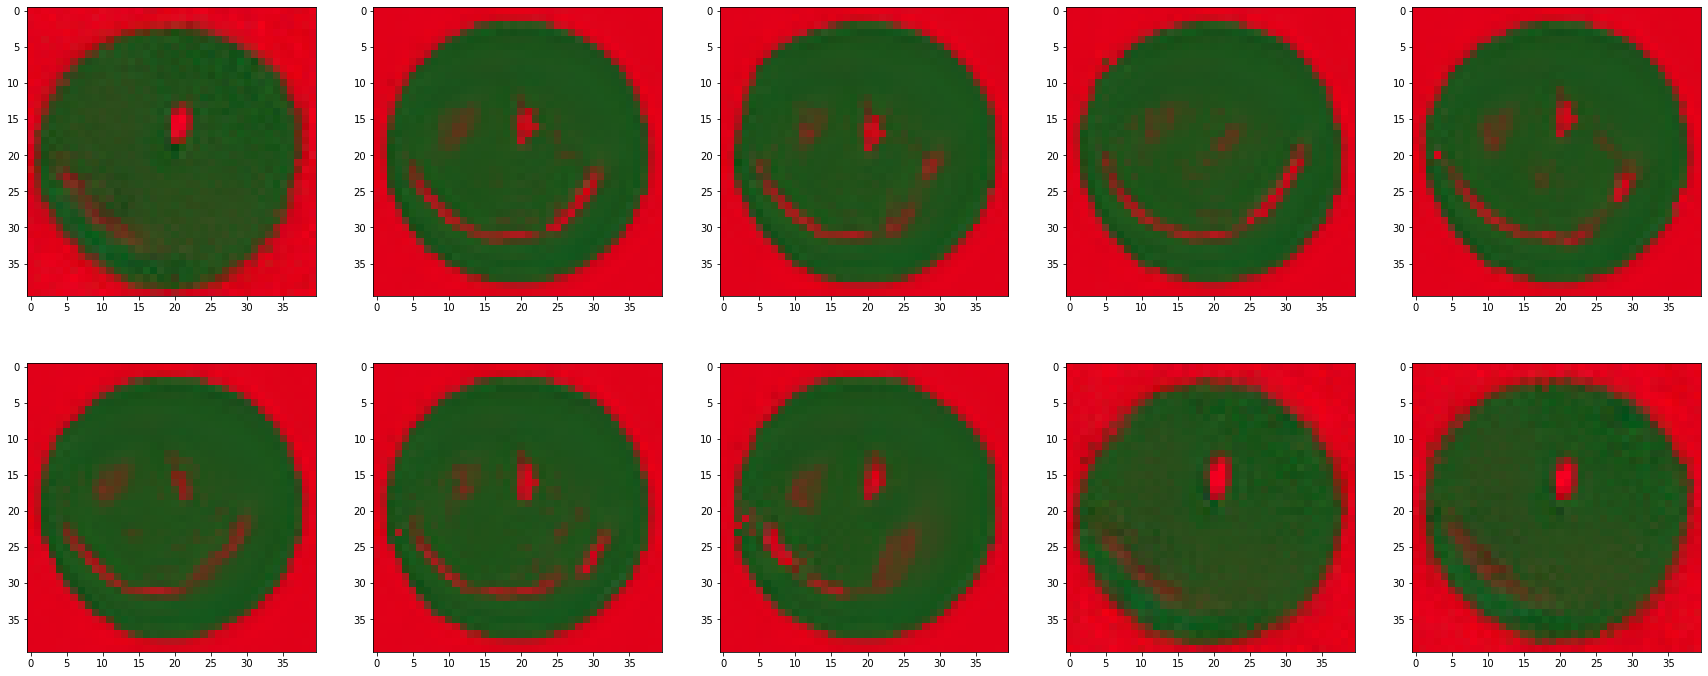

 74%|███████▍  | 2950/4000 [1:51:38<44:02,  2.52s/it]

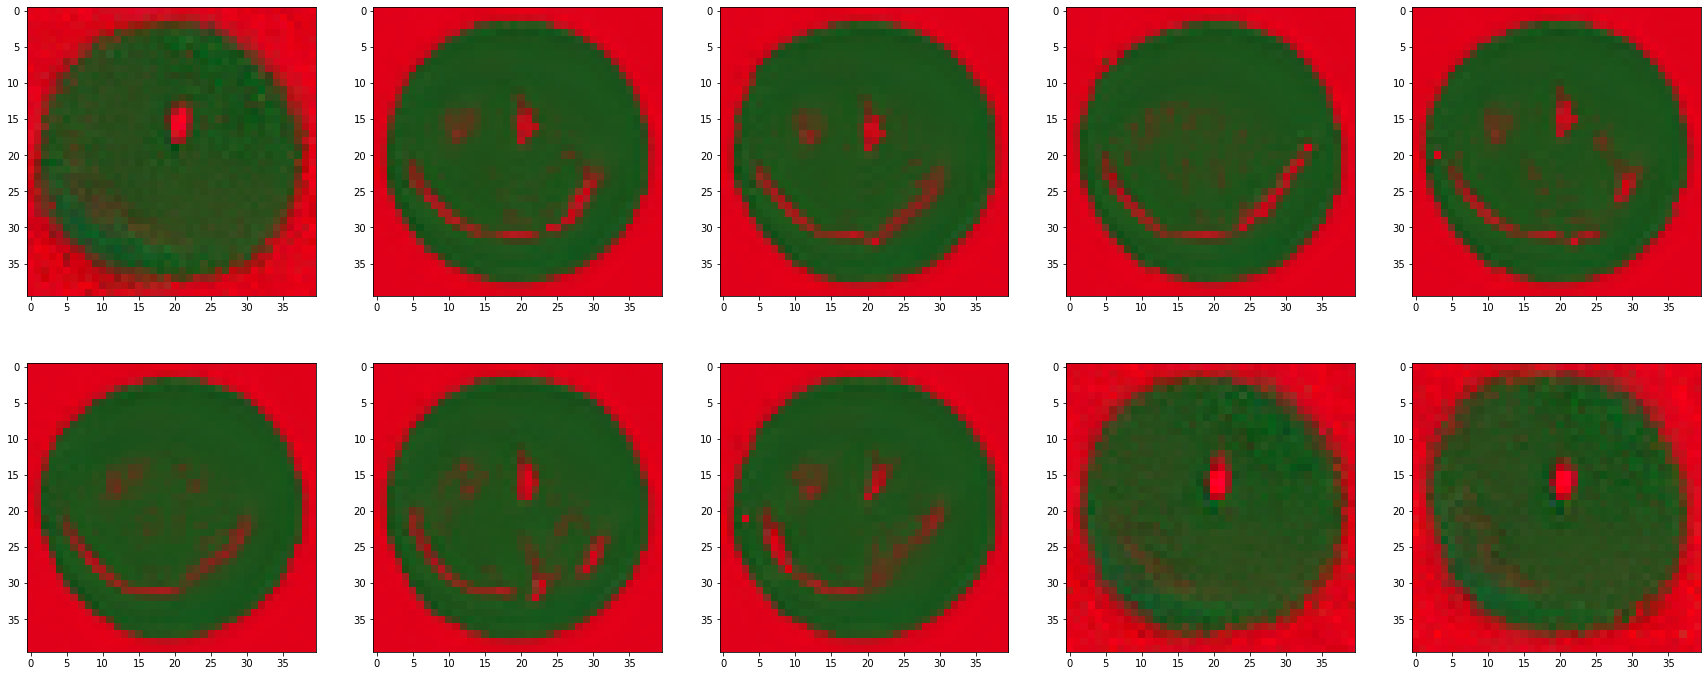

 75%|███████▌  | 3000/4000 [1:53:38<41:59,  2.52s/it]

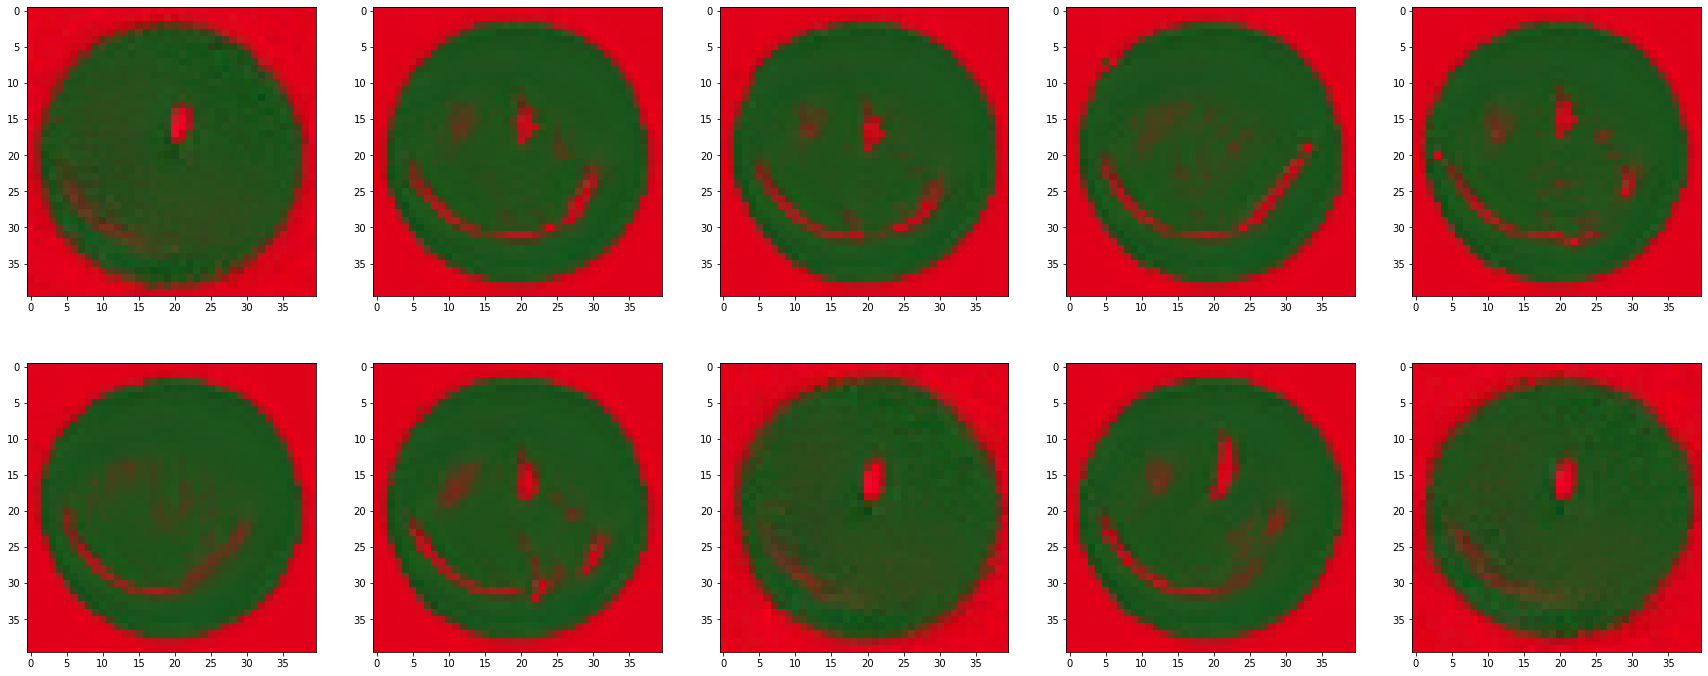

 76%|███████▋  | 3050/4000 [1:55:41<35:48,  2.26s/it]

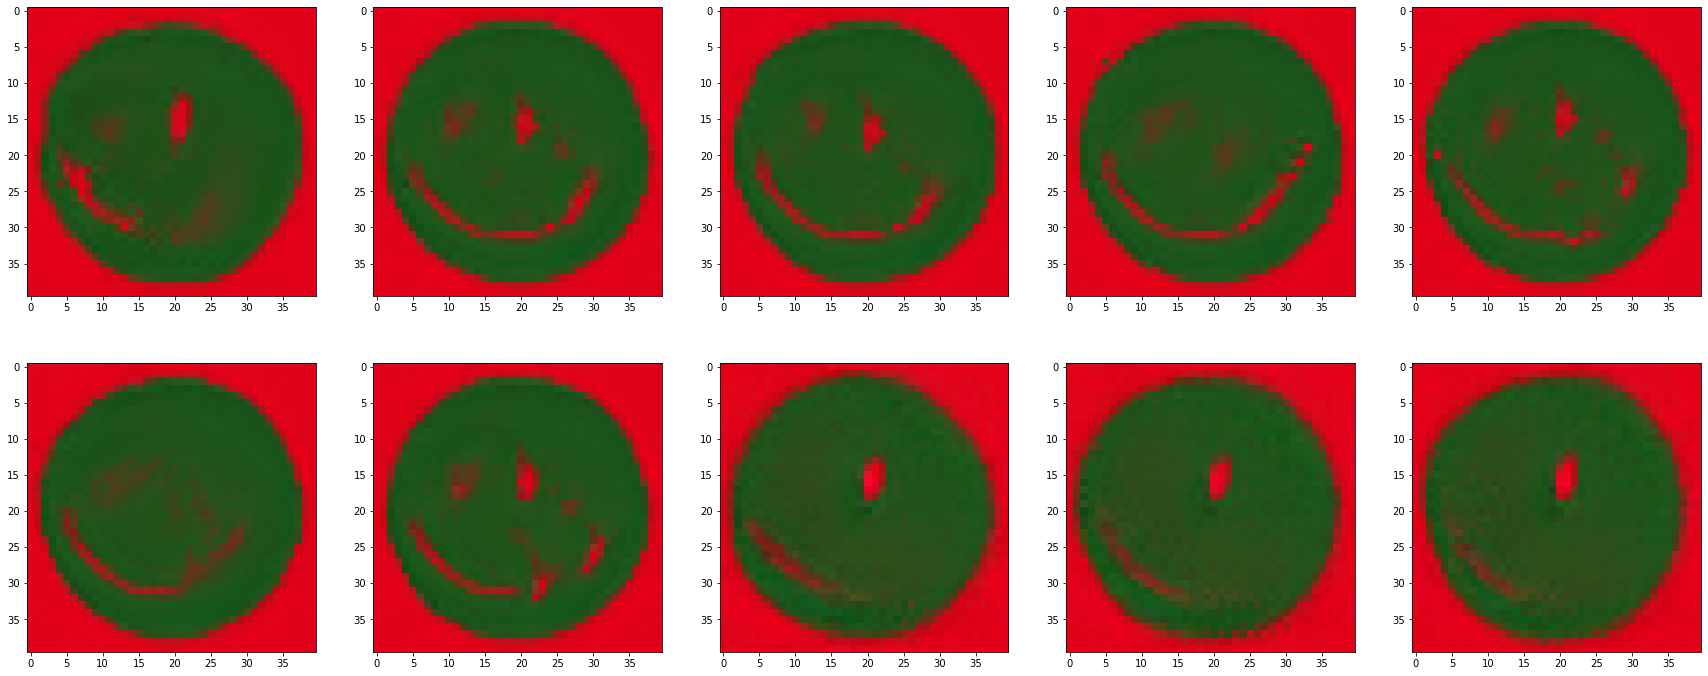

 78%|███████▊  | 3100/4000 [1:57:46<34:58,  2.33s/it]

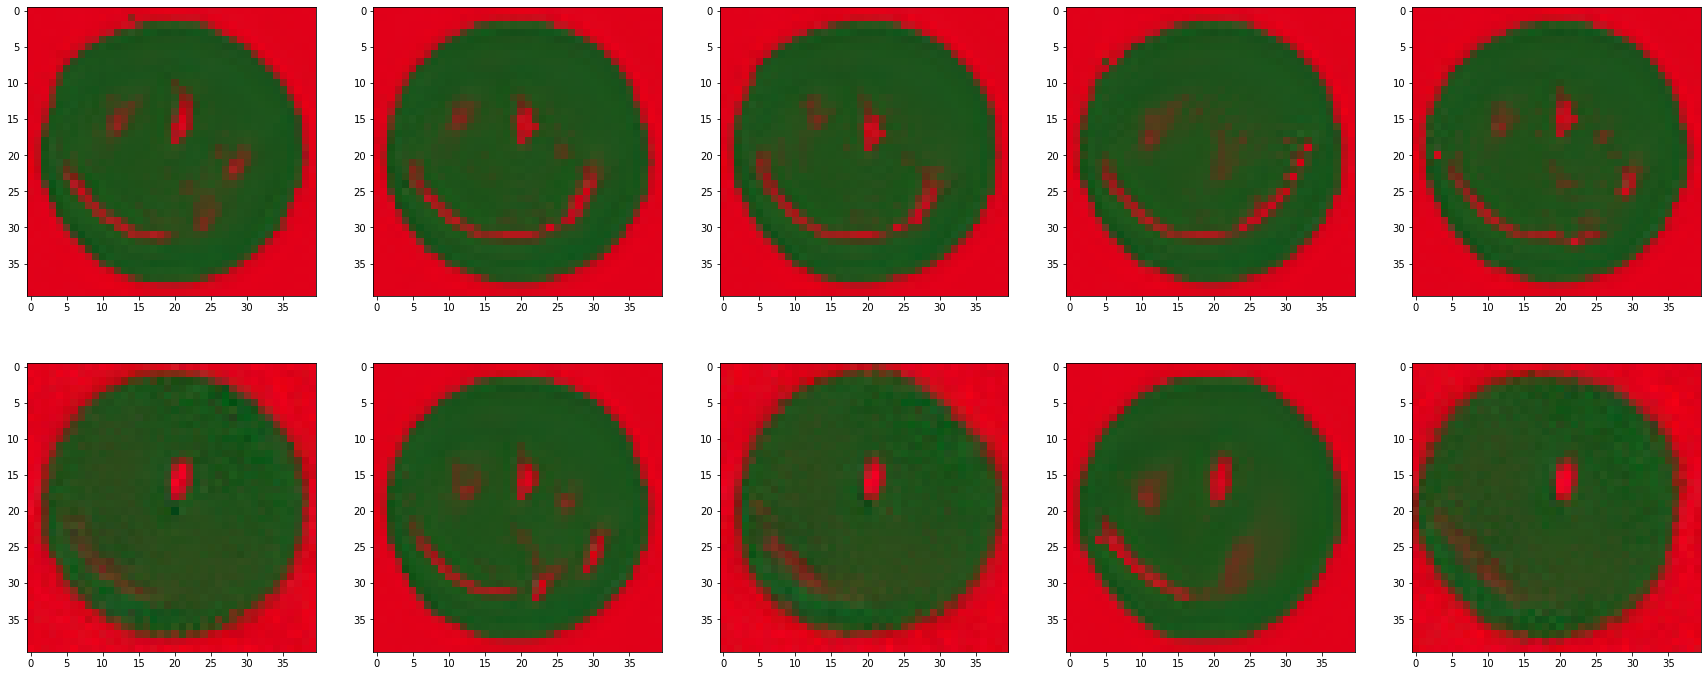

 79%|███████▉  | 3150/4000 [2:00:02<37:18,  2.63s/it]

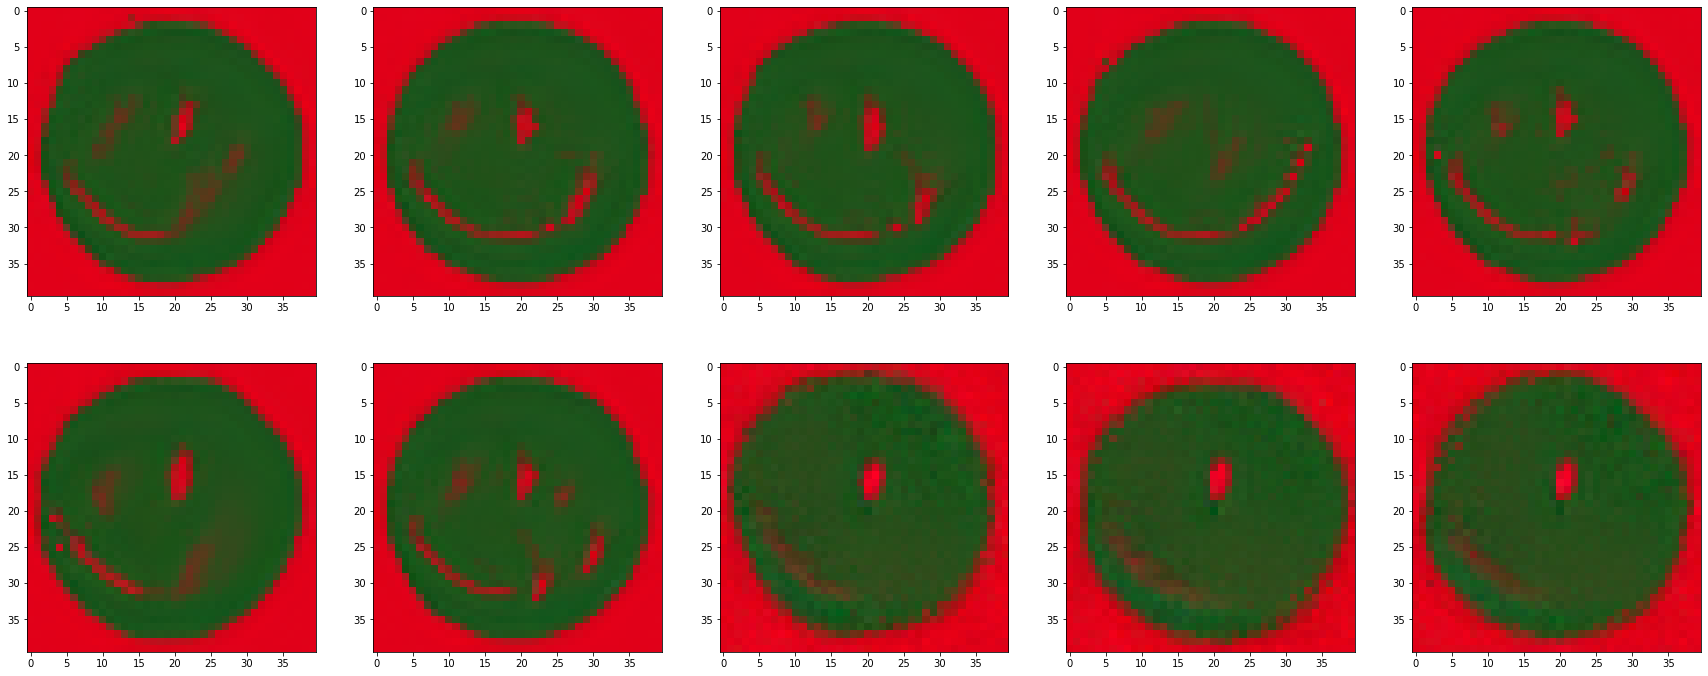

 80%|████████  | 3200/4000 [2:02:08<32:44,  2.46s/it]

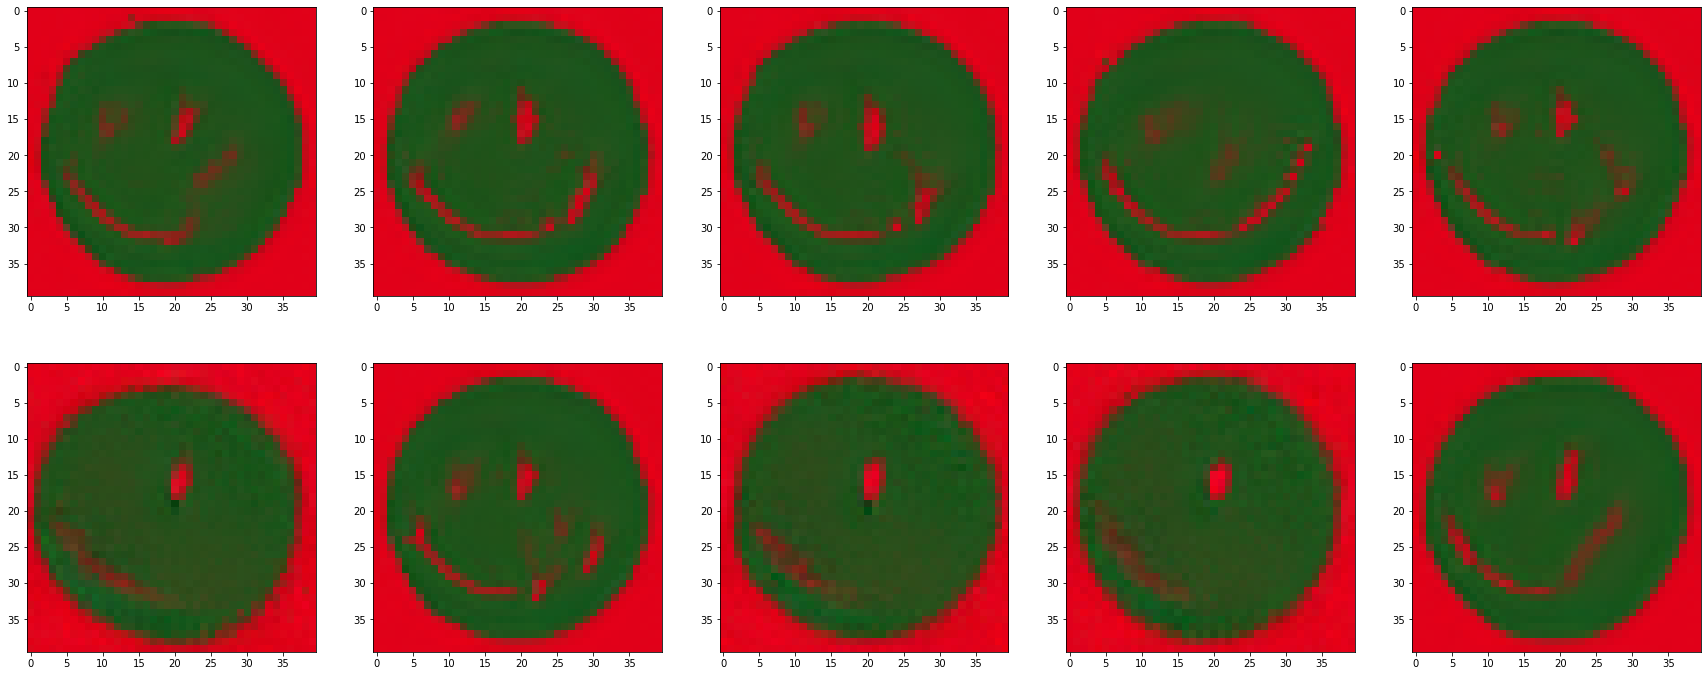

 81%|████████▏ | 3250/4000 [2:04:18<31:52,  2.55s/it]

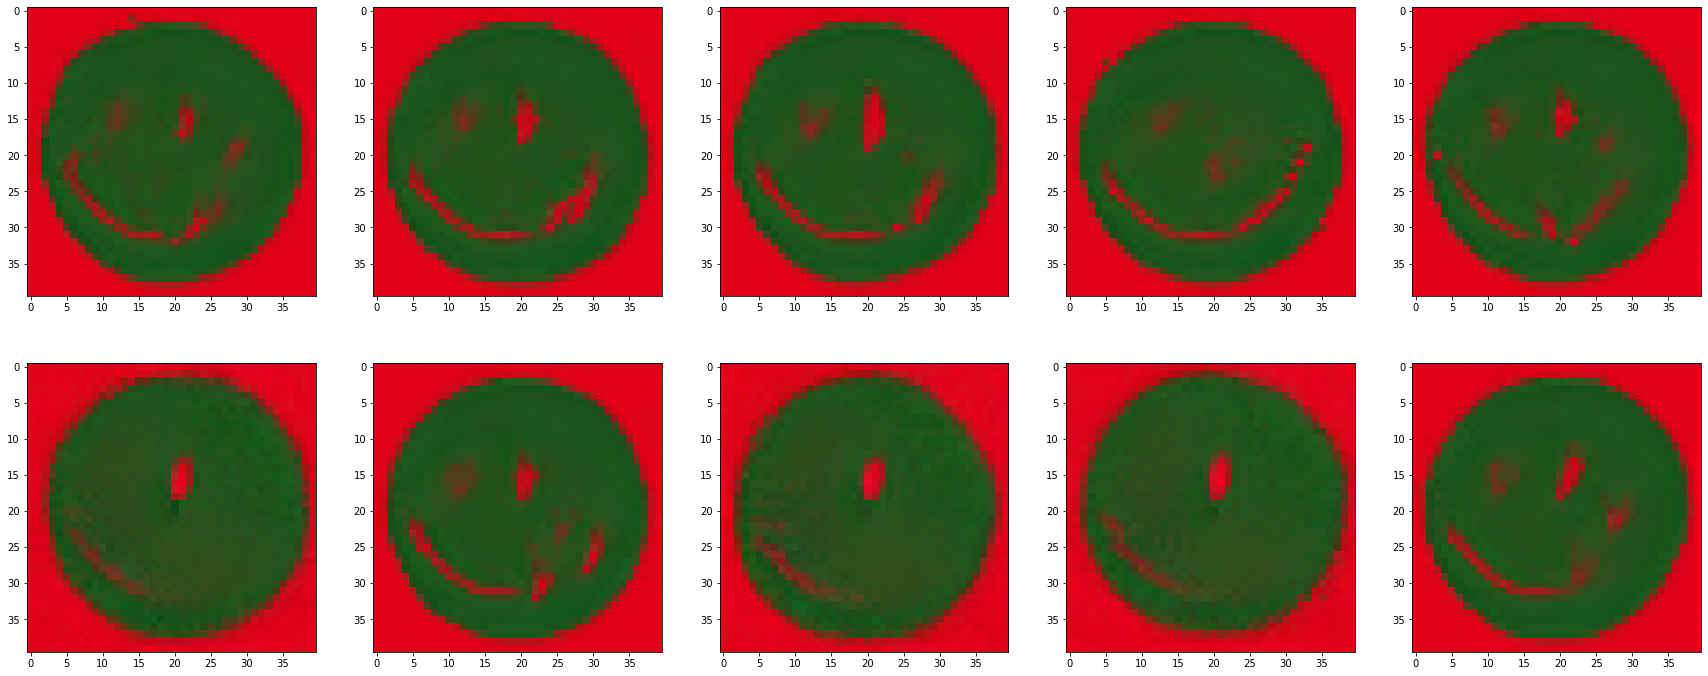

 82%|████████▎ | 3300/4000 [2:06:28<31:27,  2.70s/it]

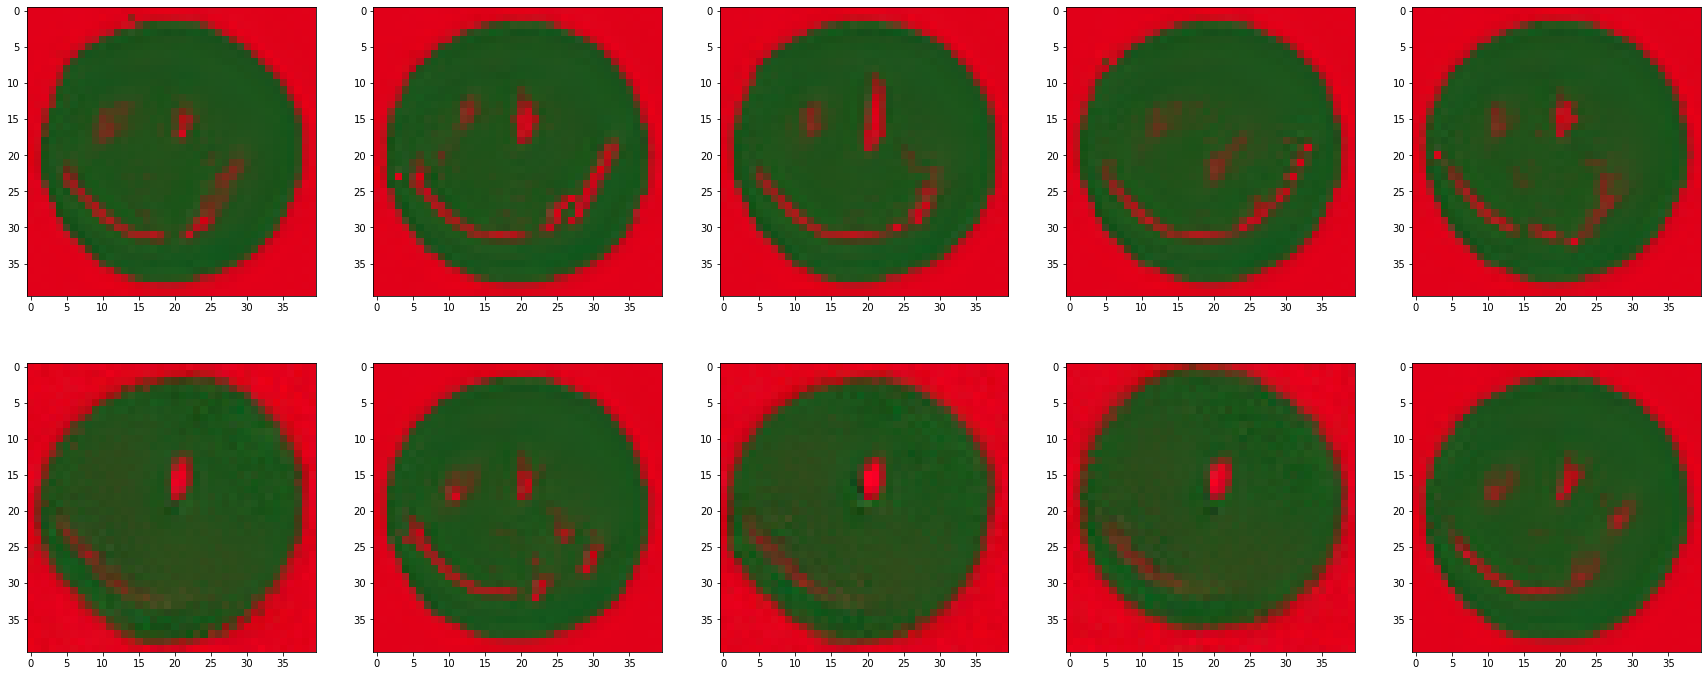

 84%|████████▍ | 3350/4000 [2:08:38<27:52,  2.57s/it]

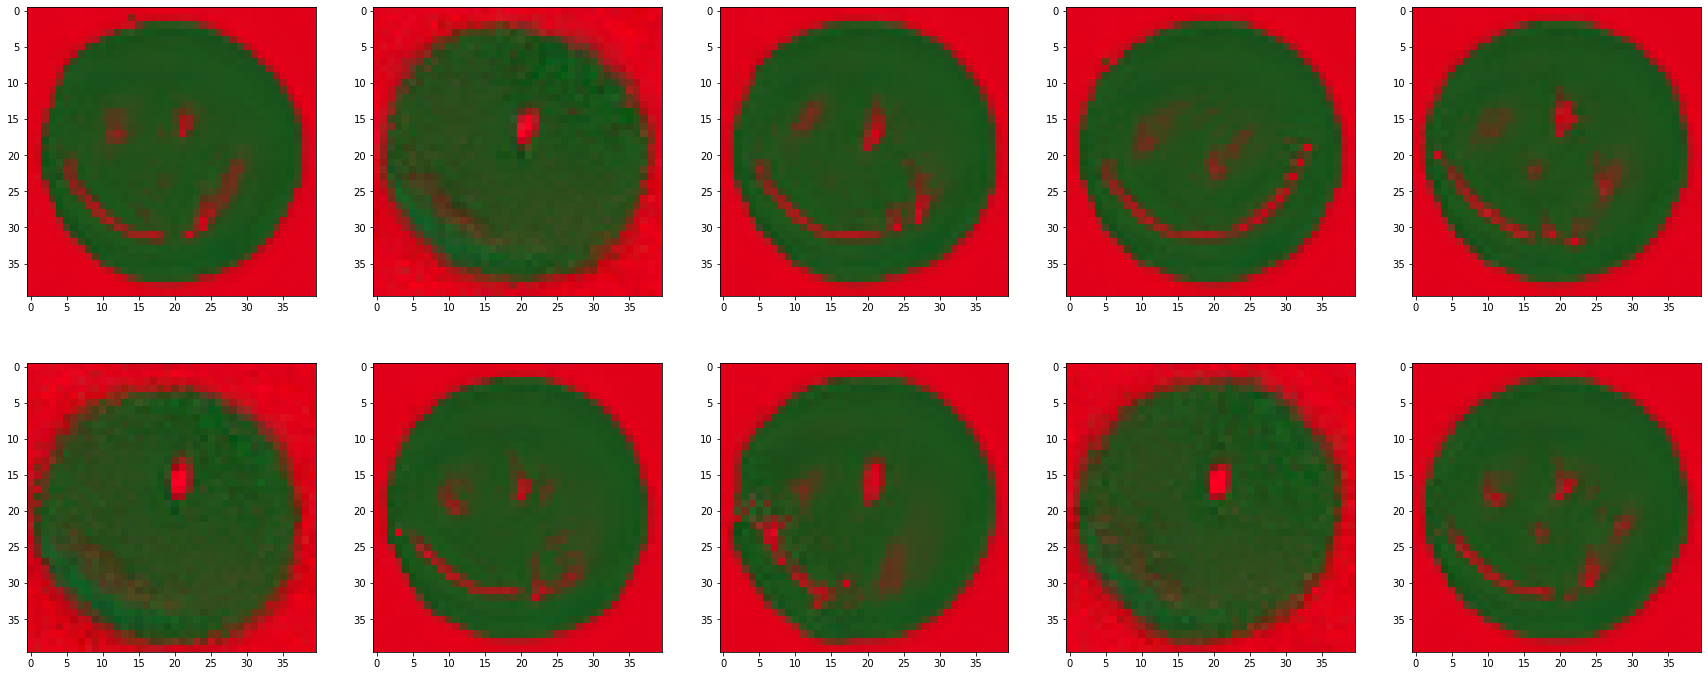

 84%|████████▍ | 3370/4000 [2:09:31<27:34,  2.63s/it]

In [ ]:
pt = torch.cuda.FloatTensor(target).unsqueeze(0)
pt = torch.repeat_interleave(pt, BATCH_SIZE, dim=0)/255.0

NUM_RESET = 3
mse = nn.MSELoss(reduction='none')
total_loss = []

for j in tqdm(range(4000)):
    optim.zero_grad()
    imgs = []
    
    if j < 1:
        x = torch.cuda.FloatTensor(np.zeros((BATCH_SIZE, CHANNEL_N, TARGET_SIZE, TARGET_SIZE)))
        x[:, 3:, TARGET_SIZE//2, TARGET_SIZE//2] = 1
    else:
        x[indices[-NUM_RESET:], 3:, :, :] = torch.cuda.FloatTensor(np.zeros((NUM_RESET, CHANNEL_N-3, TARGET_SIZE, TARGET_SIZE)))
        x[indices[-NUM_RESET:], 3:, TARGET_SIZE//2, TARGET_SIZE//2] = 1
    
    if j == 1000:
        for p in optim.param_groups:
            p['lr'] = 2e-4
            
    if j == 2000: 
        for p in optim.param_groups:
            p['lr'] = 2e-5

    iter_num = np.random.randint(64,96)
    for i in range(iter_num):
        
        
        ##### PLOTTING THINGS #####
        b_nx = []
        for batch_idx in range(0, BATCH_SIZE):
            nx = x.cpu().detach().numpy()[batch_idx, 0:4, :, :].transpose(1, 2, 0)
            nx = rgba2rgb(nx)
            nx = np.uint8(nx*255.0)
            b_nx.append(nx)
        imgs.append(b_nx)
        
        if (i+1)%iter_num == 0 and j%50 == 0:
            fig, axes = plt.subplots(2, 5, figsize=(30, 12))  # for a BATCH_SIZE of 6
            if isinstance(axes, np.ndarray):
                for i_ax, ax in enumerate(axes.flatten()):
                    ax.imshow(imgs[-1][i_ax])
            else:
                axes.imshow(imgs[-1][0])
            plt.show()
        ###########################
        
        x = CA.forward(x, step_size=1, fire_rate=0.5)
            
    loss = mse(x[:, :4, :, :], pt)
    loss_sorted = loss.view(10, -1).sum(dim=1).detach()
    loss = loss.mean()
    total_loss.append(loss)
    _, indices = torch.sort(loss_sorted)
#     print(f'{j}: loss={loss:.5f}')
    loss.backward()
    
    # normalize gradients
    for p in CA.parameters():
        if p.grad is not None:
            p.grad = p.grad / (1e-8 + torch.norm(p.grad))
    
    # no bias gradients (??)
#     for m in CA.modules():
#       if isinstance(m, nn.Conv2d):
#         m.bias.grad = m.bias.grad * 0 
        
    optim.step()

    x = x.detach() 
    
    if j % 100 == 0:
        time = time.strftime("%Y%m%d-%H%M%S")
        fname = f'model/CA_{j}_' + time
        torch.save(CA, fname)


In [357]:
for i in range(0, BATCH_SIZE):
    ex_img = np.array(imgs)[:, i, :, :, :]

    fname = time.strftime("%Y%m%d-%H%M%S") + f'_{i}'
    out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (TARGET_SIZE, TARGET_SIZE), 3)

    for img in ex_img[:]:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
    out.release()

# Run Trained Model

In [42]:
CA_test = torch.load('test')

250


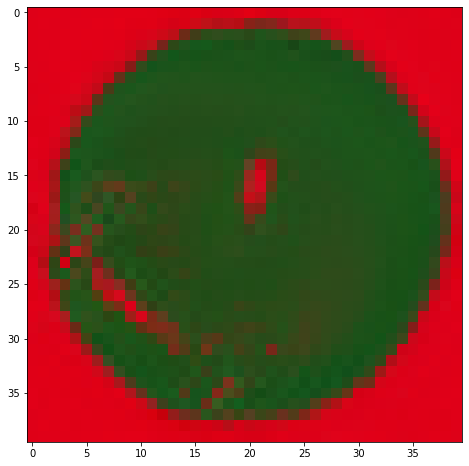

KeyboardInterrupt: 

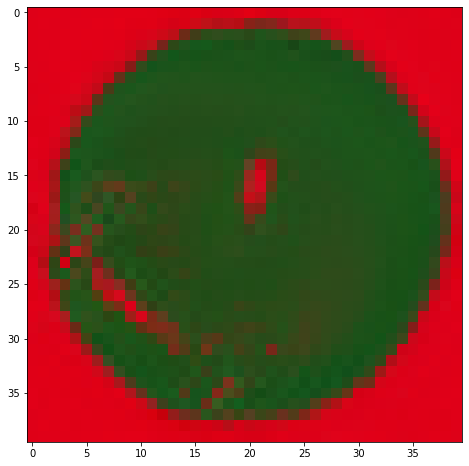

In [47]:
# x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, 256, 256))).unsqueeze(0)
SIZE = TARGET_SIZE
x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
x[:, 3:, SIZE//2, SIZE//2] = 1
imgs = []

for i in range(1000):
    
    with torch.no_grad():
        nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
    #     nx = np.uint8(nx*255.0)
        imgs.append(nx)

        x = CA.forward(x, step_size=1, fire_rate=0.5)
        x = x.detach()


        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            display.clear_output(wait=True)
            print(f'{i}')
            display.display(plt.gcf())
            time.sleep(0.01)

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [32]:
fname = 'model/CA_model_' + time.strftime("%Y%m%d-%H%M%S") + '.pb'
torch.save(CA.dmodel, fname)

In [30]:
CA = CAModel()

CA.dmodel = torch.load(fname)
CA.cuda()

CAModel(
  (dmodel): Sequential(
    (conv1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)